# Evaluation of trained network for temporal super-resolution

In [1]:
#%matplotlib notebook
import ipywidgets as widgets
from ipywidgets import HBox, VBox
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
from IPython.display import display
from mpl_toolkits.axes_grid1 import make_axes_locatable
from utils.evaluate_utils import *
import pandas as pd
import matplotlib.cm as cm
import matplotlib.image as mpimg
plt.rcParams['figure.figsize'] = [10, 8]
%matplotlib inline
from utils.colors import *

In [2]:
df = pd.read_csv('../results/Overview_models.csv')
df1 = df[['Name', 'notes']]
pd.set_option("max_colwidth", None)
display(df1)

,Name,notes
0,Temporal4DFlowNet_20230210-0333,NaN
1,Temporal4DFlowNet_20230215-1029,NaN
2,Temporal4DFlowNet_20230217-0602,NaN
3,Temporal4DFlowNet_20230220-0908,NaN
4,Temporal4DFlowNet_20230301-1127,First training on radial sampled data
5,Temporal4DFlowNet_20230301-1641,Basecheck with adapted network code and higher batch size of 32. (Resnet)
6,Temporal4DFlowNet_20230301-1654,First training with densenet blocks (Densenet)
7,Temporal4DFlowNet_20230301-1704,First training with cspnet blocks (CSPnet)
8,Temporal4DFlowNet_20230305-1001,Less depth: 4 -2
9,Temporal4DFlowNet_20230305-1002,Depth change (balance between high lowres blocks): 6 - 6


### Set model and dataset to evaluate


In [3]:
# Define directories and filenames

model_name = '20230620-0909'#'20230602-1701'#'20230308-1226'#'20230404-1418'#'20230313-0948'#'20230301-1641'  #'20230308-1226'# #'#'20230308-1226' #'20230301-1641'  '20230301-1654', '20230301-1704'
set_name = 'Test'               
data_model = '4'
step = 2

add_ending = ''#'_newmag'#''#'_newmag'

use_dynamical_mask = True
offset = False

### Set evaluation files to compare relative error to


In [4]:
vel_colnames=['u', 'v', 'w']
vel_colnames_fluid = ['u_fluid', 'v_fluid', 'w_fluid']

def load_data(model_name, set_name, data_model, step,dynamic_mask_used, ending_file= ''):
    #directories
    gt_dir = '../data/CARDIAC'
    result_dir = f'../results/Temporal4DFlowNet_{model_name}'
    eval_dir = f'{result_dir}/plots'
    lr_dir = '../data/CARDIAC'

    inbetween_string = ''
    add_offset = ''
    if dynamic_mask_used:
        inbetween_string = '_dynamic'
    if offset:
        print('LR is now sampled with offset of 1')
        add_offset = '_offset1'
        offset_val = 1
    else:
        offset_val = 0

    #/home/pcallmer/Temporal4DFlowNet/data/CARDIAC/M4_2mm_step2_invivoP02_magnitude_adapted_noisy.h5
    #filenames
    gt_filename = f'M{data_model}_2mm_step{step}_static{inbetween_string}.h5'
    lr_filename = f'M{data_model}_2mm_step{step}_static{inbetween_string}_noise.h5' #_noise
    # gt_filename = f'M{data_model}_2mm_step{step}_invivoP02_magnitude.h5'
    # lr_filename = f'M{data_model}_2mm_step{step}_invivoP02_magnitude_noisy.h5'
    # gt_filename = f'M{data_model}_2mm_step{step}_invivoP01_magnitude.h5'
    # lr_filename = f'M{data_model}_2mm_step{step}_invivoP01_magnitude_noisy.h5'

    result_filename = f'{set_name}set_result_model{data_model}_2mm_step{step}_{model_name[-4::]}_temporal{ending_file}{add_offset}.h5' #_newpadding
    evaluation_filename = f'eval_rel_err_{data_model}_2mm_step{step}_{model_name[-4::]}_temporal.h5'

    print(gt_filename, lr_filename)

    if not os.path.isdir(eval_dir):
        os.makedirs(eval_dir)

    #Params for evalation
    save_relative_error_file= False

    # Setting up
    gt_filepath = '{}/{}'.format(gt_dir, gt_filename)
    res_filepath = '{}/{}'.format(result_dir, result_filename)
    lr_filepath = '{}/{}'.format(lr_dir, lr_filename)
    

    if save_relative_error_file:
        assert(not os.path.exists(f'{result_dir}/{evaluation_filename}')) #STOP if relative error file is already created

    
    gt = {}
    lr = {}
    pred = {}

    with h5py.File(res_filepath, mode = 'r' ) as h_pred:
        with h5py.File(gt_filepath, mode = 'r' ) as h_gt:
            with h5py.File(lr_filepath, mode = 'r' ) as h_lr:
                
                gt["mask"] = np.asarray(h_gt["mask"]).squeeze()
                gt["mask"][np.where(gt["mask"] !=0)] = 1
                if len(gt['mask'].shape) == 4 : # check for dynamical mask, otherwise create one
                    temporal_mask = gt['mask'].copy()
                else:
                    print('Create static temporal mask for model')
                    temporal_mask = create_temporal_mask(gt["mask"], h_gt['u'].shape[0])
                gt['mask'] = temporal_mask.copy()
                lr['mask'] = temporal_mask[offset_val::2, :, :, :].copy()
                print(gt['mask'].shape)

                # adapt dimension
                for vel in vel_colnames:
                    
                    gt[vel] = np.asarray(h_gt[vel])
                    pred[vel] = np.asarray(h_pred[f'{vel}_combined'])   
                    lr[vel] = np.asarray(h_lr[vel])[offset_val::2, :, :, :]       

                    print('pred shape', pred[vel].shape)
                    # add information considering only the fluid regions  
                    pred[f'{vel}_fluid'] =np.multiply(pred[vel], temporal_mask)
                    lr[f'{vel}_fluid'] =  np.multiply(lr[vel], lr['mask'])
                    gt[f'{vel}_fluid'] =  np.multiply(gt[vel], temporal_mask)

                    
                #include speed calculations
                gt['speed']   = np.sqrt(gt["u"]**2 + gt["v"]**2 + gt["w"]**2)
                lr['speed']   = np.sqrt(lr["u"]**2 + lr["v"]**2 + lr["w"]**2)
                pred['speed'] = np.sqrt(pred["u"]**2 + pred["v"]**2 + pred["w"]**2)

                gt['speed_fluid']   = np.multiply(gt['speed'], temporal_mask)
                lr['speed_fluid']   = np.multiply(lr['speed'], lr['mask'])
                pred['speed_fluid'] = np.multiply(pred['speed'], temporal_mask)


    return lr, gt, pred, temporal_mask, eval_dir

def load_interpolation(data_model, step, lr, gt, use_dynamical_mask):
    
    interpolate_NN = {}
    interpolate_linear = {}
    interpolate_cubic = {}


    inbetween_string = ''
    if use_dynamical_mask:
        inbetween_string = '_dynamic'

    lr_filename = f'M{data_model}_2mm_step{step}_static{inbetween_string}_noise.h5'


    interpolation_file= f'../results/interpolation/{lr_filename[:-3]}_interpolation'
    if not os.path.isfile(interpolation_file):
        print("Interpolation file does not exist - calculate interpolation and save files")
        print("Save interpolation files to: ", interpolation_file)
        
        #this can take a while
        for vel in vel_colnames:
            print("Interpolate low resolution images - ", vel)
            print(gt['mask'].shape)
            interpolate_linear[vel] = temporal_linear_interpolation(lr[vel], gt[vel].shape)
            interpolate_linear[f'{vel}_fluid'] = np.multiply(interpolate_linear[vel], gt['mask'])

            interpolate_cubic[vel] = temporal_cubic_interpolation(lr[vel], gt[vel].shape)
            interpolate_cubic[f'{vel}_fluid'] = np.multiply(interpolate_cubic[vel], gt['mask'])

            interpolate_NN[vel] = temporal_NN_interpolation(lr[vel], gt[vel].shape)
            interpolate_NN[f'{vel}_fluid'] = np.multiply(interpolate_NN[vel], gt['mask'])

            prediction_utils.save_to_h5(interpolation_file, f'linear_{vel}' , interpolate_linear[vel], compression='gzip')
            prediction_utils.save_to_h5(interpolation_file, f'cubic_{vel}' , interpolate_cubic[vel], compression='gzip')
            prediction_utils.save_to_h5(interpolation_file, f'NN_{vel}' , interpolate_NN[vel], compression='gzip')
    else:
        print("Load existing interpolation file")
        with h5py.File(interpolation_file, mode = 'r' ) as h_interpolate:
            for vel in vel_colnames:
                interpolate_linear[vel] = np.array(h_interpolate[f'linear_{vel}'])
                interpolate_cubic[vel] =  np.array(h_interpolate[f'cubic_{vel}'])
                interpolate_NN[vel] =     np.array(h_interpolate[f'NN_{vel}'])


                interpolate_linear[f'{vel}_fluid'] = np.multiply(interpolate_linear[vel], gt['mask'])
                interpolate_cubic[f'{vel}_fluid'] = np.multiply(interpolate_cubic[vel], gt['mask'])
                interpolate_NN[f'{vel}_fluid'] = np.multiply(interpolate_NN[vel], gt['mask'])

    return interpolate_linear, interpolate_cubic, interpolate_NN

lr, gt, pred, temporal_mask, eval_dir = load_data(model_name, set_name, data_model, step, use_dynamical_mask, ending_file=add_ending)
interpolate_linear, interpolate_cubic, interpolate_NN = load_interpolation(data_model, step,lr, gt, use_dynamical_mask)

M4_2mm_step2_static_dynamic.h5 M4_2mm_step2_static_dynamic_noise.h5
(50, 62, 58, 84)


pred shape (50, 62, 58, 84)
pred shape (50, 62, 58, 84)
pred shape (50, 62, 58, 84)
Load existing interpolation file


In [5]:
if use_dynamical_mask:
    inbetween_string = '_dynamic'

interpolate_sinc = {}
sinc_interpolate_file =  f'../data/CARDIAC/M{data_model}_2mm_step{step}_static{inbetween_string}_noise_sinc.h5'
with h5py.File(sinc_interpolate_file, mode = 'r' ) as h_sinc_interpolate:
    
    _, x, y, z = np.array(h_sinc_interpolate['u']).squeeze().shape
    print(x, y, z)
    for vel in vel_colnames:
        interpolate_sinc[vel] = np.array(h_sinc_interpolate[vel]).squeeze()
        interpolate_sinc[vel] = np.concatenate([interpolate_sinc[vel], np.zeros((1, x, y, z))],axis=0 )
        print('Interpolation shapes: ', interpolate_sinc[vel].shape)
        interpolate_sinc[f'{vel}_fluid'] = np.multiply(interpolate_sinc[vel], gt['mask'])

62 58 84
Interpolation shapes:  (50, 62, 58, 84)
Interpolation shapes:  (50, 62, 58, 84)
Interpolation shapes:  (50, 62, 58, 84)


### Calculate relative error and mean speed

In [6]:
rel_error =calculate_relative_error_normalized(pred["u"], pred["v"], pred["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])
error_pointwise, error_absolut = calculate_pointwise_error(pred["u"], pred["v"], pred["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])
rel_error_lin_interpolation =   calculate_relative_error_normalized(interpolate_linear["u"], interpolate_linear["v"], interpolate_linear["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])
rel_error_cubic_interpolation = calculate_relative_error_normalized(interpolate_cubic["u"], interpolate_cubic["v"], interpolate_cubic["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])

for vel in vel_colnames:
    error_absolut[f'{vel}_fluid'] = np.multiply(error_absolut[vel], gt["mask"])

# mean speed of gt and prediction
gt['mean_speed'] = calculate_mean_speed(gt["u_fluid"], gt["v_fluid"] , gt["w_fluid"], gt["mask"])
pred['mean_speed'] = calculate_mean_speed(pred["u_fluid"], pred["v_fluid"] , pred["w_fluid"], gt["mask"])
lr['mean_speed'] = calculate_mean_speed(lr["u_fluid"], lr["v_fluid"] , lr["w_fluid"], gt["mask"][::2])
interpolate_linear['mean_speed'] = calculate_mean_speed(interpolate_linear["u_fluid"], interpolate_linear["v_fluid"] ,interpolate_linear["w_fluid"], gt["mask"])
interpolate_cubic['mean_speed'] = calculate_mean_speed(interpolate_cubic["u_fluid"], interpolate_cubic["v_fluid"] , interpolate_cubic["w_fluid"], gt["mask"])
# interpolate_sinc['mean_speed'] = calculate_mean_speed(interpolate_sinc["u_fluid"], interpolate_sinc["v_fluid"] , interpolate_sinc["w_fluid"], gt["mask"])

max/min before tanh 59968.402 0.0
max/min after tanh 1.0 0.0


2023-08-18 10:14:32.226870: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-18 10:14:32.227226: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-18 10:14:32.282965: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-18 10:14:32.283339: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-18 10:14:32.283649: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

max/min before tanh 316548.22 0.0
max/min after tanh 1.0 0.0
max/min before tanh 1304849.0 0.0
max/min after tanh 1.0 0.0


In [7]:
vel_colnames = ['u', 'v', 'w']
min_v = {}
max_v = {}
for vel in vel_colnames:
    min_v[vel] = np.quantile(gt[vel][np.where(temporal_mask !=0)].flatten(), 0.01)
    max_v[vel] = np.quantile(gt[vel][np.where(temporal_mask !=0)].flatten(), 0.99)

min_v['speed'] = np.quantile(gt[vel][np.where(temporal_mask !=0)].flatten(), 0.01)
max_v['speed'] = np.quantile(gt[vel][np.where(temporal_mask !=0)].flatten(), 0.99)

#get boundary points
bounds, core_mask = get_boundaries(temporal_mask)


# Plotting

In [ ]:
N_frames = gt['mean_speed'].shape[0]

lr_speed = np.sqrt(np.square(lr['u'])+ np.square(lr['v'])+ np.square(lr['w']))
lr_speed_fluid = np.multiply(lr_speed, gt['mask'][::2])
if False: 
    plt.subplot(1,1,1)
    plt.plot(gt['mean_speed'], '.-',label ='Ground truth', color = 'black')
    plt.plot(pred['mean_speed'],'.-', label= '4DFlowNet', color = KTH_colors['blue100'])
    plt.plot(range(0, N_frames, 2),  lr['mean_speed'],'.-',  label = 'LR', color = KTH_colors['green100'])
    # plt.plot(interpolate_linear['mean_speed'][:-1],'--', label = 'linear interpolation', color = 'pink')
    # plt.plot(interpolate_cubic['mean_speed'][:-1] , label = 'cubic interpoaltion', color = 'forestgreen')
    plt.xlabel("Frame")
    plt.ylabel("Mean speed (cm/s)")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_mean_val(v, mask):
    assert(v.shape[0] == mask.shape[0])
    N_frames = v.shape[0]
    
    mean_speed = np.zeros(N_frames)
    for t in range(N_frames):
        points_in_mask = np.where(mask[t] !=0)
        mean_speed[t] = np.average(v[t, points_in_mask[0], points_in_mask[1], points_in_mask[2]])
    return mean_speed

# def plot_mean_val2(v, mask):
#     fluid_vals= get_fluid_region_points(v, mask)
#     return np.mean(fluid_vals, axis = 1)
if True: 
    plt.title('Average velocity over time')
    plt.subplot(3,1,1)
    plt.plot(plot_mean_val(gt['u'], gt['mask']), '.-',label ='Ground truth', color = 'black')
    plt.plot(plot_mean_val(pred['u'], gt['mask']),'-', label= '4DFlowNet', color = KTH_colors['blue100'])
    plt.plot(range(0, N_frames, 2), plot_mean_val(lr['u'], gt['mask'][::2]),'.-', label= 'LR', color = KTH_colors['green100'])
    plt.legend()
    plt.title(r'$V_x$')

    plt.subplot(3,1,2)
    plt.plot(plot_mean_val(gt['v'], gt['mask']), '.-',label ='Ground truth', color = 'black')
    plt.plot(plot_mean_val(pred['v'], gt['mask']),'-', label= '4DFlowNet', color = KTH_colors['blue100'])
    plt.plot(range(0, N_frames, 2), plot_mean_val(lr['v'], gt['mask'][::2]),'.-', label= 'LR', color = KTH_colors['green100'])
    plt.legend()
    plt.title(r'$V_y$')

    plt.subplot(3,1,3)
    plt.plot(plot_mean_val(gt['w'], gt['mask']), '.-',label ='Ground truth', color = 'black')
    plt.plot(plot_mean_val(pred['w'], gt['mask']),'-', label= '4DFlowNet', color = KTH_colors['blue100'])
    plt.plot(range(0, N_frames, 2), plot_mean_val(lr['w'], gt['mask'][::2]),'.-', label= 'LR', color = KTH_colors['green100'])
    plt.title(r'$V_z$')
    plt.legend()
    plt.show()

    plt.plot(plot_mean_val(gt['speed'], gt['mask'])*100, '.-',label ='Ground truth', color = 'black')
    plt.plot(plot_mean_val(pred['speed'], gt['mask'])*100,'-', label= '4DFlowNet', color = KTH_colors['blue100'])
    plt.plot(range(0, N_frames, 2), plot_mean_val(lr_speed, gt['mask'][::2])*100,'.-', label= 'LR speed', color = KTH_colors['green100'])
    plt.plot(gt['mean_speed'], '--',label ='Ground truth', color = 'black')
    plt.plot(pred['mean_speed'],'--', label= '4DFlowNet', color = KTH_colors['blue100'])
    plt.plot(range(0, N_frames, 2),  lr['mean_speed'],'--',  label = 'LR', color = KTH_colors['green100'])

print(np.average(gt['speed_fluid']), np.average(pred['speed_fluid']), np.average(lr['speed_fluid']))

# for v in vel_colnames:
#     print(np.linalg.norm(plot_mean_val2(gt[v], gt['mask']) - plot_mean_val(gt[v], gt['mask'])))
    # print(plot_mean_val2(gt[v], gt['mask']) - plot_mean_val(gt[v], gt['mask']))
avg_gt, avg_pred, avg_lr = np.zeros(N_frames), np.zeros(N_frames), np.zeros(N_frames)
for t in range(N_frames):
    points_in_mask_t = np.where(gt['mask'][t] !=0)
    if t%2 == 0:
        points_in_mask_t_lr = np.where(gt['mask'][t] !=0)
        avg_lr[t] = np.average(lr_speed[t//2][points_in_mask_t_lr])
    avg_gt[t] = np.average(gt['speed'][t][points_in_mask_t])
    avg_pred[t] = np.average(pred['speed'][t][points_in_mask_t])
    
    # print(avg_gt, avg_pred, avg_lr)
fig = plt.figure(figsize=(5,4))
plt.plot(range(0, N_frames,2) , avg_lr[::2]*100,'.-',  label = 'Low resolution', color = KTH_colors['green100'])
plt.plot(avg_gt*100, '.-',label ='High resolution', color = 'black')
plt.plot(avg_pred*100,'.-', label= '4DFlowNet', color = KTH_colors['blue100'])
plt.xlabel("Frame")
plt.ylabel("Mean speed (cm/s)")
plt.legend()
plt.tight_layout()
plt.savefig(f'{eval_dir}/{set_name}_M{data_model}_mean_speed_{model_name}.pdf')

plt.plot(gt['mean_speed'], 'x-',label ='Ground truth', color = 'black')
plt.plot(pred['mean_speed'],'x-', label= '4DFlowNet', color = KTH_colors['blue100'])
plt.plot(range(0, N_frames, 2),  lr['mean_speed'],'x-',  label = 'LR', color = KTH_colors['green100'])

plt.plot(plot_mean_val(gt['speed'], gt['mask'])*100, '.-',label ='Ground truth', color = 'red')
# plt.plot(plot_mean_val2(gt['speed'], gt['mask'])*100, '--',label ='Ground truth', color = 'pink')
plt.plot(plot_mean_val(pred['speed'], gt['mask'])*100,'-', label= '4DFlowNet', color = KTH_colors['blue100'])
plt.plot(range(0, N_frames, 2), plot_mean_val(lr_speed, gt['mask'][::2])*100,'.-', label= 'LR speed', color = KTH_colors['green100'])
plt.legend()
plt.ylim(4, 25)

In [ ]:
def calculate_mean_speed2(u_hi, v_hi, w_hi, binary_mask):
    '''
    Calculate mean speed of given values. Assumption: Values are in m/sec and mean speed returned in cm/sec
    Important: Set values of u, v, w outside of fluid region to zero 
    '''
    if len(binary_mask.squeeze().shape) ==3:
        binary_mask = create_temporal_mask(binary_mask, u_hi.shape[0])

    u_hi = np.multiply(u_hi, binary_mask)
    v_hi = np.multiply(v_hi, binary_mask)
    w_hi = np.multiply(w_hi, binary_mask)

    u_mean = np.sum(u_hi, axis=(1,2,3)) / (np.sum(binary_mask, axis=(1, 2, 3)) + 1) *100
    v_mean = np.sum(v_hi, axis=(1,2,3)) / (np.sum(binary_mask, axis=(1, 2, 3)) + 1) *100
    w_mean = np.sum(w_hi, axis=(1,2,3)) / (np.sum(binary_mask, axis=(1, 2, 3)) + 1) *100
    speed = np.sqrt(np.square(u_hi) + np.square(v_hi) + np.square(w_hi))
    mean_speed = np.sum(speed, axis=(1,2,3)) / (np.sum(binary_mask, axis=(1, 2, 3)) + 1) *100
    return mean_speed, u_mean, v_mean, w_mean

mean_speed_gt, u_mean_gt, v_mean_gt, w_mean_gt = calculate_mean_speed2(gt['u'], gt['v'], gt['w'], gt['mask'])
plt.plot(mean_speed_gt, 'x-',label ='speed', color = 'black')
plt.plot(u_mean_gt, 'x-',label ='u ', color = 'red')
plt.plot(v_mean_gt, 'x-',label ='v', color = 'blue')
plt.plot(w_mean_gt, 'x-',label ='w', color = 'green')
plt.legend()

In [ ]:
# print(gt['mean_speed'][::2] - lr['mean_speed'])


print(np.sum(gt['mask'], axis= (1,2, 3)))

plt.plot(plot_mean_val(gt['u'][::2] - lr['u'], lr['mask']), '.-',label ='Diff gt - lr - u', color = 'black')
plt.plot(plot_mean_val(gt['v'][::2] - lr['v'], lr['mask']), '.-',label ='Diff gt - lr - v', color = 'green')
plt.plot(plot_mean_val(gt['w'][::2] - lr['w'], lr['mask']), '.-',label ='Diff gt - lr - w', color = 'blue')
plt.plot(plot_mean_val(gt['speed'][::2] - lr['speed'], lr['mask']), '--',label ='Diff gt - lr - speed', color = 'gray')
plt.title('Average difference between high and low resolution (HR - LR) at the sampling points')
plt.plot(np.zeros(N_frames//2), '--')
plt.legend()
print(np.sum(plot_mean_val(gt['u'][::2] - lr['u'], lr['mask'])))
print(np.sum(plot_mean_val(gt['v'][::2] - lr['v'], lr['mask'])))
print(np.sum(plot_mean_val(gt['w'][::2] - lr['w'], lr['mask'])))

In [ ]:
N_frames_LR = lr['speed_fluid'].shape[0]
frame = 1

difference = lr['speed_fluid']-gt['speed_fluid'][::2]

diff  = np.zeros(N_frames_LR)
avg_diff = np.zeros(N_frames_LR)
std_diff = np.zeros(N_frames_LR)
diff_abs = np.zeros(N_frames_LR)
median_diff = np.zeros(N_frames_LR)
for frame in range(N_frames_LR):
    idx_fluid_region = np.where(gt['mask'][frame*2] !=0)
    diff[frame] = np.sum( difference[frame])
    diff_abs[frame] = np.sum( np.abs(difference[frame]))
    avg_diff[frame] = np.average(difference[frame][idx_fluid_region])
    median_diff[frame] = np.median(difference[frame][idx_fluid_region])
    std_diff[frame] = np.std(difference[frame][idx_fluid_region])

plt.subplot(3,1,1)
plt.plot(range(0, N_frames_LR), diff, label = 'summed-difference')
plt.plot(range(0, N_frames_LR), diff_abs, label = 'summed-abs-difference')
plt.plot(range(0, N_frames_LR), avg_diff, label = 'average-difference in fluid region')
plt.plot(np.zeros(N_frames_LR), '--', label = 'zero')
plt.xlabel('frame')
plt.legend()

max_diff =  [np.max(difference[t])for t in range(N_frames_LR) ]
min_diff= [np.min(difference[t])for t in range(N_frames_LR) ]
# median_diff = [np.median(difference[t])for t in range(N_frames_LR) ]
plt.subplot(3,1,2)
plt.plot(range(0, N_frames_LR),max_diff, label = 'max-difference in fluid region')
plt.plot(range(0, N_frames_LR),min_diff, label = 'min-difference in fluid region')
plt.plot(range(0, N_frames_LR),median_diff, label = 'median-difference in fluid region')
plt.plot(range(0, N_frames_LR), avg_diff, label = 'average-difference in fluid region')
plt.xlabel('frame')
plt.legend()

plt.subplot(3,1,3)
print('max diff', np.max(diff), 'min diff', np.min(diff),'median',  np.median(diff), 'avg_diff', np.average(difference, axis = (1, 2, 3)))
plt.plot(range(0, N_frames_LR), std_diff, label = 'std-difference in fluid region')
plt.title('std of difference')
plt.xlabel('frame')
plt.tight_layout()
plt.show()
f = 0 
print(difference.shape)
boxplot_diff = [difference[f][np.where(gt['mask'][f*2] !=0)] for f in range(10)]
idx_fluid_region = np.where(gt['mask'][f*2] !=0)
# f_0diff = difference[idx_fluid_region]
plt.title('Distriution of difference between noisy and non-noisy data (speed)')
plt.boxplot(boxplot_diff)
plt.xlabel('frame')
plt.show()
plt.plot(gt['mean_speed'][::2]- lr['mean_speed'], label = 'mean speed difference')

In [ ]:

@widgets.interact(frame=(0, gt["u"].shape[0]-1), x = (0, gt["u"].shape[1]-1), vel=vel_colnames)
def f(frame=5, x = 10, vel = "u"):
    plt.figure(figsize=(20,10))
    plt.subplot(1, 3, 1)
    if frame%2 == 0:
        plt.imshow(lr[vel][frame//2, x, :, :], vmin = min_v[vel], vmax = max_v[vel])#, cmap='jet')
    else:
        plt.imshow(np.zeros_like(lr[vel][frame//2, x, :, :]), vmin = min_v[vel], vmax = max_v[vel])#, cmap='jet')
    plt.title("LR")
    plt.axis('off')
    

    plt.subplot(1, 3, 2)
    plt.imshow(gt[vel][frame, x, :, :], vmin = min_v[vel], vmax = max_v[vel])#, cmap='jet')
    plt.title("GT")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(gt[vel][frame, x, :, :] - lr[f'{vel}_fluid'][frame//2, x, :, :])#, vmin = min_v[vel], vmax = max_v[vel])#, cmap='jet')
    plt.title("LR - GT")
    plt.axis('off')


    plt.tight_layout()
    plt.show()


In [ ]:
print(error_pointwise.shape)

In [ ]:
def plot_slices_over_time(gt_cube,lr_cube,  mask_cube, rel_error_cube, comparison_lst, comparison_name, timepoints, axis, idx,min_v, max_v,exclude_rel_error = False, save_as = "Frame_comparison.png"):
    def row_based_idx(num_rows, num_cols, idx):
        return np.arange(1, num_rows*num_cols + 1).reshape((num_rows, num_cols)).transpose().flatten()[idx-1]

    
    T = 3 + len(comparison_lst)#len(timepoints)
    N = len(timepoints)#4 + len(comparison_lst)
    print(T, N)
    if exclude_rel_error: T -=1
    print(T, N)

    fig = plt.figure(figsize=(10,11))
    fig, axes = plt.subplots(nrows=T, ncols=N, constrained_layout=True)

    i = 1
    idxs = get_indices(timepoints, axis, idx)
    gt_cube = gt_cube[idxs]
    mask_cube = mask_cube[idxs]
    
    # pred_cube = pred_cube[idxs]
    #lr = lr[idxs]

    min_v = np.quantile(gt_cube[np.where(mask_cube !=0)].flatten(), 0.01)
    max_v = np.quantile(gt_cube[np.where(mask_cube !=0)].flatten(), 0.99)
    if not exclude_rel_error:
        rel_error_slices =[get_slice(rel_error_cube, t, axis, idx) for t in timepoints]
        min_rel_error = np.min(np.array(rel_error_slices))
        max_rel_error = np.max(np.array(rel_error_slices))
    for j,t in enumerate(timepoints):
        
        gt_slice = gt_cube[j]
        # pred_slice = pred_cube[j]

        lr_slice = np.zeros_like(gt_slice)
        if t%2 == 0: lr_slice = get_slice(lr_cube, t//2, axis=axis, slice_idx=idx )
        plt.subplot(T, N, row_based_idx(T, N, i))

        if t%2 == 0:
            plt.imshow(lr_slice, vmin = min_v, vmax = max_v, cmap='viridis', aspect='auto')
            if i == 1: plt.ylabel("LR")
            plt.xticks([])
            plt.yticks([])
            
        plt.title('frame '+ str(t))
        plt.xticks([])
        plt.yticks([])
        # plt.axis('off')
        

        i +=1
        plt.subplot(T, N, row_based_idx(T, N, i))
        plt.imshow(gt_slice, vmin = min_v, vmax = max_v, cmap='viridis', aspect='auto')
        if i == 2: plt.ylabel("HR")
        plt.xticks([])
        plt.yticks([])

        # i +=1
        # plt.subplot(T, N, row_based_idx(T, N, i))
        # plt.imshow(pred_slice, vmin = min_v, vmax = max_v, cmap='viridis',aspect='auto')
        # if i == 3: plt.ylabel("4DFlowNet")
        # plt.xticks([])
        # plt.yticks([])


        for comp, name in zip(comparison_lst, comparison_name):
            i +=1
            plt.subplot(T, N, row_based_idx(T, N, i))
            im = plt.imshow(get_slice(comp,t, axis=axis, slice_idx=idx), vmin = min_v, vmax = max_v, cmap='viridis', aspect='auto')
            if i-1 == (i-1)%T: plt.ylabel(name)
            plt.xticks([])
            plt.yticks([])

        if not exclude_rel_error:
            i +=1
            plt.subplot(T, N, row_based_idx(T, N, i))
            re_img = plt.imshow(get_slice(rel_error_cube, t, axis, idx),vmin=min_rel_error, vmax=max_rel_error, cmap='viridis',aspect='auto')
            if i-1 == (i-1)%T: plt.ylabel("abs. error")
            plt.xticks([])
            plt.yticks([])
            if t == timepoints[-1]:
                plt.colorbar(re_img, ax = axes[-1], aspect = 10, label = 'abs. error ')

        
        i +=1

    fig.colorbar(im, ax=axes.ravel()[:-N].tolist(), aspect = 50, label = 'velocity (m/s)')
    plt.savefig(save_as,bbox_inches='tight' )
    # plt.tight_layout()


def show_timeframes_jupyter(gt_cube,lr_cube,  pred_cube,mask_cube, rel_error_cube, comparison_lst, comparison_name, timepoints, axis, idx,min_v, max_v,save_as = "Frame_comparison.png"):
    def row_based_idx(num_rows, num_cols, idx):
        return np.arange(1, num_rows*num_cols + 1).reshape((num_rows, num_cols)).transpose().flatten()[idx-1]

    
    
    T = 4 + len(comparison_lst)#len(timepoints)
    N = len(timepoints)#4 + len(comparison_lst)
    print(T, N)

    fig = plt.figure(figsize=(10,10))
    fig, axes = plt.subplots(nrows=T, ncols=N, constrained_layout=True)

    i = 1
    idxs = get_indices(timepoints, axis, idx)
    gt_cube = gt_cube[idxs]
    mask_cube = mask_cube[idxs]
    pred_cube = pred_cube[idxs]
    #lr = lr[idxs]

    min_v = np.quantile(gt_cube[np.where(mask_cube !=0)].flatten(), 0.01)
    max_v = np.quantile(gt_cube[np.where(mask_cube !=0)].flatten(), 0.99)

    rel_error_slices =[get_slice(rel_error_cube, t, axis, idx) for t in timepoints]
    min_rel_error = np.min(np.array(rel_error_slices))
    max_rel_error = np.max(np.array(rel_error_slices))
    for j,t in enumerate(timepoints):
        
        gt_slice = gt_cube[j]#get_slice(gt, t,  axis=axis, slice_idx=idx )
        pred_slice = pred_cube[j]#get_slice(pred, t, axis=axis, slice_idx=idx )

        lr_slice = np.zeros_like(gt_slice)
        if t%2 == 0: lr_slice = get_slice(lr_cube, t//2, axis=axis, slice_idx=idx )
        plt.subplot(T, N, row_based_idx(T, N, i))

        if t%2 == 0:
            plt.imshow(lr_slice, vmin = min_v, vmax = max_v, cmap='viridis', aspect='auto')
            if i == 1: plt.ylabel("LR")
            plt.xticks([])
            plt.yticks([])
            # plt.ylabel('frame = '+ str(t))
            
        # else:
        #     #plt.imshow(lr_slice, vmin = min_v, vmax = max_v, cmap='jet', aspect='auto')
        plt.title('frame '+ str(t))
        plt.xticks([])
        plt.yticks([])
        # plt.axis('off')
        

        i +=1
        plt.subplot(T, N, row_based_idx(T, N, i))
        plt.imshow(gt_slice, vmin = min_v, vmax = max_v, cmap='viridis', aspect='auto')
        if i == 2: plt.ylabel("HR")
        plt.xticks([])
        plt.yticks([])

        i +=1
        plt.subplot(T, N, row_based_idx(T, N, i))
        plt.imshow(pred_slice, vmin = min_v, vmax = max_v, cmap='viridis',aspect='auto')
        if i == 3: plt.ylabel("4DFlowNet")
        plt.xticks([])
        plt.yticks([])


        for comp, name in zip(comparison_lst, comparison_name):
            i +=1
            plt.subplot(T, N, row_based_idx(T, N, i))
            im = plt.imshow(get_slice(comp,t, axis=axis, slice_idx=idx), vmin = min_v, vmax = max_v, cmap='viridis', aspect='auto')
            if i-1 == (i-1)%T: plt.ylabel(name)
            plt.xticks([])
            plt.yticks([])

        # plt.colorbar(get_slice(comp,t, axis=axis, slice_idx=idx))

        # fig.subplots_adjust(right=0.8)
        # cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        # fig.colorbar(cax=cbar_ax)   
        

        i +=1
        plt.subplot(T, N, row_based_idx(T, N, i))
        re_img = plt.imshow(get_slice(rel_error_cube, t, axis, idx),vmin=min_rel_error, vmax=max_rel_error, cmap='viridis',aspect='auto')
        if i-1 == (i-1)%T: plt.ylabel("abs. error")
        plt.xticks([])
        plt.yticks([])
        if t == timepoints[-1]:
            plt.colorbar(re_img, ax = axes[-1], aspect = 10, label = 'abs. error ')

        
        i +=1
    # fig.subplots_adjust(right=0.8)
    # plt.subplots_adjust(hspace=0.1, wspace=0.1)
    # cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    # fig.colorbar(im, cax=cbar_ax)
    fig.colorbar(im, ax=axes.ravel()[:-N].tolist(), aspect = 50, label = 'velocity (m/s)')
    plt.savefig(save_as,bbox_inches='tight' )
    # plt.tight_layout()

a = 0
idx_cube = np.index_exp[:, :, 0:40, 20:60]
# idx_cube = np.index_exp[:, :, 20:60, 10:50]
frames = [32, 33, 34, 35, 36, 37]#[ 42, 43, 44, 45, 46, 47]#[32, 33, 34, 35]

plot_slices_over_time(gt['u'][idx_cube],lr['u'][idx_cube], temporal_mask[idx_cube], error_absolut['u'][idx_cube], [pred['u'][idx_cube], interpolate_linear['u'][idx_cube],interpolate_cubic['u'][idx_cube]], ['4DFlowNet', 'linear ','cubic'], frames,exclude_rel_error=False,  axis=a, idx=30,min_v = min_v['u'], max_v = max_v['u'],save_as = f"{eval_dir}/{set_name}_M{data_model}Frame_comparison_u_test.png")
plot_slices_over_time(gt['v'][idx_cube],lr['v'][idx_cube], temporal_mask[idx_cube], error_absolut['v'][idx_cube], [pred['v'][idx_cube], interpolate_linear['v'][idx_cube],interpolate_cubic['v'][idx_cube]], ['4DFlowNet', 'linear ','cubic'], frames,exclude_rel_error=False,  axis=a, idx=30,min_v = min_v['v'], max_v = max_v['v'],save_as = f"{eval_dir}/{set_name}_M{data_model}Frame_comparison_v_test.png")
plot_slices_over_time(gt['w'][idx_cube],lr['w'][idx_cube], temporal_mask[idx_cube], error_absolut['w'][idx_cube], [pred['w'][idx_cube], interpolate_linear['w'][idx_cube],interpolate_cubic['w'][idx_cube]], ['4DFlowNet', 'linear ','cubic'], frames,exclude_rel_error=False,  axis=a, idx=30,min_v = min_v['w'], max_v = max_v['w'],save_as = f"{eval_dir}/{set_name}_M{data_model}Frame_comparison_w_test.png")


frames = [2, 3, 4, 5, 6, 7, 8]

plot_slices_over_time(gt['u'][idx_cube],lr['u'][idx_cube], temporal_mask[idx_cube], error_absolut['u'][idx_cube], [pred['u'][idx_cube], interpolate_linear['u'][idx_cube],interpolate_cubic['u'][idx_cube]], ['4DFlowNet', 'linear ','cubic'], frames,exclude_rel_error=False,  axis=a, idx=30,min_v = min_v['u'], max_v = max_v['u'],save_as = f"{eval_dir}/{set_name}_M{data_model}Frame_comparison_u_test_frames2to8.png")


# show_timeframes_jupyter(gt['u'][idx_cube],lr['u'][idx_cube],  pred['u'][idx_cube],temporal_mask[idx_cube], error_absolut['u'][idx_cube], [interpolate_linear['u'][idx_cube],interpolate_cubic['u'][idx_cube]], ['linear ','cubic'], frames, axis=a, idx=30,min_v = min_v['u'], max_v = max_v['u'],save_as = f"{eval_dir}/{set_name}_M{data_model}Frame_comparison_u.png")


# show_timeframes_jupyter(gt['u'][idx_cube],lr['u'][idx_cube],  pred['u'][idx_cube],temporal_mask[idx_cube], error_absolut['u'][idx_cube], [interpolate_linear['u'][idx_cube],interpolate_cubic['u'][idx_cube]], ['linear ','cubic'], frames, axis=a, idx=30,min_v = min_v['u'], max_v = max_v['u'],save_as = f"{eval_dir}/{set_name}_M{data_model}Frame_comparison_u.png")
# show_timeframes_jupyter(gt['v'][idx_cube],lr['v'][idx_cube],  pred['v'][idx_cube],temporal_mask[idx_cube], error_absolut['v'][idx_cube], [interpolate_linear['v'][idx_cube],interpolate_cubic['v'][idx_cube]], ['linear ','cubic'], frames, axis=a, idx=30,min_v = min_v['v'], max_v = max_v['v'],save_as = f"{eval_dir}/{set_name}_M{data_model}Frame_comparison_v.png")
# show_timeframes_jupyter(gt['w'][idx_cube],lr['w'][idx_cube],  pred['w'][idx_cube],temporal_mask[idx_cube], error_absolut['w'][idx_cube], [interpolate_linear['w'][idx_cube],interpolate_cubic['w'][idx_cube]], ['linear ','cubic'], frames, axis=a, idx=30,min_v = min_v['w'], max_v = max_v['w'],save_as = f"{eval_dir}/{set_name}_M{data_model}Frame_comparison_w.png")



#### Compare different axis predicrrion with averaged prediction


In [ ]:
# pred_axis0 = {}
# pred_axis1 = {}
# pred_axis2 = {}
# vel_colnames=['u', 'v', 'w']
# #Compare the combined and not combined evaulations
# with h5py.File(res_filepath, mode = 'r' ) as h_pred:
#     for vel in vel_colnames:
#         pred_axis0[vel] = np.asarray(h_pred[f'{vel}_axis0'])   
#         pred_axis1[vel] = np.asarray(h_pred[f'{vel}_axis1'])  
#         pred_axis2[vel] = np.asarray(h_pred[f'{vel}_axis2'])  

#         pred_axis0[f'{vel}_fluid'] = np.multiply(gt["mask"], pred_axis0[vel])
#         pred_axis1[f'{vel}_fluid'] = np.multiply(gt["mask"], pred_axis1[vel])
#         pred_axis2[f'{vel}_fluid'] = np.multiply(gt["mask"], pred_axis2[vel])

# rel_error_axis0 = calculate_relative_error_normalized(pred_axis0["u"], pred_axis0["v"], pred_axis0["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])
# rel_error_axis1 = calculate_relative_error_normalized(pred_axis1["u"], pred_axis1["v"], pred_axis1["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])
# rel_error_axis2 = calculate_relative_error_normalized(pred_axis2["u"], pred_axis2["v"], pred_axis2["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])
# mean_speed_axis0 = calculate_mean_speed(pred_axis0["u_fluid"], pred_axis0["v_fluid"] , pred_axis0["w_fluid"], gt["mask"])
# mean_speed_axis1 = calculate_mean_speed(pred_axis1["u_fluid"], pred_axis1["v_fluid"] , pred_axis1["w_fluid"], gt["mask"])
# mean_speed_axis2 = calculate_mean_speed(pred_axis2["u_fluid"], pred_axis2["v_fluid"] , pred_axis2["w_fluid"], gt["mask"])



# plt.subplot(2, 1, 1)
# #plot_relative_error([gt_filepath],[res_filepath], [set_name])

# #plt.legend(lst_names)
# plt.title("Relative error")
# plt.plot(rel_error, label = 'averaged prediction')
# # plt.plot(rel_error_axis0, label = "axis 0")
# # plt.plot(rel_error_axis1, label = "axis 1")
# # plt.plot(rel_error_axis2, label = "axis 2")
# plt.plot(rel_error_lin_interpolation[:-1], label = 'linear interpolation',color = 'yellowgreen')
# plt.plot(rel_error_cubic_interpolation, label = 'cubic interpolation', color = 'forestgreen')
# plt.plot(50*np.ones(len(rel_error)), 'k:')
# plt.xlabel("Frame")
# plt.ylabel("Relative error (%)")
# plt.ylim((0, 100))
# plt.legend()

# plt.subplot(2, 1, 2)
# plt.plot(gt['mean_speed'], label ='Ground truth',color = 'black')
# plt.plot(pred['mean_speed'],'b', label= set_name, color = 'steelblue')
# # plt.plot(mean_speed_axis0, label = "axis 0")
# # plt.plot(mean_speed_axis1, label = "axis 1")
# # plt.plot(mean_speed_axis2, label = "axis 2")
# plt.plot(interpolate_linear['mean_speed'][:-1], label = 'linear interpolation', color = 'yellowgreen')
# # plt.plot(mean_speed_cubic_interpolation[:-1], label = 'cubic interpoaltion', color = 'forestgreen')
# plt.xlabel("Frame")
# plt.ylabel("Mean speed (cm/s)")
# plt.legend()

# plt.savefig(f'{eval_dir}/Erl_error_{set_name}.svg')
# plt.show()



### Show results including non-fluid region
 

In [ ]:


@widgets.interact(frame=(0, gt["u"].shape[0]-1), x = (0, gt["u"].shape[1]-1), vel=vel_colnames)
def f(frame=5, x = 10, vel = "u"):
    plt.figure(figsize=(20,10))
    plt.subplot(1, 5, 1)
    if frame%2 == 0:
        plt.imshow(lr[vel][frame//2, x, :, :], vmin = min_v[vel], vmax = max_v[vel])#, cmap='jet')
    else:
        plt.imshow(np.zeros_like(lr[vel][frame//2, x, :, :]), vmin = min_v[vel], vmax = max_v[vel])#, cmap='jet')
    plt.title("LR")
    plt.axis('off')
    
    #plt.imshow(lr[vel][frame//t, x, :, :])
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.imshow(gt[vel][frame, x, :, :], vmin = min_v[vel], vmax = max_v[vel])#, cmap='jet')
    plt.title("GT")
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.imshow(pred[vel][frame, x, :, :], vmin = min_v[vel], vmax = max_v[vel])#, cmap='jet')
    plt.title("SR")
    plt.axis('off')

    # plt.subplot(1, 5, 4)
    # plt.imshow(interpolate_linear[vel][frame, x, :, :], vmin = min_v[vel], vmax = max_v[vel])#, cmap='jet')
    # plt.title("Linear Interpolation")
    # plt.axis('off')

    # plt.subplot(1, 5, 5)
    # plt.imshow(interpolate_cubic[vel][frame, x, :, :], vmin = min_v[vel], vmax = max_v[vel])#, cmap='jet')
    # plt.title("Cubic Interpolation")
    # plt.axis('off')

    plt.tight_layout()
    plt.show()



### Show results with only fluid region

In [ ]:

@widgets.interact(frame=(0, gt["u"].shape[0]-1), x = (0, gt["u"].shape[1]-1), vel=vel_colnames_fluid, patch_size=(10, 30))
def f(frame=5, x = 10, vel = "u", patch_size=20):
    plt.figure(figsize=(20,10))
    N = 7
    mid_y = gt["u"].shape[2]//2
    mid_z = gt["u"].shape[3]//2
    idxs = np.index_exp[frame, x, mid_y-patch_size:mid_y+patch_size, mid_z-patch_size:mid_z+patch_size]

    plt.subplot(1, N, 1)
    if frame%2 == 0:
        plt.imshow(lr[vel][frame//2, x, mid_y-patch_size:mid_y+patch_size, mid_z-patch_size:mid_z+patch_size],  vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    else:
        plt.imshow(np.zeros_like(lr[vel][frame//2, x, mid_y-patch_size:mid_y+patch_size, mid_z-patch_size:mid_z+patch_size]), vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    plt.title("LR")
    plt.axis('off')
    
    plt.axis('off')

    plt.subplot(1, N, 2)
    plt.imshow(gt[vel][idxs], vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    plt.title("GT")
    plt.axis('off')

    plt.subplot(1, N, 3)
    plt.imshow(pred[vel][idxs],  vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    plt.title("SR")
    plt.axis('off')

    plt.subplot(1, N, 4)
    plt.imshow(interpolate_linear[vel][idxs],  vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    plt.title("Linear")
    plt.axis('off')

    plt.subplot(1, N, 5)
    plt.imshow(interpolate_cubic[vel][idxs],  vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    plt.title("Cubic")
    plt.axis('off')

    plt.subplot(1, N, 6)
    plt.imshow(error_pointwise[idxs], cmap='viridis')
    plt.title("Relative error")
    plt.axis('off')

    plt.subplot(1, N, 7)
    plt.imshow(error_absolut[vel][idxs], cmap='viridis')
    plt.title("Absolute error")
    plt.axis('off')

    plt.tight_layout()
    #plt.colorbar()
    plt.show()

In [ ]:
## This is to plot the values in one line

t_idx = 34
z_idx = 22
gt_line = gt['u'][t_idx, z_idx, :, :]
lr_line = lr['u'][t_idx//2, z_idx, :, :]
pred_line = pred['u'][t_idx, z_idx, :, :]

x0, y0 = 30, 15
x1, y1 = 40, 35
num = int(np.hypot(x1-x0, y1-y0))
x, y = np.linspace(x0, x1, num), np.linspace(y0, y1, num)
gt_line_vals = gt_line[x.astype(int), y.astype(int)]#scipy.ndimage.map_coordinates(z, np.vstack((x,y)))
lr_line_vals = lr_line[x.astype(int), y.astype(int)]
pred_line_vals = pred_line[x.astype(int), y.astype(int)]


fig, axes = plt.subplots(nrows=2)
plt.subplot(2, 1, 1)
plt.imshow(gt_line)
plt.plot([x0, x1], [y0, y1], 'ro-')
plt.axis('off')

plt.subplot(2, 1, 2)
plt.plot(gt_line_vals, label = 'gt')
plt.plot(lr_line_vals, label = 'lr')
plt.plot(pred_line_vals, label = 'pred')
plt.legend()
plt.ylabel(r'$V_x$ (m/s)')
plt.xlabel('voxel number on line')

plt.show()

In [ ]:
## Here we want to create a plane trough the body
import matplotlib.cm as cm
from matplotlib.colors import Normalize

#point: 22, 25, 30
# normal:  0.3, 0.66, -0.68

t = 35
#plane parameters
X_len, Y_len, Z_len = gt['u'].shape[1:]
print(X_len, Y_len, Z_len)
print('Point:', X_len-43, Y_len-56, Z_len-77)
point  = np.array([ 22, 25, 30])#np.array([22, 25, 35]) #43,  56, 77
x_line = 22
normal = np.array([0.3, 0.66, -0.68]).astype(float)#np.array([1, 0, 0.1]).astype(float)#np.array([-0.4, -0.5, 1]).astype(float) #[0, -0.5, 1] #-0.2, -0.29, 0.91
normal /= np.linalg.norm(normal) #normalize normal
print('Normal vector norm:', np.linalg.norm(normal))

def plot_mean_speed_plane(idx_intersection_plane_fluid, data, mask, frames, label = '', color = 'black'):
    N_frames = data['u'].shape[0]
    vx_in_plane = data['u'][:, idx_intersection_plane_fluid[0], idx_intersection_plane_fluid[1], idx_intersection_plane_fluid[2]].reshape(N_frames, -1)
    vy_in_plane = data['v'][:, idx_intersection_plane_fluid[0], idx_intersection_plane_fluid[1], idx_intersection_plane_fluid[2]].reshape(N_frames, -1)
    vz_in_plane = data['w'][:, idx_intersection_plane_fluid[0], idx_intersection_plane_fluid[1], idx_intersection_plane_fluid[2]].reshape(N_frames, -1)

    #Velocity through plane
    V_plane = vx_in_plane*normal[0]+ vy_in_plane*normal[1]+ vz_in_plane*normal[2]
    mean_speed= np.mean(V_plane, axis = 1)*100
    if N_frames != frames:
        plt.plot(range(frames)[::2], mean_speed,'-o', color = KTH_colors['green100'], label = label)
    else:
        plt.plot(mean_speed,'-x', label = label, color = color)
    plt.xlabel('frame')
    plt.ylabel('Mean velocity (cm/s)')
    plt.title('Velocity through plane')
    #TODO check that this woukd be teh same for normal vect (0, 0, 1)(1, 0, 0) etc

def plot_line_speed(x_line,frame, data, normal, points_in_plane, label = '', color = 'black'):
    plane_slice = points_in_plane[x_line, :, :]

    idx_line_p = np.where(plane_slice == 1)
    # Get points
    line_points_idx = np.index_exp[frame, x_line, idx_line_p[0], idx_line_p[1]]

    V_line = data[line_points_idx]*100#np.sqrt(data['u'][line_points_idx]**2+ data['v'][line_points_idx]**2+ data['w'][line_points_idx]**2) *100#(data['u'][line_points_idx]*normal[0]+ data['v'][line_points_idx]*normal[1]+ data['w'][line_points_idx]*normal[2]) *100
    #project
    plt.plot(V_line, label = label, color = color)
    plt.xlabel('voxel number')
    plt.ylabel('V (cm/s)')
    plt.title(f'Speed on line in frame {frame}')



#get points for plotting model
x_bounds, y_bounds, z_bounds = np.where(bounds[t, :, :,:]==1)

# a plane is a*x+b*y+c*z+d=0
# [a,b,c] is the normal. Thus, we have to calculate
# d and we're set
d = -point.dot(normal)

# create x,y
xx, yy = np.meshgrid(range(0, gt['u'].shape[1]), range(0, gt['u'].shape[2]))

# calculate corresponding z
#TODO check if this is correct
zz = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]


#points in plane: 3D data, 1 where plane is, 0 where no plane
points_in_plane = np.zeros_like(gt['mask'][t])
points_in_plane[xx.flatten().astype(int), yy.flatten().astype(int), zz.flatten().astype(int)] = 1
# points_in_plane[x_line, np.where(points_in_plane[x_line, :, :]==1)[0], np.where(points_in_plane[x_line, :, :]==1)[1]] = 2 # set points to 2 which lie on a line

#3D model: ist just 1 in region, where plane AND fluid region is
points_plane_core = points_in_plane.copy()
points_plane_core[np.where(gt['mask'][t]==0)] = 0
points_plane_core[x_line, np.where(points_plane_core[x_line, :, :]==1)[0], np.where(points_plane_core[x_line, :, :]==1)[1]] = 2 # set points to 2 which lie on a line

#get indices
idx_intersec_plane_fluid = np.where(points_plane_core>0)
idx_plane =  np.where(points_in_plane>0)


vx_in_plane = gt['u'][t][idx_plane].reshape(xx.shape[1], -1) 
vy_in_plane = gt['v'][t][idx_plane].reshape(xx.shape[1], -1)
vz_in_plane = gt['w'][t][idx_plane].reshape(xx.shape[1], -1)

#Velocity through plane
V_plane = vx_in_plane*normal[0]+ vy_in_plane*normal[1]+ vz_in_plane*normal[2]

##Plotting
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(1, 3, 1, projection='3d')
#plot 1
xp, yp, zp = idx_intersec_plane_fluid
ax.plot_surface(xx, yy, zz, alpha = 0.33, color = 'red') # plot plane
ax.scatter3D(x_bounds, y_bounds, z_bounds, s= 3, alpha = 0.1) #plot boundary points
ax.scatter3D(point[0], point[1], point[2],'x', color = 'black', s=7) #show point in plane
ax.scatter3D(xp, yp, zp, ) # plot point which intersect core region and plane
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')

#plot 2
ax = fig.add_subplot(1, 3, 2, projection='3d')
plt.xlabel('x')
plt.ylabel('y')
ax.scatter(xx, yy, zz)
#plot 3
ax = fig.add_subplot(1, 3, 3, projection='3d')
xm, ym, zm, = np.where(points_plane_core ==1)#point_in_plane.nonzero()
xl, yl, zl = np.where(points_plane_core ==2) 
ax.scatter3D(xx, yy, zz, alpha = 0.5) 
#ax.scatter3D(xm, ym, zm, alpha=0.05)
ax.scatter3D(xp, yp, zp, s= 3, alpha = 0.3, color = 'red')
# ax.scatter3D(point[0], point[1], point[2],'x', color = 'red')
ax.scatter3D(xl, yl, zl, color = 'black') # [frame, x_line, :, :]
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Show velocity through plane
plt.subplot(1, 2, 1)
ax = plt.gca()
im_plane = plt.imshow(V_plane)
line_plane = points_plane_core[idx_plane].reshape(xx.shape[1], -1)
print(line_plane.shape, np.unique(line_plane))
plt.imshow(line_plane, alpha= 0.4)

# xp1, yp2 = np.where(line_plane ==2)
# plt.scatter(xp1, yp2)
plt.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im_plane, cax=cax)

#plt.imshow(point_in_plane[idx_plane].reshape(xx.shape[1], -1), alpha= 0.1, cmap = 'Oranges')

plt.subplot(1, 2, 2)
ax = plt.gca()
im_slice = plt.imshow(gt['speed'][t, x_line, :, :])
plt.axis('off')
plt.imshow(points_in_plane[x_line, :, :], alpha= 0.33)

x_check, y_check = np.where(points_plane_core[x_line, :, :] == 1)
plt.scatter(x_check, y_check) 
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im_slice, cax=cax)
plt.savefig(f'{eval_dir}/Plane_images.png',bbox_inches='tight')
plt.show()
# plt.subplot(1, 3, 3)



#model 4: voxel with highest velocity (40, 30, 5)
  
    

t = 34
#TODO plot line in time
fig = plt.figure(figsize=(8, 5))
plot_mean_speed_plane(idx_intersec_plane_fluid, gt, gt['mask'], frames = gt['u'].shape[0], label = 'HR', color= 'black')
plot_mean_speed_plane(idx_intersec_plane_fluid, lr, gt['mask'], frames = gt['u'].shape[0], label = 'LR', color = KTH_colors['green100'])
plot_mean_speed_plane(idx_intersec_plane_fluid, pred, gt['mask'], frames = gt['u'].shape[0], label = '4DFlowNet', color = KTH_colors['blue100'])
plt.legend()
plt.savefig(f'{eval_dir}/Velocity_through_plane.svg',bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(8, 5))
plot_line_speed(x_line,t, gt['speed'], normal, points_in_plane, label = 'HR', color= 'black')
plot_line_speed(x_line,t, pred['speed'], normal, points_in_plane, label = '4DFlowNet', color = KTH_colors['blue100'])
if t%2 ==0:plot_line_speed(x_line,t//2, lr['speed'], normal, points_in_plane, label = 'LR', color = KTH_colors['green100'])
plt.legend()
plt.ylim((0, 60))
plt.savefig(f'{eval_dir}/Line_speed_through_plane.svg',bbox_inches='tight')
# plot_line_speed(x_line,frame, lr, normal, points_in_plane)
plt.show()

fig = plt.figure(figsize=(8, 5))
t = 34
plot_line_speed(x_line,t, gt['speed_fluid'], normal, points_in_plane, label = 'HR', color= 'black')
plot_line_speed(x_line,t, pred['speed_fluid'], normal, points_in_plane, label = '4DFlowNet', color = KTH_colors['blue100'])
if t%2 ==0: plot_line_speed(x_line,t//2, lr['speed_fluid'], normal, points_in_plane, label = 'LR', color = KTH_colors['green100'])

plt.legend()
plt.savefig(f'{eval_dir}/Line_speed_through_plane_noNoise.svg',bbox_inches='tight')
# plot_line_speed(x_line,frame, lr, normal, points_in_plane)
plt.show()

# print(gt['speed'][frame][[points_in_plane]].shape)


## Plot plane through 3D Volume: ordered plots


Normal vector norm: 1.0
(62, 58) [0 1 2]


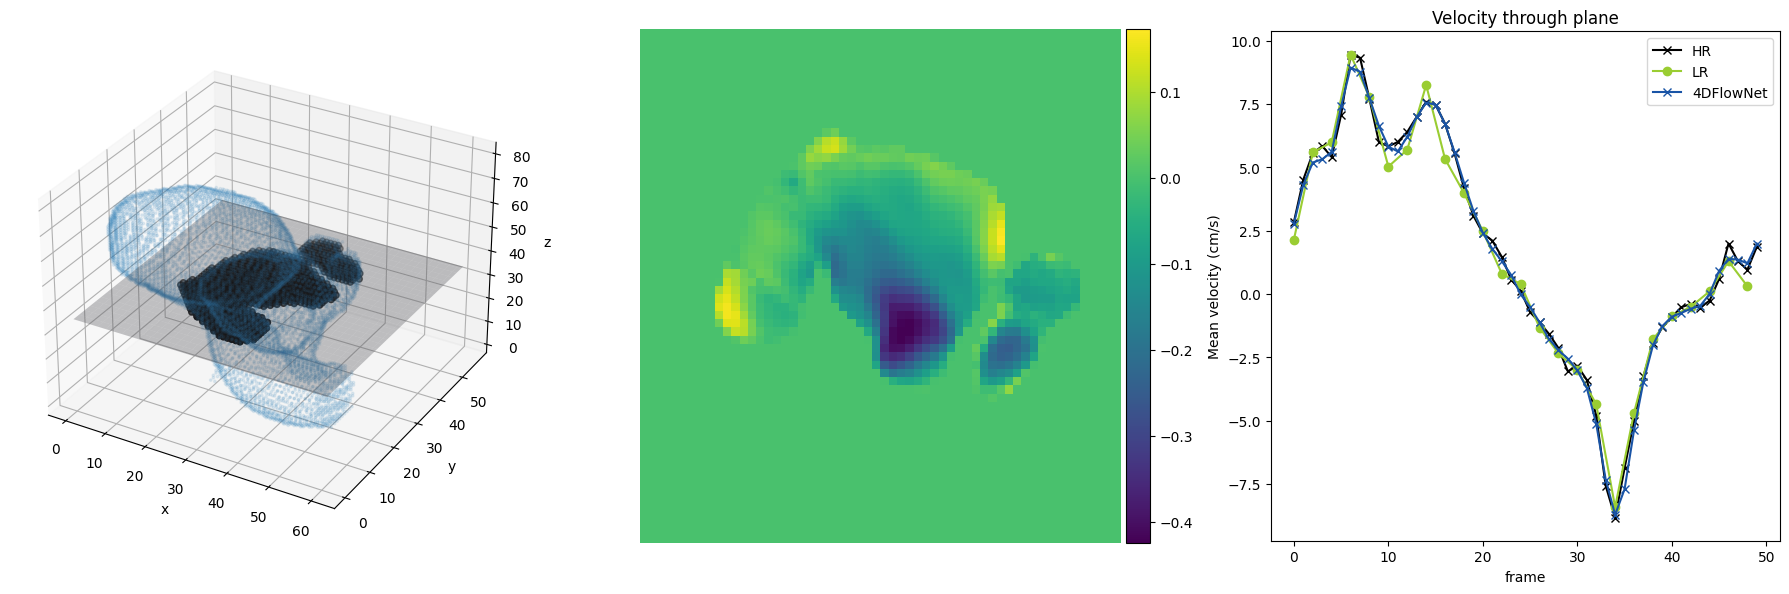

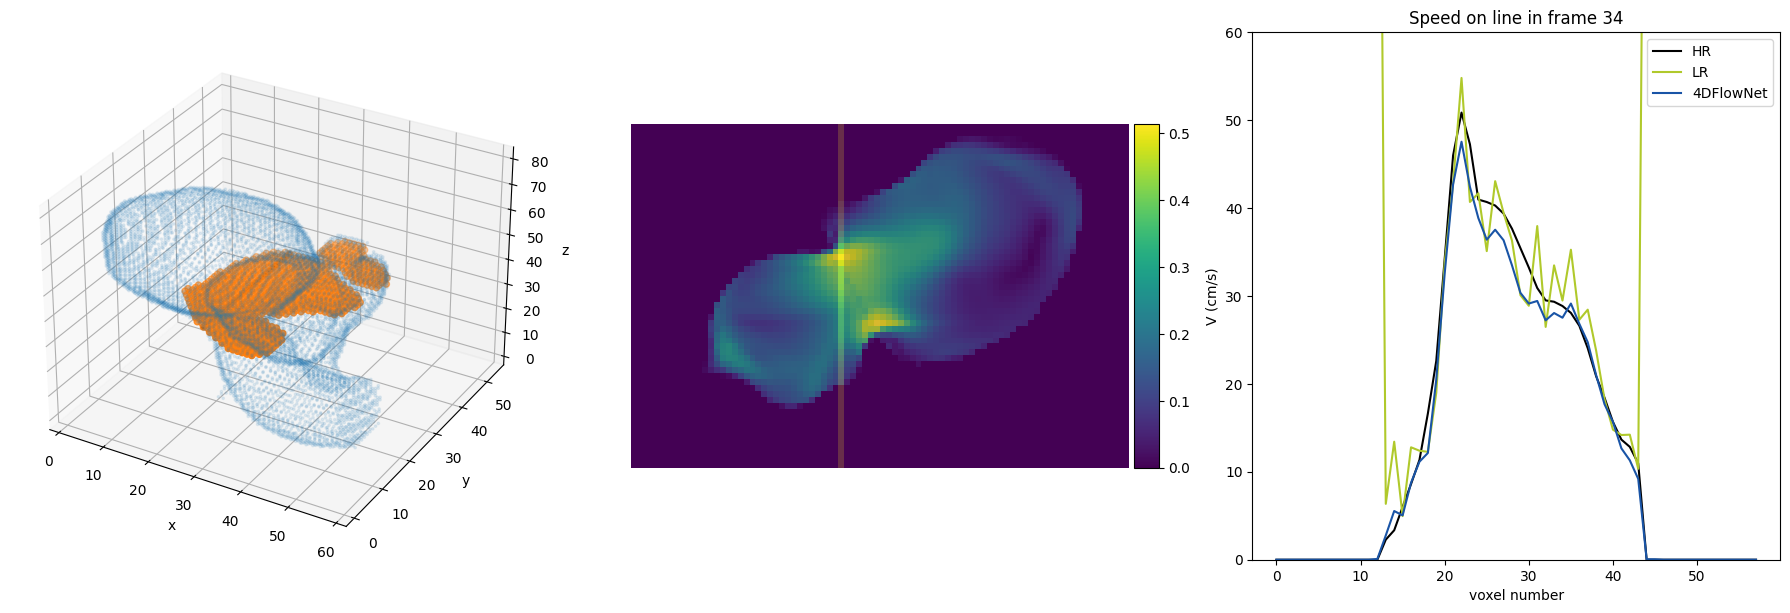

In [9]:
## Here we want to create a plane trough the body
mask_LV = gt['mask'].copy()

#M1P01
mask_LV[30:, :, :] = 0 #This needs to be adapted for every part
mask_LV[:, 47:, :] = 0
mask_LV[:, :, :35] = 0




from matplotlib.colors import Normalize
t = 35
#plane parameters
point  = np.array([22, 25, 35])
x_line = 22
normal = np.array([0, 0, 1]).astype(float) #[0, -0.5, 1] # [-0.4, -0.5, 1]
normal /= np.linalg.norm(normal) #normalize normal
print('Normal vector norm:', np.linalg.norm(normal))

def plot_mean_speed_plane(idx_intersection_plane_fluid, data, mask, frames, label = '', color = 'black'):
    N_frames = data['u'].shape[0]
    vx_in_plane = data['u'][:, idx_intersection_plane_fluid[0], idx_intersection_plane_fluid[1], idx_intersection_plane_fluid[2]].reshape(N_frames, -1)
    vy_in_plane = data['v'][:, idx_intersection_plane_fluid[0], idx_intersection_plane_fluid[1], idx_intersection_plane_fluid[2]].reshape(N_frames, -1)
    vz_in_plane = data['w'][:, idx_intersection_plane_fluid[0], idx_intersection_plane_fluid[1], idx_intersection_plane_fluid[2]].reshape(N_frames, -1)

    #Velocity through plane
    V_plane = vx_in_plane*normal[0]+ vy_in_plane*normal[1]+ vz_in_plane*normal[2]
    mean_speed= np.mean(V_plane, axis = 1)*100
    if N_frames != frames:
        plt.plot(range(frames)[::2], mean_speed,'-o', color = 'yellowgreen', label = label)
    else:
        plt.plot(mean_speed,'-x', label = label, color = color)
    plt.xlabel('frame')
    plt.ylabel('Mean velocity (cm/s)')
    plt.title('Velocity through plane')
    #TODO check that this woukd be teh same for normal vect (0, 0, 1)(1, 0, 0) etc

def plot_line_speed(x_line,frame, data, normal, points_in_plane, label = '', color = 'black'):
    plane_slice = points_in_plane[x_line, :, :]

    idx_line_p = np.where(plane_slice == 1)
    # Get points
    line_points_idx = np.index_exp[frame, x_line, idx_line_p[0], idx_line_p[1]]

    V_line = data[line_points_idx]*100#np.sqrt(data['u'][line_points_idx]**2+ data['v'][line_points_idx]**2+ data['w'][line_points_idx]**2) *100#(data['u'][line_points_idx]*normal[0]+ data['v'][line_points_idx]*normal[1]+ data['w'][line_points_idx]*normal[2]) *100
    #project
    plt.plot(V_line, label = label, color = color)
    plt.xlabel('voxel number')
    plt.ylabel('V (cm/s)')
    plt.title(f'Speed on line in frame {frame}')



#get points for plotting model
x_bounds, y_bounds, z_bounds = np.where(bounds[t, :, :,:]==1)

# a plane is a*x+b*y+c*z+d=0
# [a,b,c] is the normal. Thus, we have to calculate
# d and we're set
d = -point.dot(normal)

# create x,y
xx, yy = np.meshgrid(range(0, gt['u'].shape[1]), range(0, gt['u'].shape[2]))

# calculate corresponding z
#TODO check if this is correct
zz = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]


#points in plane: 3D data, 1 where plane is, 0 where no plane
points_in_plane = np.zeros_like(gt['mask'][t])
points_in_plane[xx.flatten().astype(int), yy.flatten().astype(int), zz.flatten().astype(int)] = 1
# points_in_plane[x_line, np.where(points_in_plane[x_line, :, :]==1)[0], np.where(points_in_plane[x_line, :, :]==1)[1]] = 2 # set points to 2 which lie on a line

#3D model: ist just 1 in region, where plane AND fluid region is
points_plane_core = points_in_plane.copy()
points_plane_core[np.where(gt['mask'][t]==0)] = 0
points_plane_core[x_line, np.where(points_plane_core[x_line, :, :]==1)[0], np.where(points_plane_core[x_line, :, :]==1)[1]] = 2 # set points to 2 which lie on a line

#get indices
idx_intersec_plane_fluid = np.where(points_plane_core>0)

idx_plane =  np.where(points_in_plane>0)

intersec_plane_LV = mask_LV.copy()
intersec_plane_LV[np.where(points_plane_core == 1)] +=1
# intersec_plane_LV[np.where(inter)]
idx_intersec_plane_fluid_LV = np.where(intersec_plane_LV==2)


vx_in_plane = gt['u'][t][idx_plane].reshape(xx.shape[1], -1) 
vy_in_plane = gt['v'][t][idx_plane].reshape(xx.shape[1], -1)
vz_in_plane = gt['w'][t][idx_plane].reshape(xx.shape[1], -1)

#Velocity through plane
V_plane = vx_in_plane*normal[0]+ vy_in_plane*normal[1]+ vz_in_plane*normal[2]

## ----------------Plane Plot -------------------------
fig = plt.figure(figsize=(18,8))

ax = fig.add_subplot(1, 3, 1, projection='3d')
#plot 1
xp, yp, zp = idx_intersec_plane_fluid
xl, yl, zl = np.where(points_plane_core ==2) 
ax.plot_surface(xx, yy, zz, alpha = 0.33, color = KTH_colors['grey80']) # plot plane
ax.scatter3D(x_bounds, y_bounds, z_bounds, s= 3, alpha = 0.1) #plot boundary points
ax.scatter3D(xl, yl, zl, color = 'black') # [frame, x_line, :, :]
# ax.scatter3D(point[0], point[1], point[2],'x', color = 'red') #show point in plane
ax.scatter3D(xp, yp, zp, color = 'black') # plot point which intersect core region and plane

# ax.scatter3D(idx_intersec_plane_fluid_LV[0], idx_intersec_plane_fluid_LV[1], idx_intersec_plane_fluid_LV[2], color = 'black')
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')

#plot 2
ax = fig.add_subplot(1, 3, 2)
ax = plt.gca()
im_plane = plt.imshow(V_plane)
line_plane = points_plane_core[idx_plane].reshape(xx.shape[1], -1)
print(line_plane.shape, np.unique(line_plane))
# plt.imshow(line_plane, alpha= 0.4)
plt.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im_plane, cax=cax)


ax3 = fig.add_subplot(1, 3, 3,)

plot_mean_speed_plane(idx_intersec_plane_fluid, gt, gt['mask'], frames = gt['u'].shape[0], label = 'HR', color= 'black')
plot_mean_speed_plane(idx_intersec_plane_fluid, lr, gt['mask'], frames = gt['u'].shape[0], label = 'LR', color = KTH_colors['grey100'])
plot_mean_speed_plane(idx_intersec_plane_fluid, pred, gt['mask'], frames = gt['u'].shape[0], label = '4DFlowNet', color = KTH_colors['blue100'])
asp = np.diff(ax3.get_xlim())[0] / np.diff(ax3.get_ylim())[0]
ax3.set_aspect(asp)
plt.legend()
plt.tight_layout()
plt.savefig(f'{eval_dir}/Velocity_through_plane_3D_img_meanV.svg',bbox_inches='tight')

plt.show()
## -------------- Line Plot -------------------

t = 34

fig = plt.figure(figsize=(18,8))

ax = fig.add_subplot(1, 3, 1, projection='3d')
#plot 1
xp, yp, zp = idx_intersec_plane_fluid
xl, yl, zl = np.where(points_plane_core ==2) 
# ax.plot_surface(xx, yy, zz, alpha = 0.33, color = 'red') # plot plane
ax.scatter3D(x_bounds, y_bounds, z_bounds, s= 3, alpha = 0.1) #plot boundary points
 # [frame, x_line, :, :]
# ax.scatter3D(point[0], point[1], point[2],'x', color = 'red') #show point in plane
ax.scatter3D(xp, yp, zp) # plot point which intersect core region and plane
ax.scatter3D(xl, yl, zl, color = 'black', s =10)
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')

#plot 2
ax = fig.add_subplot(1, 3, 2)
ax = plt.gca()
im_slice = plt.imshow(gt['speed'][t, x_line, :, :])
plt.axis('off')
plt.imshow(points_in_plane[x_line, :, :], alpha= 0.2)

x_check, y_check = np.where(points_plane_core[x_line, :, :] == 1)
plt.scatter(x_check, y_check) 
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im_slice, cax=cax)


ax3 = fig.add_subplot(1, 3, 3,)

plot_line_speed(x_line,t, gt['speed'], normal, points_in_plane, label = 'HR', color= 'black')
if t%2 ==0:plot_line_speed(x_line,t//2, lr['speed'], normal, points_in_plane, label = 'LR', color = KTH_colors['green100'])
plot_line_speed(x_line,t, pred['speed'], normal, points_in_plane, label = '4DFlowNet', color = KTH_colors['blue100'])
plt.ylim((0, 60))
asp = np.diff(ax3.get_xlim())[0] / np.diff(ax3.get_ylim())[0]
ax3.set_aspect(asp)
plt.legend()

plt.savefig(f'{eval_dir}/Velocity_through_line_3D_img_meanV.png',bbox_inches='tight')


plt.tight_layout()
plt.show()


### Find plane 

In [10]:
## Here we want to create a plane trough the body
mask_LV = gt['mask'].copy()

#M1P01
mask_LV[30:, :, :] = 0 #This needs to be adapted for every part
mask_LV[:, 47:, :] = 0
mask_LV[:, :, :35] = 0


def plot_mean_speed_plane(idx_intersection_plane_fluid, data, mask, frames, label = '', color = 'black'):
    N_frames = data['u'].shape[0]
    vx_in_plane = data['u'][:, idx_intersection_plane_fluid[0], idx_intersection_plane_fluid[1], idx_intersection_plane_fluid[2]].reshape(N_frames, -1)
    vy_in_plane = data['v'][:, idx_intersection_plane_fluid[0], idx_intersection_plane_fluid[1], idx_intersection_plane_fluid[2]].reshape(N_frames, -1)
    vz_in_plane = data['w'][:, idx_intersection_plane_fluid[0], idx_intersection_plane_fluid[1], idx_intersection_plane_fluid[2]].reshape(N_frames, -1)

    #Velocity through plane
    V_plane = vx_in_plane*normal[0]+ vy_in_plane*normal[1]+ vz_in_plane*normal[2]
    mean_speed= np.mean(V_plane, axis = 1)*100
    if N_frames != frames:
        plt.plot(range(frames)[::2], mean_speed,'.-', color = 'yellowgreen', label = label)
    else:
        plt.plot(mean_speed,'.-', label = label, color = color)
    plt.xlabel('frame')
    plt.ylabel('Mean velocity (cm/s)')
    plt.title('Velocity through plane')
    #TODO check that this woukd be teh same for normal vect (0, 0, 1)(1, 0, 0) etc

def rmse_plane(idx_intersection_plane_fluid, data,gt,  label = '', color = 'black'):
    N_frames = data['u'].shape[0]
    vx_in_plane = data['u'][:, idx_intersection_plane_fluid[0], idx_intersection_plane_fluid[1], idx_intersection_plane_fluid[2]].reshape(N_frames, -1)
    vy_in_plane = data['v'][:, idx_intersection_plane_fluid[0], idx_intersection_plane_fluid[1], idx_intersection_plane_fluid[2]].reshape(N_frames, -1)
    vz_in_plane = data['w'][:, idx_intersection_plane_fluid[0], idx_intersection_plane_fluid[1], idx_intersection_plane_fluid[2]].reshape(N_frames, -1)

    vx_in_plane_gt = gt['u'][:, idx_intersection_plane_fluid[0], idx_intersection_plane_fluid[1], idx_intersection_plane_fluid[2]].reshape(N_frames, -1)
    vy_in_plane_gt = gt['v'][:, idx_intersection_plane_fluid[0], idx_intersection_plane_fluid[1], idx_intersection_plane_fluid[2]].reshape(N_frames, -1)
    vz_in_plane_gt = gt['w'][:, idx_intersection_plane_fluid[0], idx_intersection_plane_fluid[1], idx_intersection_plane_fluid[2]].reshape(N_frames, -1)


    V_plane_pred = vx_in_plane*normal[0]+ vy_in_plane*normal[1]+ vz_in_plane*normal[2]
    V_plane_gt = vx_in_plane_gt*normal[0]+ vy_in_plane_gt*normal[1]+ vz_in_plane_gt*normal[2]
    rmse = np.sqrt(np.mean((V_plane_pred-V_plane_gt)**2, axis = 1))
    plt.plot(rmse,'.-', label = label, color = color)
    plt.xlabel('frame')
    plt.ylabel('RMSE')


def plot_line_speed(x_line,frame, data, normal, points_in_plane, label = '', color = 'black'):
    plane_slice = points_in_plane[x_line, :, :]

    idx_line_p = np.where(plane_slice == 1)
    # Get points
    line_points_idx = np.index_exp[frame, x_line, idx_line_p[0], idx_line_p[1]]

    V_line = data[line_points_idx]*100#np.sqrt(data['u'][line_points_idx]**2+ data['v'][line_points_idx]**2+ data['w'][line_points_idx]**2) *100#(data['u'][line_points_idx]*normal[0]+ data['v'][line_points_idx]*normal[1]+ data['w'][line_points_idx]*normal[2]) *100
    #project
    plt.plot(V_line, label = label, color = color)
    plt.xlabel('voxel number')
    plt.ylabel('V (cm/s)')
    plt.title(f'Speed on line in frame {frame}')



@widgets.interact(frame=(0, gt["u"].shape[0]-1), point_x =(0, gt["u"].shape[1]-1), point_y=(0, gt["u"].shape[2]-1), point_z =(0, gt["u"].shape[2]-1),  angle = (0, 360))
def f_3Dplot(t=10 , point_x =22, point_y =25, point_z =30, angle = 20):
    normal_x, normal_y, normal_z = 0.3, 0.66, -0.68#-0.2, -0.29, 0.85 #-0.2, -0.29, 0.91
    #plane parameters
    point  = np.array([point_x, point_y, point_z ])#np.array([22, 25, 35])
    normal = np.array([normal_x, normal_y, normal_z]).astype(float) #[0, -0.5, 1] # [-0.4, -0.5, 1]
    normal /= np.linalg.norm(normal) #normalize normal
    #get points for plotting model
    x_bounds, y_bounds, z_bounds = np.where(bounds[t, :, :,:]==1)

    # a plane is a*x+b*y+c*z+d=0
    # [a,b,c] is the normal. Thus, we have to calculate
    # d and we're set
    d = -point.dot(normal)

    # create x,y
    xx, yy = np.meshgrid(range(0, gt['u'].shape[1]), range(0, gt['u'].shape[2]))

    # calculate corresponding z
    #TODO check if this is correct
    zz = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]

    #points in plane: 3D data, 1 where plane is, 0 where no plane
    points_in_plane = np.zeros_like(gt['mask'][t])
    points_in_plane[xx.flatten().astype(int), yy.flatten().astype(int), zz.flatten().astype(int)] = 1
    # points_in_plane[x_line, np.where(points_in_plane[x_line, :, :]==1)[0], np.where(points_in_plane[x_line, :, :]==1)[1]] = 2 # set points to 2 which lie on a line

    #3D model: ist just 1 in region, where plane AND fluid region is
    points_plane_core = points_in_plane.copy()
    points_plane_core[np.where(gt['mask'][t]==0)] = 0
    # points_plane_core[x_line, np.where(points_plane_core[x_line, :, :]==1)[0], np.where(points_plane_core[x_line, :, :]==1)[1]] = 2 # set points to 2 which lie on a line

    #get indices
    idx_intersec_plane_fluid = np.where(points_plane_core>0)

    idx_plane =  np.where(points_in_plane>0)

    # intersec_plane_LV = mask_LV.copy()
    # intersec_plane_LV[np.where(points_plane_core == 1)] +=1
    # intersec_plane_LV[np.where(inter)]
    # idx_intersec_plane_fluid_LV = np.where(intersec_plane_LV==2)


    vx_in_plane = gt['u'][t][idx_plane].reshape(xx.shape[1], -1) 
    vy_in_plane = gt['v'][t][idx_plane].reshape(xx.shape[1], -1)
    vz_in_plane = gt['w'][t][idx_plane].reshape(xx.shape[1], -1)

    #Velocity through plane
    V_plane = vx_in_plane*normal[0]+ vy_in_plane*normal[1]+ vz_in_plane*normal[2]

    ## ----------------Plane Plot -------------------------
    fig = plt.figure(figsize=(18,8))

    ax = fig.add_subplot(1, 3, 1, projection='3d')
    #plot 1
    a = 30
    xp, yp, zp = idx_intersec_plane_fluid
    xl, yl, zl = np.where(points_plane_core ==2) 
    # x_point, y_point_z_point = np.where(points_plane_core ==1)
    ax.plot_surface(xx, yy, zz, alpha = 0.33, color = KTH_colors['grey80']) # plot plane
    ax.scatter3D(x_bounds, y_bounds, z_bounds, s= 3, alpha = 0.1) #plot boundary points
    # ax.scatter3D(xl, yl, zl, color = 'black', alpha = 0.1, s=1) # [frame, x_line, :, :]
    ax.scatter3D(point[0], point[1], point[2],'x', color = 'red') #show point in plane
    ax.scatter3D(xp, yp, zp, color = 'black', alpha = 0.2) # plot point which intersect core region and plane
    ax.plot([normal_x*a, 0], [normal_y*a, 0], [normal_z*a, 0], color = 'black')

    # ax.scatter3D(idx_intersec_plane_fluid_LV[0], idx_intersec_plane_fluid_LV[1], idx_intersec_plane_fluid_LV[2], color = 'black')
    plt.xlabel('x')
    plt.ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(15, angle)

    #plot 2
    ax = fig.add_subplot(1, 3, 2)
    ax = plt.gca()
    im_plane = plt.imshow(V_plane)
    line_plane = points_plane_core[idx_plane].reshape(xx.shape[1], -1)
    print(line_plane.shape, np.unique(line_plane))
    # plt.imshow(line_plane, alpha= 0.4)
    plt.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im_plane, cax=cax)


    ax3 = fig.add_subplot(1, 3, 3,)

    plot_mean_speed_plane(idx_intersec_plane_fluid, gt, gt['mask'], frames = gt['u'].shape[0], label = 'HR', color= KTH_colors['grey40'])
    plot_mean_speed_plane(idx_intersec_plane_fluid, lr, gt['mask'], frames = gt['u'].shape[0], label = 'LR', color = KTH_colors['grey100'])
    plot_mean_speed_plane(idx_intersec_plane_fluid, pred, gt['mask'], frames = gt['u'].shape[0], label = '4DFlowNet', color = KTH_colors['blue100'])
    asp = np.diff(ax3.get_xlim())[0] / np.diff(ax3.get_ylim())[0]
    ax3.set_aspect(asp)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{eval_dir}/Velocity_through_plane_3D_img_meanV.svg',bbox_inches='tight')

plt.show()

# good reults:
# point 22, 25, 35
# normal -0.2, -0.29, 0.85

#better: 
#point: 22, 25, 30
# normal:  0.3, 0.66, -0.68

interactive(children=(IntSlider(value=10, description='t', max=30, min=-10), IntSlider(value=22, description='…

## Make plot here with right parameters

240
(62, 58) [0 1]


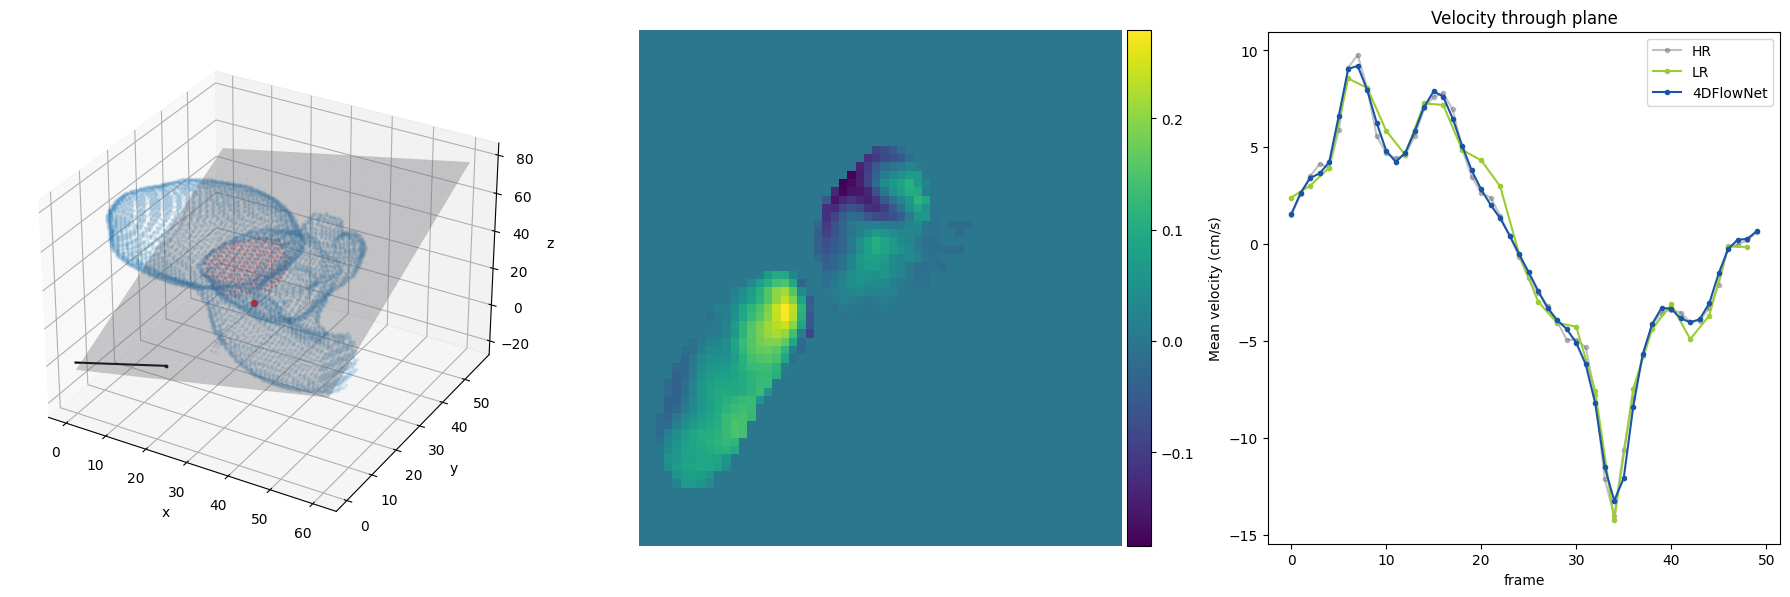

mean abs deviation- 4dflownet 0.28382301330566406
mean abs deviation -lr 0.5558273196220398


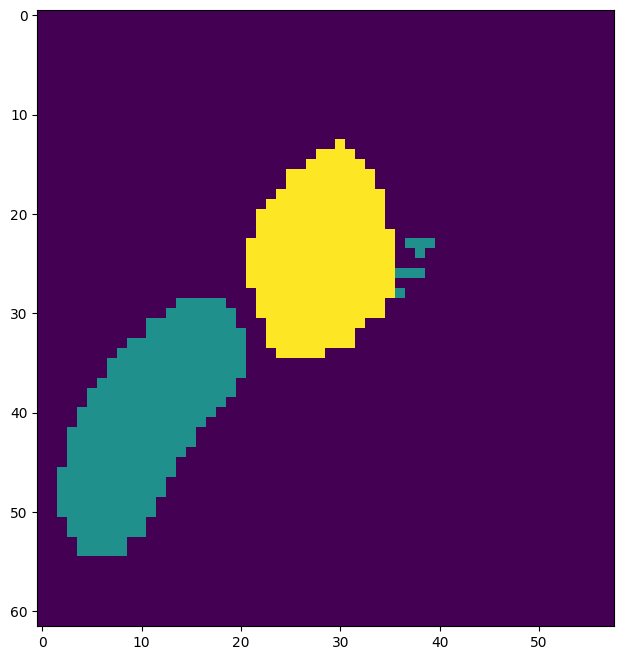

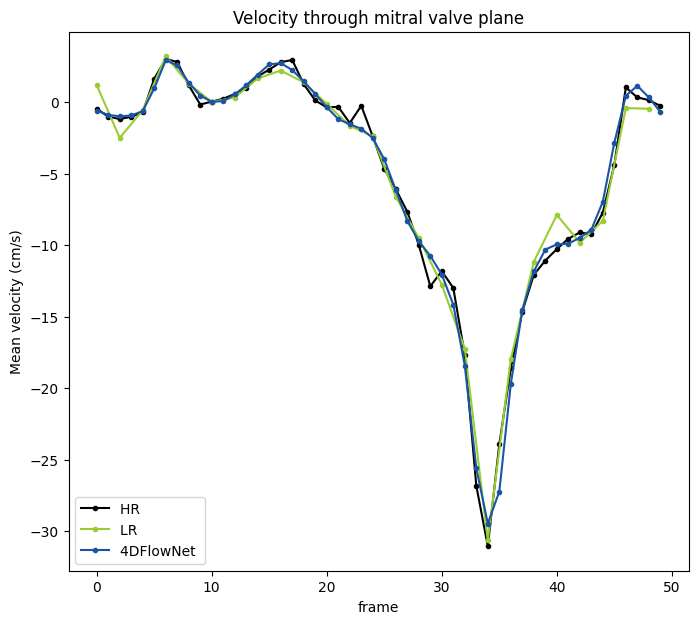

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RMSE MAX 0.035957605
abs max speed [21.52865   21.235062  20.22703   19.278734  18.394999  33.645847
 92.0069    93.38345   69.642685  44.24065   43.914978  49.915752
 54.03292   56.86189   65.71372   71.19665   74.52762   74.677315
 66.31447   52.822792  36.001625  19.71331    8.474853   7.6348586
  8.458245  10.278879  11.530535  12.73374   14.890674  18.545155
 18.180033  18.944057  26.847107  46.588524  50.807102  36.258526
 30.345589  25.573635  24.406082  29.956228  42.68484   44.93852
 41.932125  40.14318   37.610413  34.07757   29.237091  29.13508
 28.038061  23.716442 ]
abs max speed [132.44984  101.73204   20.146687  91.53891   71.90988   43.174995
  46.200752  65.59967   84.78137   75.79941   38.187317  70.639885
  53.46585  178.35287   50.902016 115.360275  81.016205 155.41368
  90.7484   152.41112  175.15887  101.219955 215.77925  151.04128
 116.189026]
abs max speed [21.882538  20.874905  20.194855  19.180147  17.570148  48.258743
 88.21772   85.084984  70.27721   53.3339

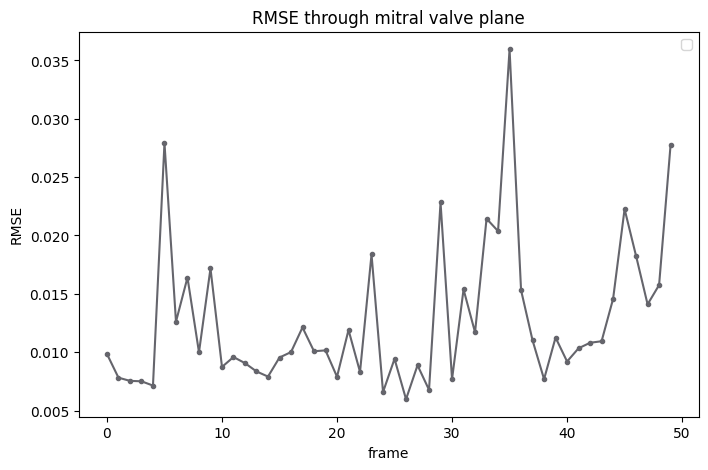

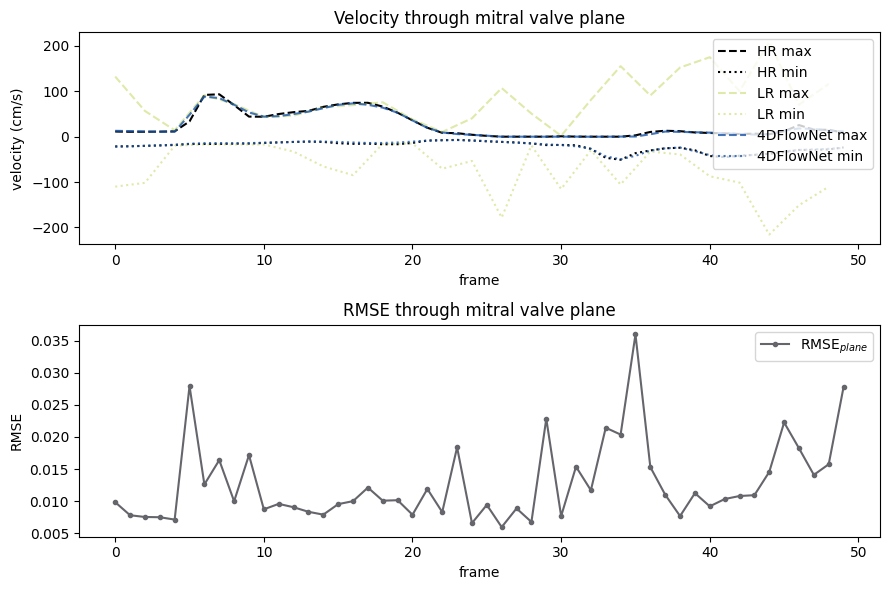

MAX ABS DIFF - pred 0.15295197069644928 
(50, 240) (50, 240) (25, 240)
- lr 2.157792568206787
abs max speed [21.52865   21.235062  20.22703   19.278734  18.394999  33.645847
 92.0069    93.38345   69.642685  44.24065   43.914978  49.915752
 54.03292   56.86189   65.71372   71.19665   74.52762   74.677315
 66.31447   52.822792  36.001625  19.71331    8.474853   7.6348586
  8.458245  10.278879  11.530535  12.73374   14.890674  18.545155
 18.180033  18.944057  26.847107  46.588524  50.807102  36.258526
 30.345589  25.573635  24.406082  29.956228  42.68484   44.93852
 41.932125  40.14318   37.610413  34.07757   29.237091  29.13508
 28.038061  23.716442 ]
abs max speed [132.44984  101.73204   20.146687  91.53891   71.90988   43.174995
  46.200752  65.59967   84.78137   75.79941   38.187317  70.639885
  53.46585  178.35287   50.902016 115.360275  81.016205 155.41368
  90.7484   152.41112  175.15887  101.219955 215.77925  151.04128
 116.189026]
abs max speed [21.882538  20.874905  20.194855  

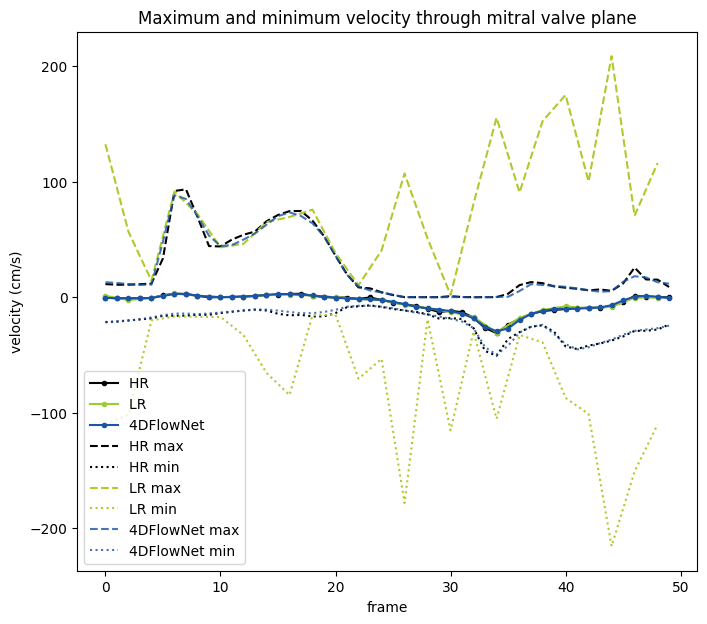

In [11]:
mask_LV = gt['mask'].copy()

def vel_plane(idx_intersection_plane_fluid, data, normal):
    N_frames = data['u'].shape[0]
    vx_in_plane = data['u'][:, idx_intersection_plane_fluid[0], idx_intersection_plane_fluid[1], idx_intersection_plane_fluid[2]].reshape(N_frames, -1)
    vy_in_plane = data['v'][:, idx_intersection_plane_fluid[0], idx_intersection_plane_fluid[1], idx_intersection_plane_fluid[2]].reshape(N_frames, -1)
    vz_in_plane = data['w'][:, idx_intersection_plane_fluid[0], idx_intersection_plane_fluid[1], idx_intersection_plane_fluid[2]].reshape(N_frames, -1)
    return vx_in_plane*normal[2]+ vy_in_plane*normal[1]+ vz_in_plane*normal[0]


def rmse_plane(idx_intersection_plane_fluid, data,gt,  label = '', color = 'black'):
    N_frames = data['u'].shape[0]
    vx_in_plane = data['u'][:, idx_intersection_plane_fluid[0], idx_intersection_plane_fluid[1], idx_intersection_plane_fluid[2]].reshape(N_frames, -1)
    vy_in_plane = data['v'][:, idx_intersection_plane_fluid[0], idx_intersection_plane_fluid[1], idx_intersection_plane_fluid[2]].reshape(N_frames, -1)
    vz_in_plane = data['w'][:, idx_intersection_plane_fluid[0], idx_intersection_plane_fluid[1], idx_intersection_plane_fluid[2]].reshape(N_frames, -1)

    vx_in_plane_gt = gt['u'][:, idx_intersection_plane_fluid[0], idx_intersection_plane_fluid[1], idx_intersection_plane_fluid[2]].reshape(N_frames, -1)
    vy_in_plane_gt = gt['v'][:, idx_intersection_plane_fluid[0], idx_intersection_plane_fluid[1], idx_intersection_plane_fluid[2]].reshape(N_frames, -1)
    vz_in_plane_gt = gt['w'][:, idx_intersection_plane_fluid[0], idx_intersection_plane_fluid[1], idx_intersection_plane_fluid[2]].reshape(N_frames, -1)


    V_plane_pred = vx_in_plane*normal[2]+ vy_in_plane*normal[1]+ vz_in_plane*normal[0]
    V_plane_gt = vx_in_plane_gt*normal[2]+ vy_in_plane_gt*normal[1]+ vz_in_plane_gt*normal[0]
    rmse = np.sqrt(np.mean((V_plane_pred-V_plane_gt)**2, axis = 1))
    print('RMSE MAX', np.max(rmse))
    plt.plot(rmse,'.-', label = label, color = color)
    plt.xlabel('frame')
    plt.ylabel('RMSE')

#TODO delete this later
def plot_mean_speed_plane(idx_intersection_plane_fluid, data, mask, frames, label = '', color = 'black'):
    N_frames = data['u'].shape[0]
    vx_in_plane = data['u'][:, idx_intersection_plane_fluid[0], idx_intersection_plane_fluid[1], idx_intersection_plane_fluid[2]].reshape(N_frames, -1)
    vy_in_plane = data['v'][:, idx_intersection_plane_fluid[0], idx_intersection_plane_fluid[1], idx_intersection_plane_fluid[2]].reshape(N_frames, -1)
    vz_in_plane = data['w'][:, idx_intersection_plane_fluid[0], idx_intersection_plane_fluid[1], idx_intersection_plane_fluid[2]].reshape(N_frames, -1)

    #Velocity through plane
    V_plane = vx_in_plane*normal[2]+ vy_in_plane*normal[1]+ vz_in_plane*normal[0]
    mean_speed= np.mean(V_plane, axis = 1)*100
    if N_frames != frames:
        plt.plot(range(frames)[::2], mean_speed,'.-', color = 'yellowgreen', label = label)
    else:
        plt.plot(mean_speed,'.-', label = label, color = color)
    plt.xlabel('frame')
    plt.ylabel('Mean velocity (cm/s)')
    plt.title('Velocity through plane')
    return mean_speed
    #TODO check that this woukd be teh same for normal vect (0, 0, 1)(1, 0, 0) etc

def plot_max_speed_plane(idx_intersection_plane_fluid, data, mask, frames, label = '', color = 'black'):
    N_frames = data['u'].shape[0]
    vx_in_plane = data['u'][:, idx_intersection_plane_fluid[0], idx_intersection_plane_fluid[1], idx_intersection_plane_fluid[2]].reshape(N_frames, -1)
    vy_in_plane = data['v'][:, idx_intersection_plane_fluid[0], idx_intersection_plane_fluid[1], idx_intersection_plane_fluid[2]].reshape(N_frames, -1)
    vz_in_plane = data['w'][:, idx_intersection_plane_fluid[0], idx_intersection_plane_fluid[1], idx_intersection_plane_fluid[2]].reshape(N_frames, -1)

    #Velocity through plane
    V_plane = vx_in_plane*normal[2]+ vy_in_plane*normal[1]+ vz_in_plane*normal[0]
    max_speed= np.max(V_plane, axis = 1)*100
    min_speed = np.min(V_plane, axis = 1)*100
    # print('max speed', max_speed)
    # print('min speed', min_speed)

    abs_max_vel = np.max(np.abs(V_plane), axis = 1)*100
    print('abs max speed', abs_max_vel)
    positive_mask = max_speed >= 0

    res = np.zeros_like(abs_max_vel)
    res[positive_mask] = abs_max_vel[positive_mask]
    res[~positive_mask] = -abs_max_vel[~positive_mask]
    

    if N_frames != frames:
        plt.plot(range(frames)[::2], max_speed,'--', color = color, label = f'{label} max')
        plt.plot(range(frames)[::2], min_speed,':', color = color, label = f'{label} min')
    else:
        plt.plot(max_speed,'--', label = f'{label} max', color = color)
        plt.plot(min_speed,':', label = f'{label} min', color = color)
    plt.xlabel('frame')
    plt.ylabel('velocity (cm/s)')
    plt.title('Velocity through plane')

t = 4
#paraview - 2, 1, 0 since w v u merge vector components
point_x, point_y, point_z = 22, 25, 30
normal_x, normal_y, normal_z = 0.3, 0.66, -0.68 #-0.2, -0.29, 0.85 #-0.2, -0.29, 0.91
#plane parameters
point  = np.array([point_x, point_y, point_z ])#np.array([22, 25, 35])
normal = np.array([normal_x, normal_y, normal_z]).astype(float) #[0, -0.5, 1] # [-0.4, -0.5, 1]
normal /= np.linalg.norm(normal) #normalize normal
#get points for plotting model
x_bounds, y_bounds, z_bounds = np.where(bounds[t, :, :,:]==1)

# a plane is a*x+b*y+c*z+d=0
# [a,b,c] is the normal. Thus, we have to calculate
# d and we're set
d = -point.dot(normal)

# create x,y
xx, yy = np.meshgrid(range(0, gt['u'].shape[1]), range(0, gt['u'].shape[2]))

# calculate corresponding z
#TODO check if this is correct
zz = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]

#points in plane: 3D data, 1 where plane is, 0 where no plane
points_in_plane = np.zeros_like(gt['mask'][t])
points_in_plane[xx.flatten().astype(int), yy.flatten().astype(int), zz.flatten().astype(int)] = 1

#3D model: ist just 1 in region, where plane AND fluid region is
points_plane_core = points_in_plane.copy()
points_plane_core[np.where(gt['mask'][t]==0)] = 0

#3D model: get MV region
points_MV = points_plane_core.copy()
points_MV[:, :, :15] = 0
points_MV[:, :21, :] = 0
points_MV[:, 36:, :] = 0
points_MV[38:, :, :] = 0
# points_MV[:, :, :] = 0

#get indices
idx_intersec_plane_fluid = np.where(points_plane_core>0)
idx_plane =  np.where(points_in_plane>0)
idx_MV = np.where(points_MV>0) 
#

# reshape velocity to 2D plane
vx_in_plane = gt['u'][t][idx_plane].reshape(xx.shape[1], -1) 
vy_in_plane = gt['v'][t][idx_plane].reshape(xx.shape[1], -1)
vz_in_plane = gt['w'][t][idx_plane].reshape(xx.shape[1], -1)

#Velocity through plane
V_plane = vx_in_plane*normal[2]+ vy_in_plane*normal[1]+ vz_in_plane*normal[0]

# V_plane = vx_in_plane*normal[0]+ vy_in_plane*normal[1]+ vz_in_plane*normal[2]

## ----------------Plane Plot -------------------------
fig = plt.figure(figsize=(18,8))

ax = fig.add_subplot(1, 3, 1, projection='3d')
#plot 1
a = 30
xp, yp, zp = idx_intersec_plane_fluid
xl, yl, zl = np.where(points_plane_core ==2) 
x_MV, y_MV, z_MV = np.where(points_MV ==1)
print(np.count_nonzero(points_MV))
# x_point, y_point_z_point = np.where(points_plane_core ==1)
ax.plot_surface(xx, yy, zz, alpha = 0.33, color = KTH_colors['grey80']) # plot plane
ax.scatter3D(x_bounds, y_bounds, z_bounds, s= 3, alpha = 0.1) #plot boundary points

# ax.scatter3D(xl, yl, zl, color = 'black', alpha = 0.1, s=1) # [frame, x_line, :, :]
ax.scatter3D(point[0], point[1], point[2],'x', color = 'red') #show point in plane
# ax.scatter3D(xp, yp, zp, color = 'black', alpha = 0.2) # plot point which intersect core region and plane
ax.plot([normal_x*a, 0], [normal_y*a, 0], [normal_z*a, 0], color = 'black')
ax.scatter3D(normal_x*a, normal_y*a , normal_z*a , s = 3, color = 'black') # plot normal point
ax.scatter3D(x_MV, y_MV, z_MV, alpha = 0.2, s = 3, color = 'red') #plot MV points

# ax.scatter3D(idx_intersec_plane_fluid_LV[0], idx_intersec_plane_fluid_LV[1], idx_intersec_plane_fluid_LV[2], color = 'black')
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')
# ax.view_init(15, 20)

#plot 2
ax = fig.add_subplot(1, 3, 2)
ax = plt.gca()
im_plane = plt.imshow(V_plane)
line_plane = points_plane_core[idx_plane].reshape(xx.shape[1], -1)
print(line_plane.shape, np.unique(line_plane))
# plt.imshow(line_plane, alpha= 0.4)
plt.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im_plane, cax=cax)


ax3 = fig.add_subplot(1, 3, 3,)

mean_hr = plot_mean_speed_plane(idx_intersec_plane_fluid, gt, gt['mask'], frames = gt['u'].shape[0], label = 'HR', color= KTH_colors['grey40'])
mean_lr = plot_mean_speed_plane(idx_intersec_plane_fluid, lr, gt['mask'], frames = gt['u'].shape[0], label = 'LR', color = KTH_colors['grey100'])
mean_pred = plot_mean_speed_plane(idx_intersec_plane_fluid, pred, gt['mask'], frames = gt['u'].shape[0], label = '4DFlowNet', color = KTH_colors['blue100'])
asp = np.diff(ax3.get_xlim())[0] / np.diff(ax3.get_ylim())[0]
ax3.set_aspect(asp)
plt.legend()
plt.tight_layout()
plt.savefig(f'{eval_dir}/Velocity_through_plane_3D_img_meanV.svg',bbox_inches='tight')
plt.show()

print(f'mean abs deviation- 4dflownet {np.abs(mean_hr-mean_pred).mean()}')
print(f'mean abs deviation -lr {np.abs(mean_lr-mean_pred[::2]).mean()}')



img_mask = gt['mask'][t][idx_plane].reshape(xx.shape[1], -1)
img_MV_mask = points_MV[idx_plane].reshape(xx.shape[1], -1)
# plt.imshow(gt['mask'][t][idx_plane].reshape(xx.shape[1], -1))
plt.imshow(img_MV_mask+img_mask)
# plt.imshow(img_MV_mask)
plt.show()

fig = plt.figure(figsize=(8,7))
plot_mean_speed_plane(idx_MV, gt, gt['mask'], frames = gt['u'].shape[0], label = 'HR ', color= 'black')
plot_mean_speed_plane(idx_MV, lr, gt['mask'], frames = gt['u'].shape[0], label = 'LR ', color = KTH_colors['grey100'])
plot_mean_speed_plane(idx_MV, pred, gt['mask'], frames = gt['u'].shape[0], label = '4DFlowNet ', color = KTH_colors['blue100'])
plt.title('Velocity through mitral valve plane')
plt.legend()
plt.savefig(f'{eval_dir}/Velocity_through_plane_3D_img_meanV_MV_region.svg',bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(8,5))
rmse_plane(idx_MV, pred,gt,  label = '', color = KTH_colors['grey100'])
plt.legend()
plt.title('RMSE through mitral valve plane')
plt.savefig(f'{eval_dir}/RMSE_through_plane_3D_img_meanV_MV_region.svg',bbox_inches='tight')


fig = plt.figure(figsize=(9,6))

plt.subplot(2, 1, 1)
plot_max_speed_plane(idx_MV, gt, gt['mask'], frames = gt['u'].shape[0], label = 'HR', color= 'black')
plot_max_speed_plane(idx_MV, lr, gt['mask'], frames = gt['u'].shape[0], label = 'LR', color = KTH_colors['green40'])
plot_max_speed_plane(idx_MV, pred, gt['mask'], frames = gt['u'].shape[0], label = '4DFlowNet', color = KTH_colors['blue80'])
# plt.title('Maximum velocity through mitral valve plane')
# plt.legend()

# plt.subplot(3, 1, 2)
# plot_mean_speed_plane(idx_MV, gt, gt['mask'], frames = gt['u'].shape[0], label = 'HR average', color= 'black')
# plot_mean_speed_plane(idx_MV, lr, gt['mask'], frames = gt['u'].shape[0], label = 'LR average', color = KTH_colors['grey100'])
# plot_mean_speed_plane(idx_MV, pred, gt['mask'], frames = gt['u'].shape[0], label = '4DFlowNet average', color = KTH_colors['blue100'])
plt.title('Velocity through mitral valve plane')
plt.legend(loc= 'upper right')

plt.subplot(2, 1, 2)
rmse_plane(idx_MV, pred,gt,  label = r'RMSE$_{plane}$', color = KTH_colors['grey100'])
plt.legend()
plt.title('RMSE through mitral valve plane')
plt.tight_layout()
plt.savefig(f'{eval_dir}/Velocity_MinMAx_RMSE_through_plane_3D_img_meanV_MV_region.svg',bbox_inches='tight')
plt.show()

vel_pred = vel_plane(idx_MV, pred, normal)
vel_hr = vel_plane(idx_MV, gt, normal)
vel_lr = vel_plane(idx_MV, lr, normal)
print(f'MAX ABS DIFF - pred {np.max(np.abs(vel_pred-vel_hr))} ')
print(vel_pred.shape, vel_hr.shape, vel_lr.shape)
print(f'- lr {np.max(np.abs(vel_lr-vel_hr[::2]))}')


plt.figure(figsize=(8,7))
#mean speed
plot_mean_speed_plane(idx_MV, gt, gt['mask'], frames = gt['u'].shape[0], label = 'HR ', color= 'black')
plot_mean_speed_plane(idx_MV, lr, gt['mask'], frames = gt['u'].shape[0], label = 'LR ', color = KTH_colors['grey100'])
plot_mean_speed_plane(idx_MV, pred, gt['mask'], frames = gt['u'].shape[0], label = '4DFlowNet ', color = KTH_colors['blue100'])
# max speed
plot_max_speed_plane(idx_MV, gt, gt['mask'], frames = gt['u'].shape[0], label = 'HR', color= 'black')
plot_max_speed_plane(idx_MV, lr, gt['mask'], frames = gt['u'].shape[0], label = 'LR', color = KTH_colors['green100'])
plot_max_speed_plane(idx_MV, pred, gt['mask'], frames = gt['u'].shape[0], label = '4DFlowNet', color = KTH_colors['blue80'])
plt.title('Maximum and minimum velocity through mitral valve plane')
plt.legend()
plt.show()

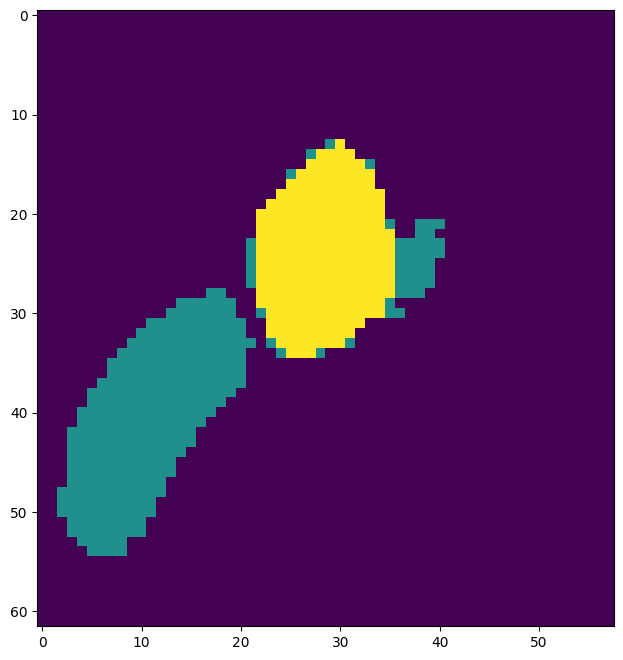

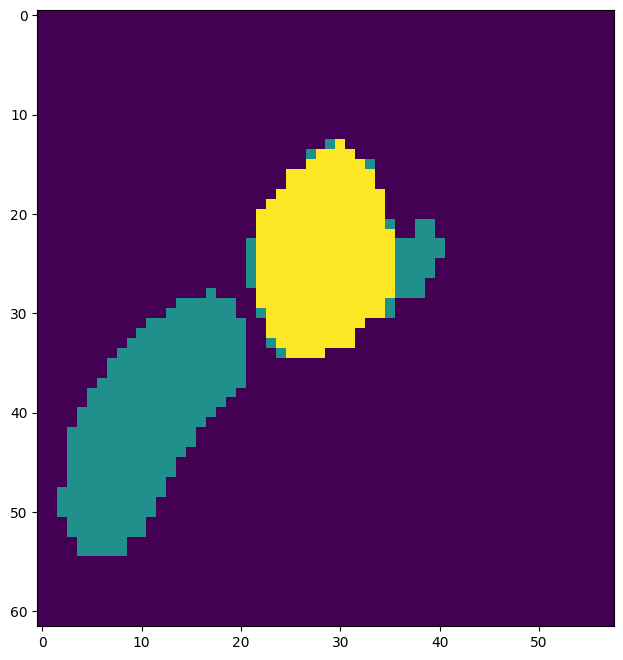

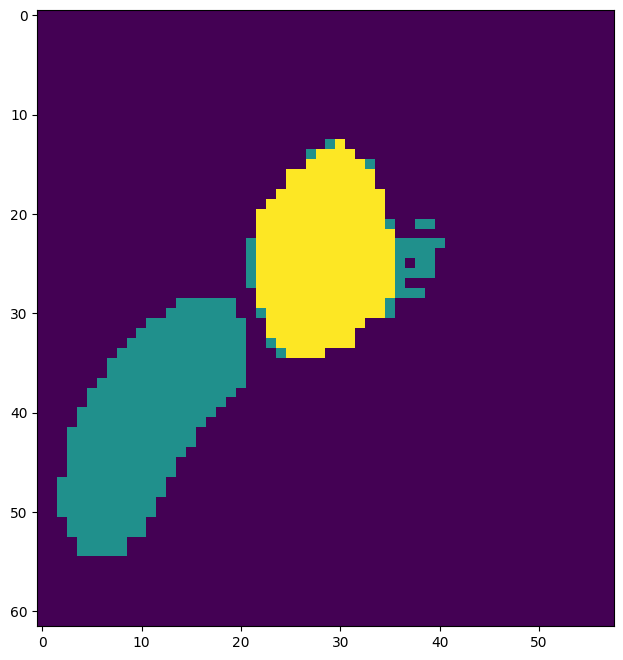

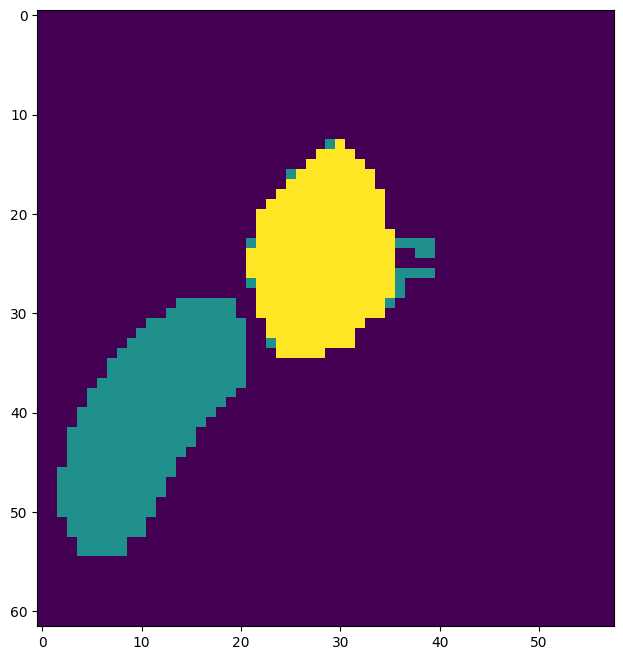

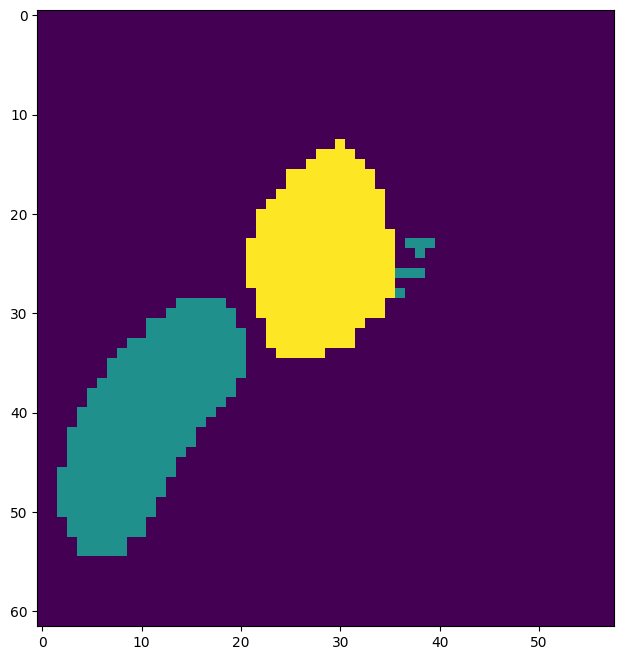

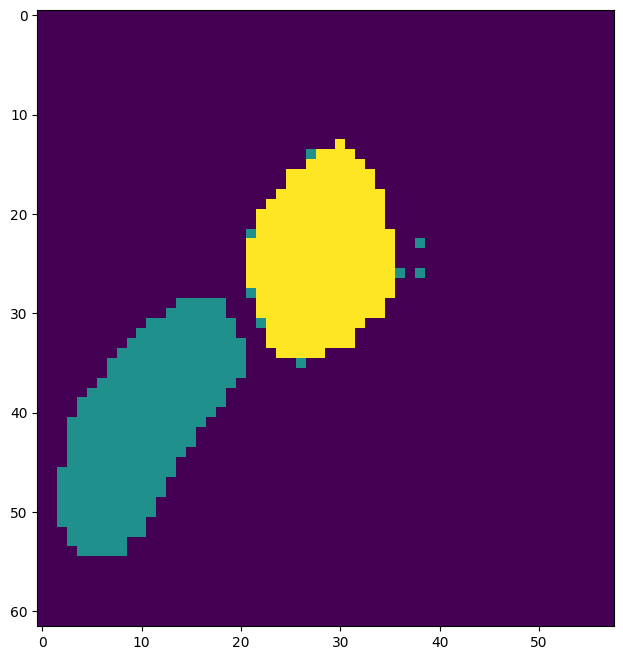

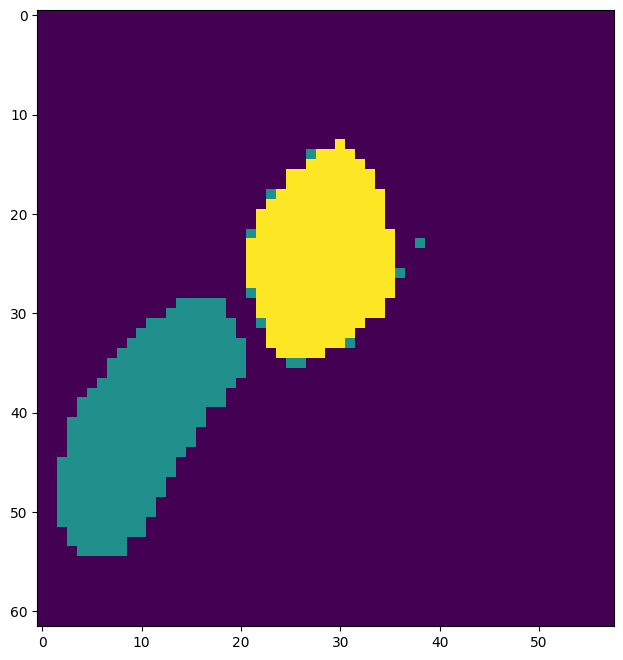

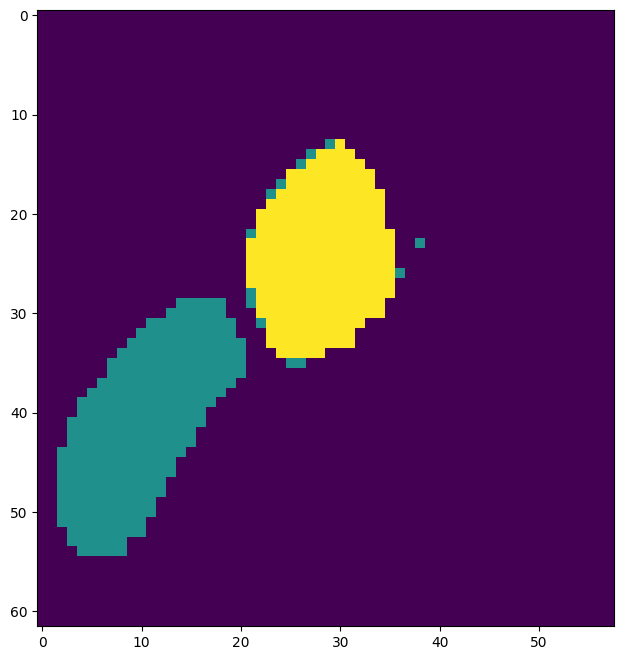

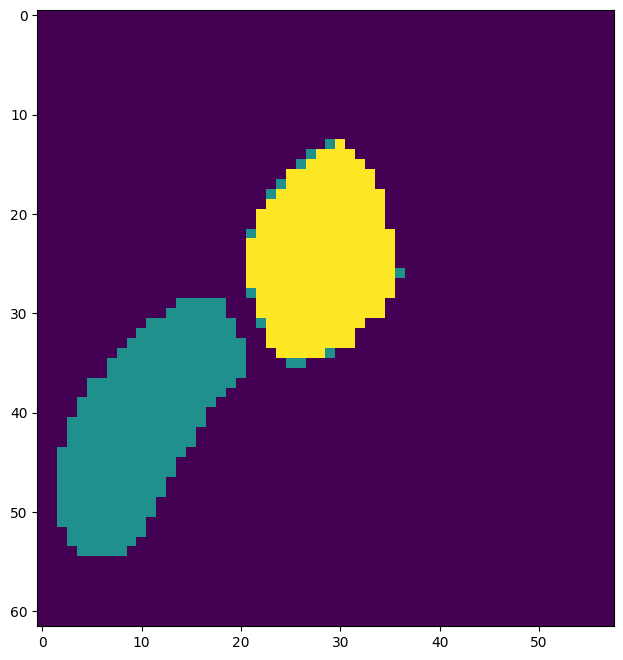

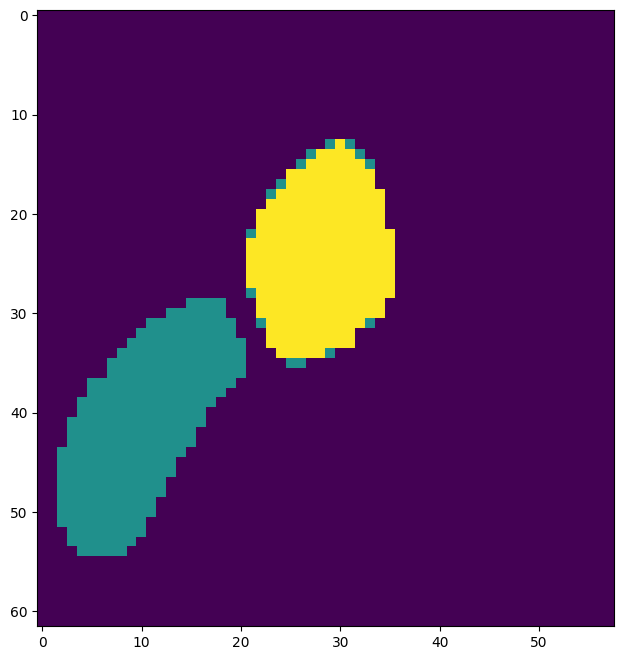

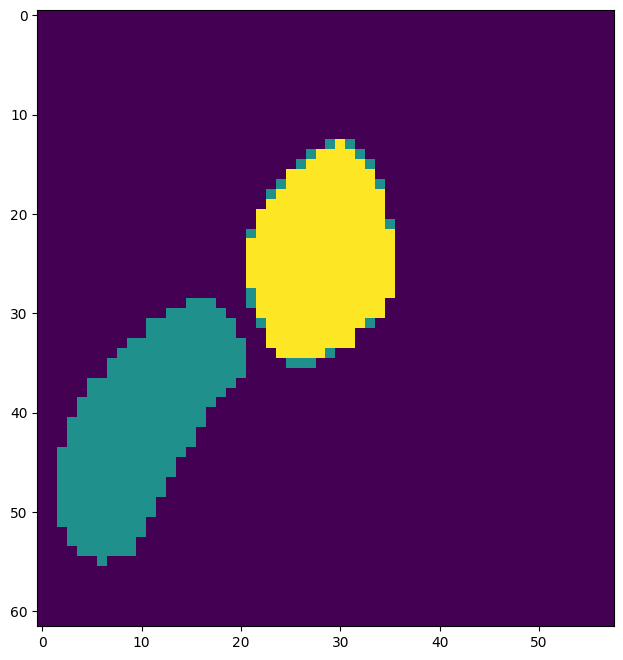

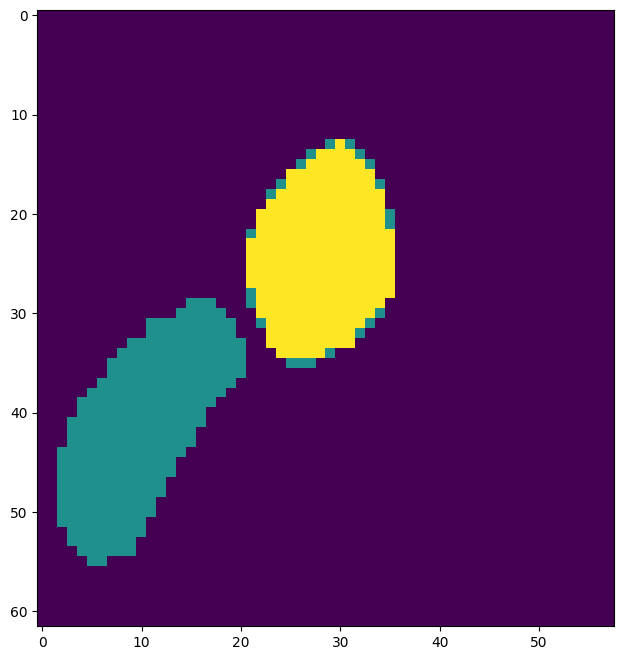

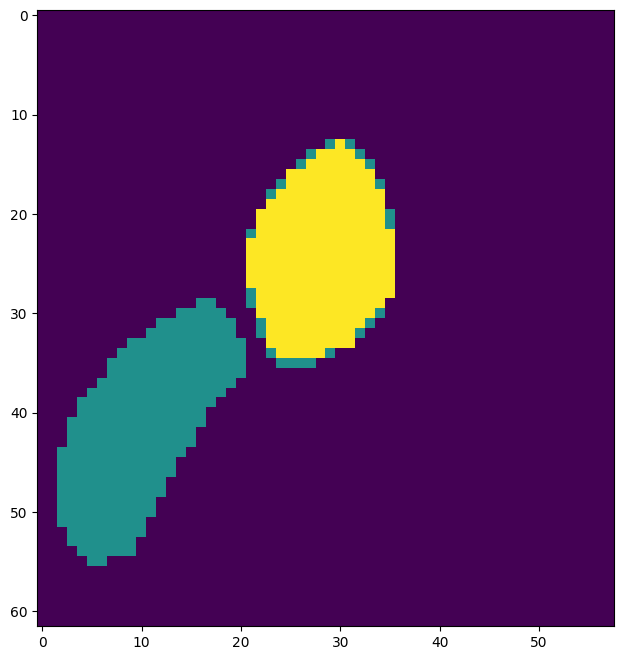

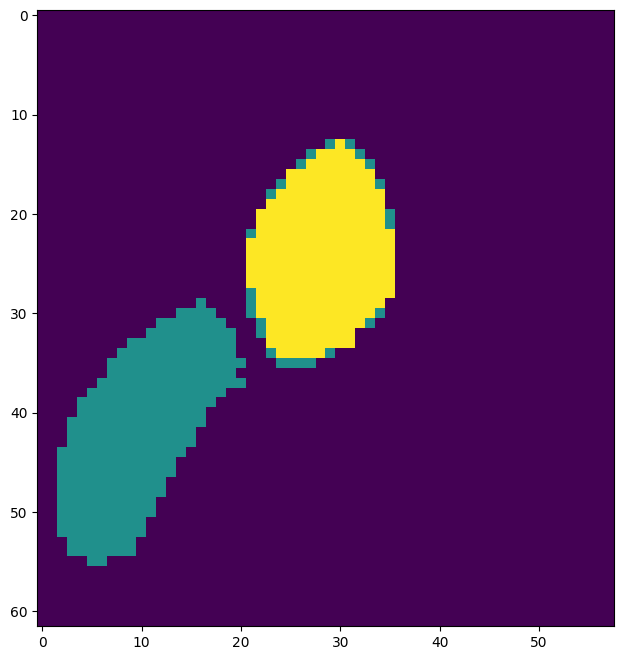

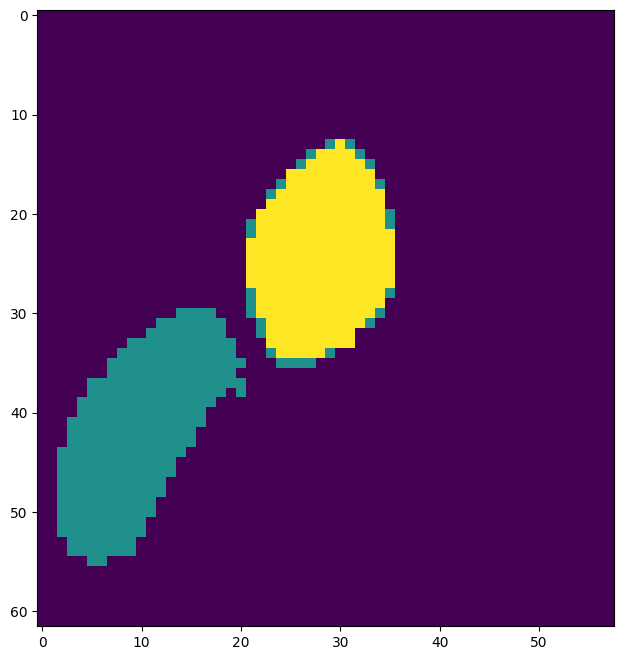

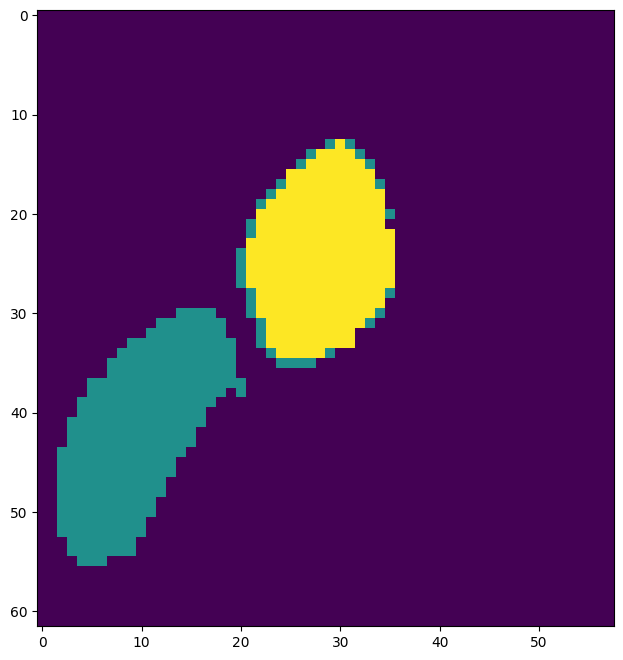

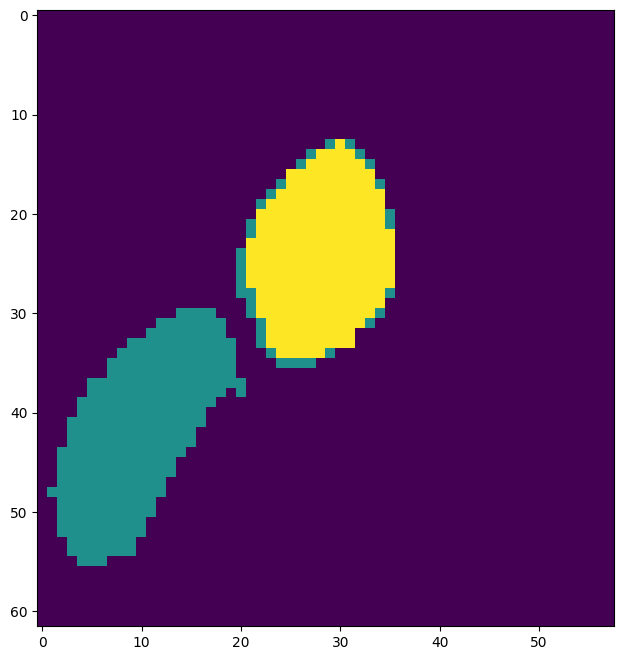

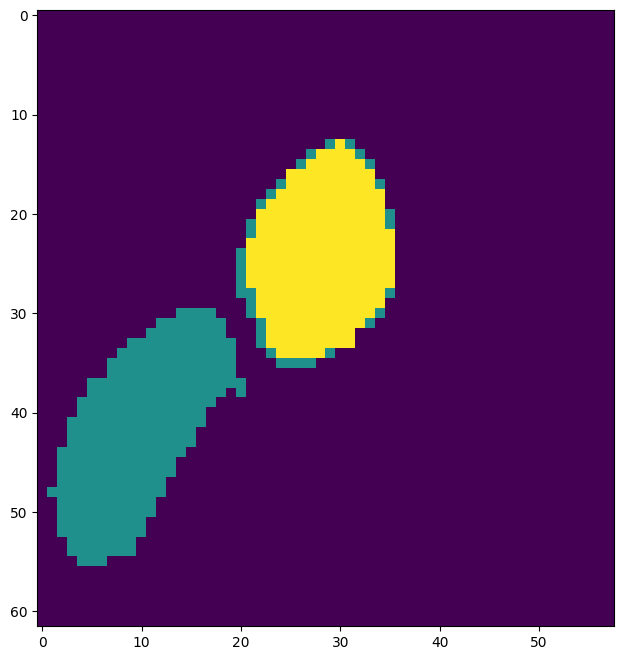

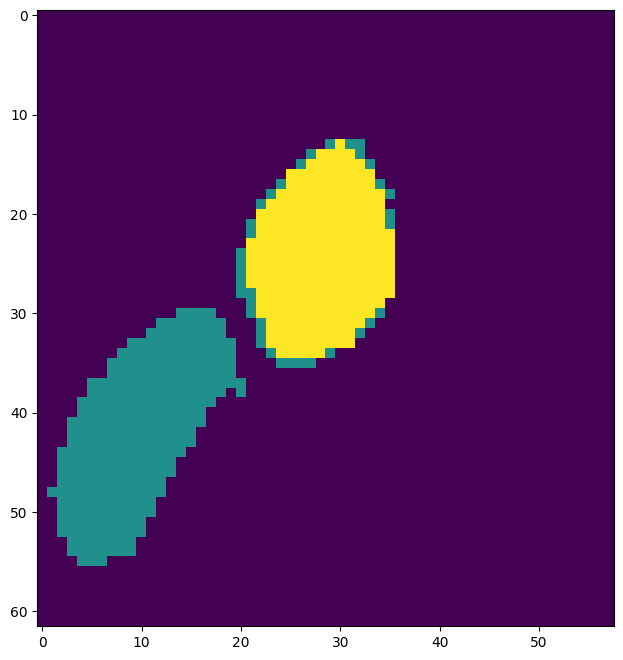

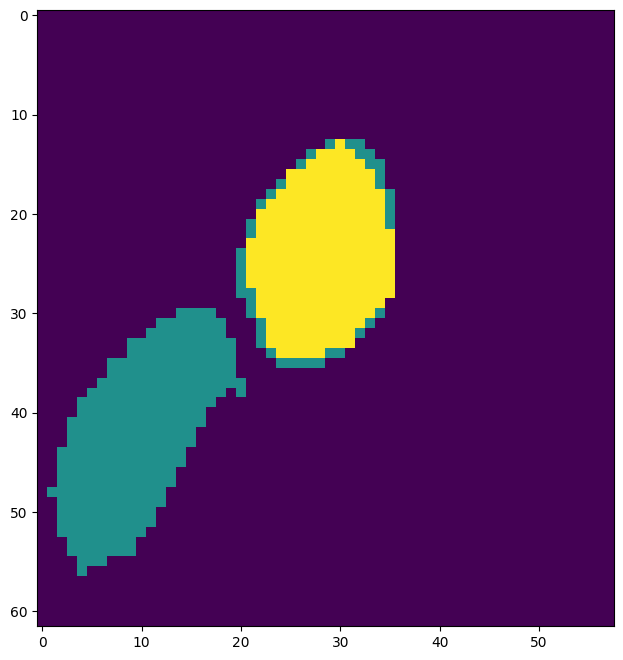

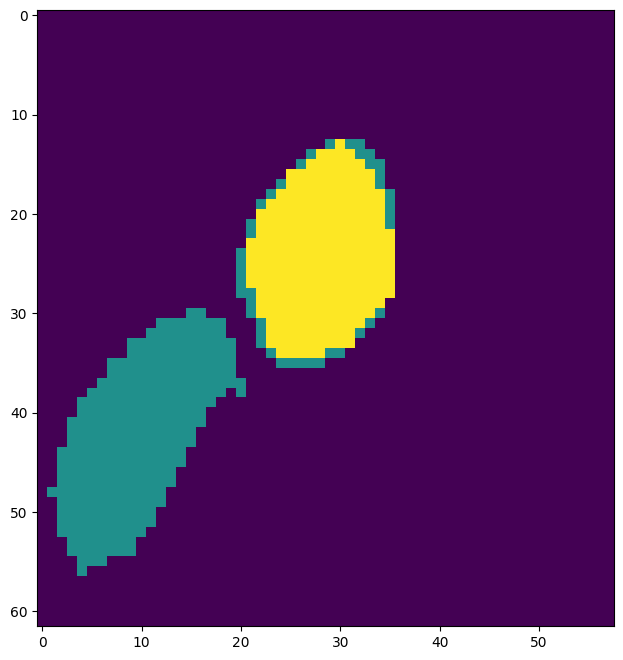

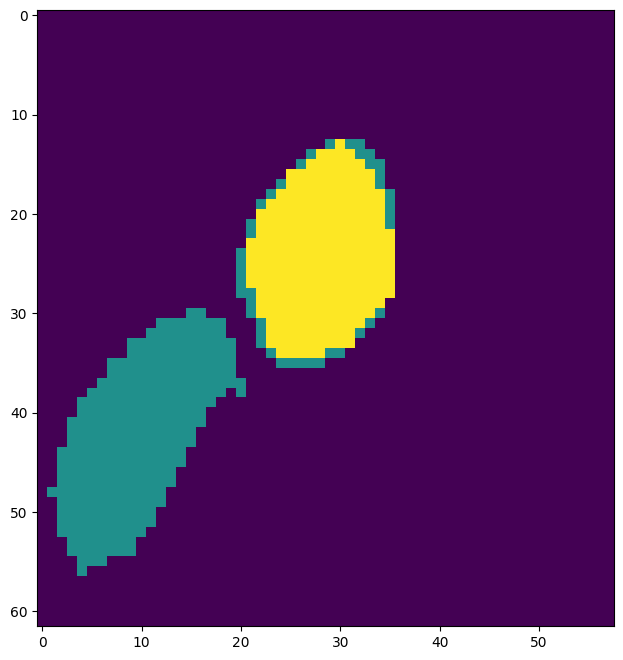

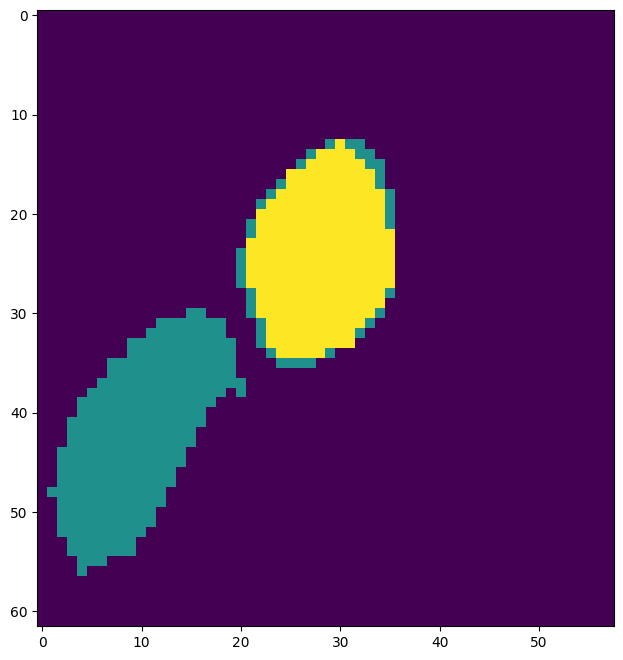

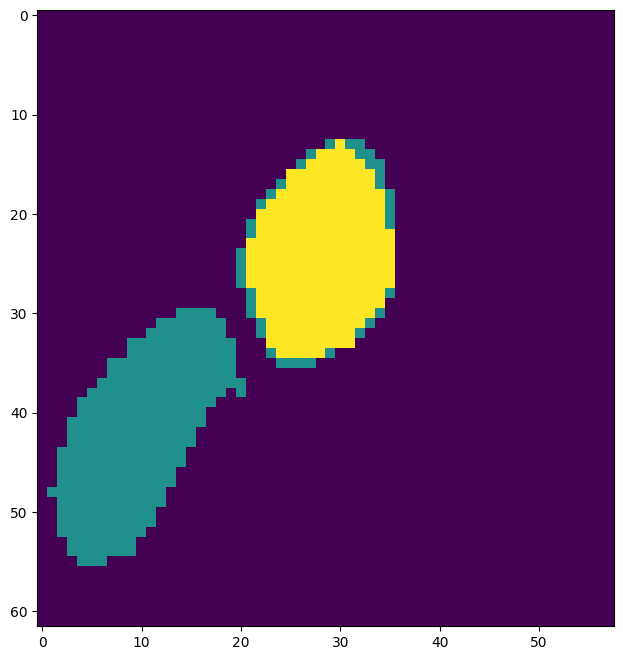

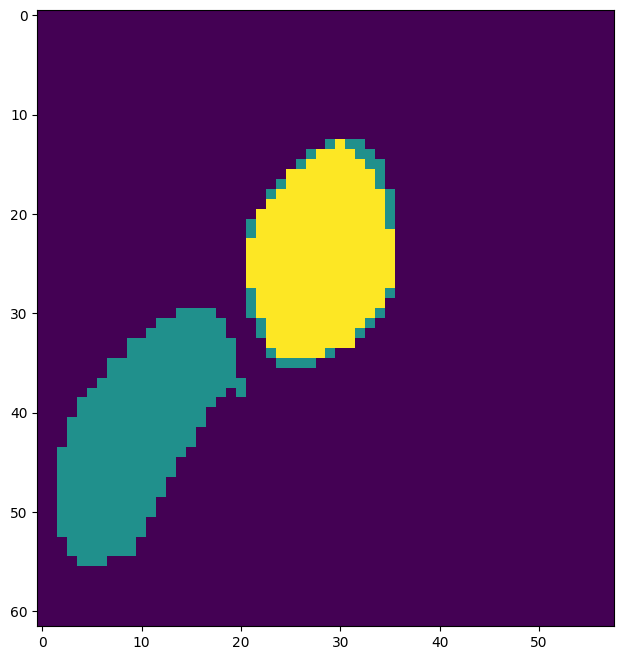

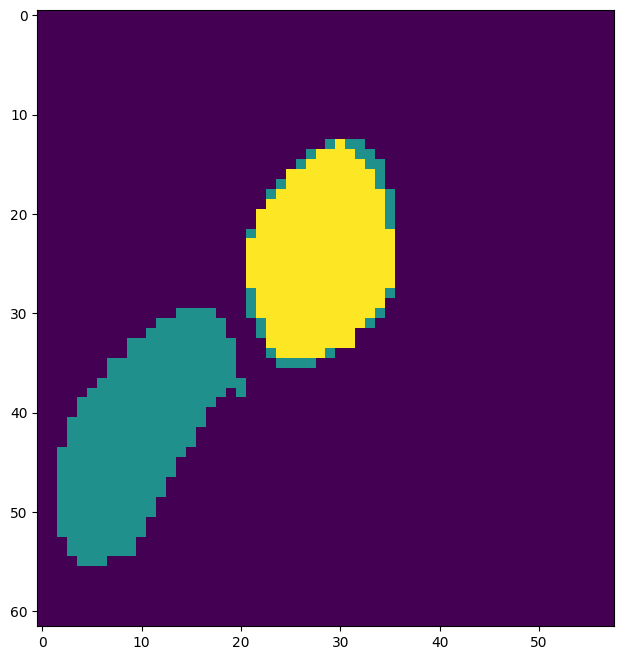

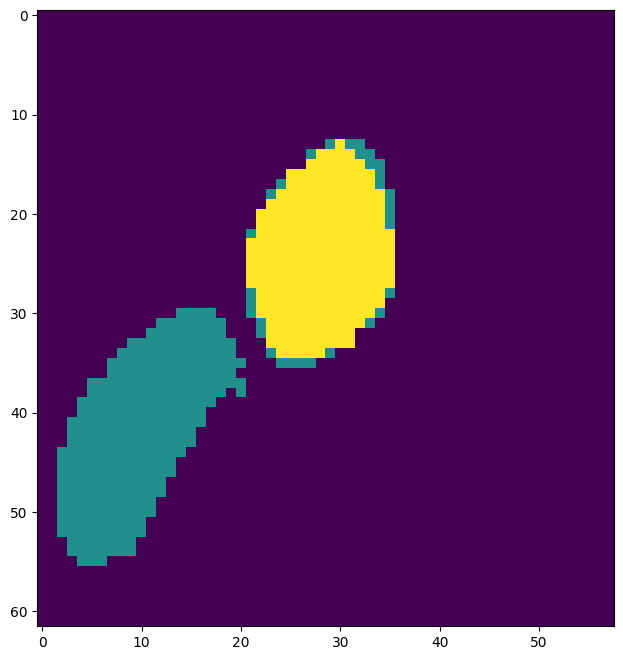

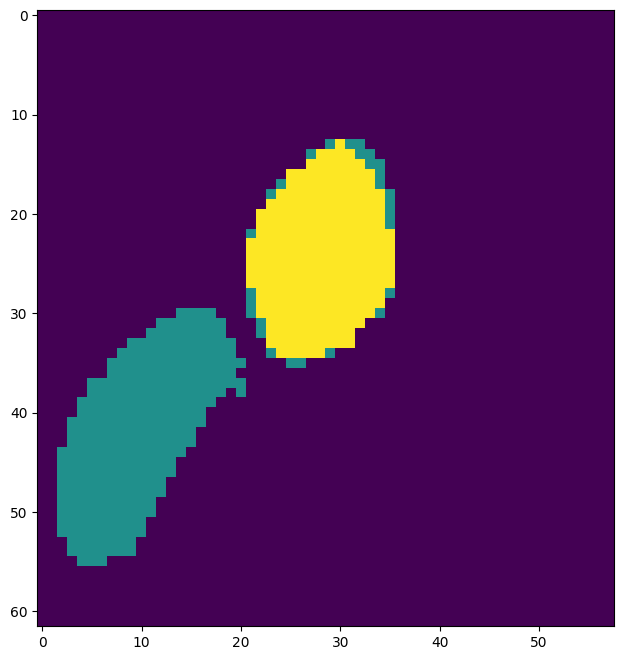

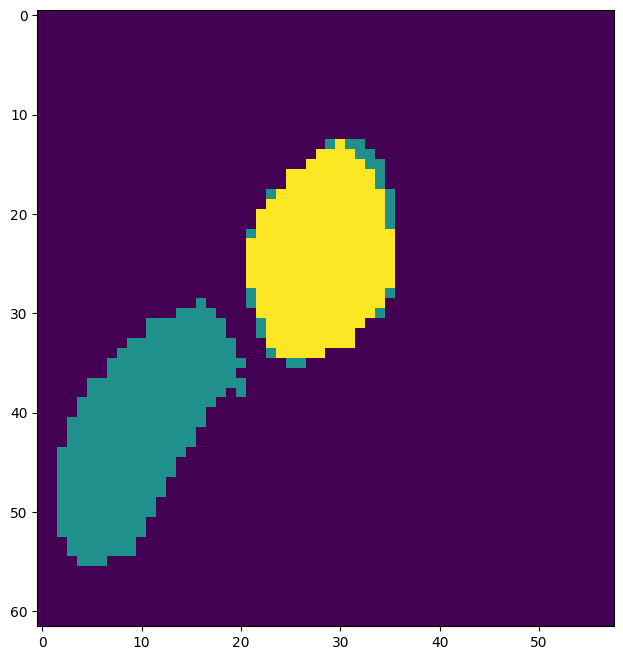

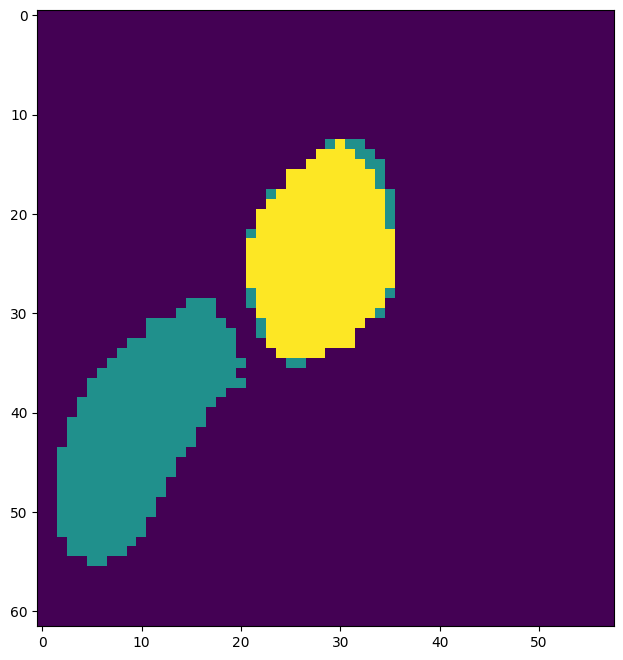

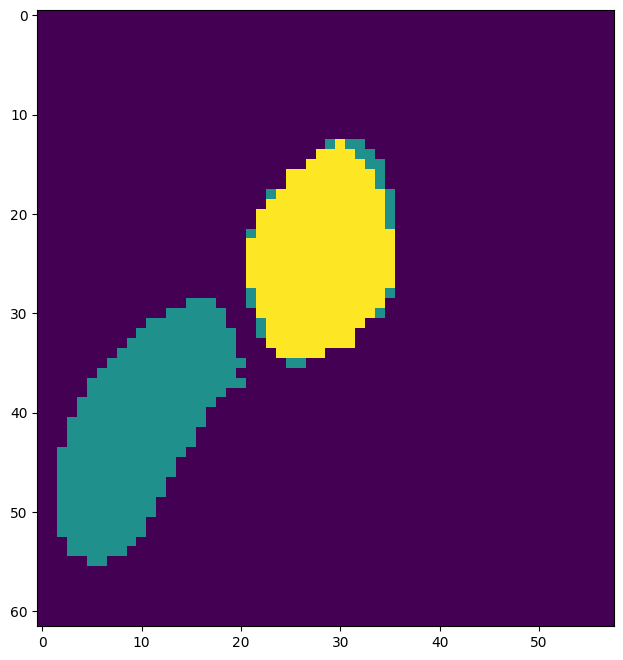

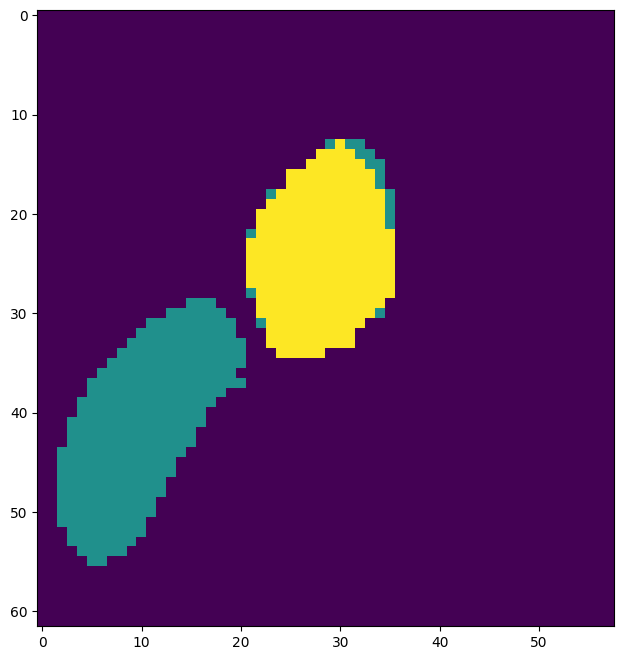

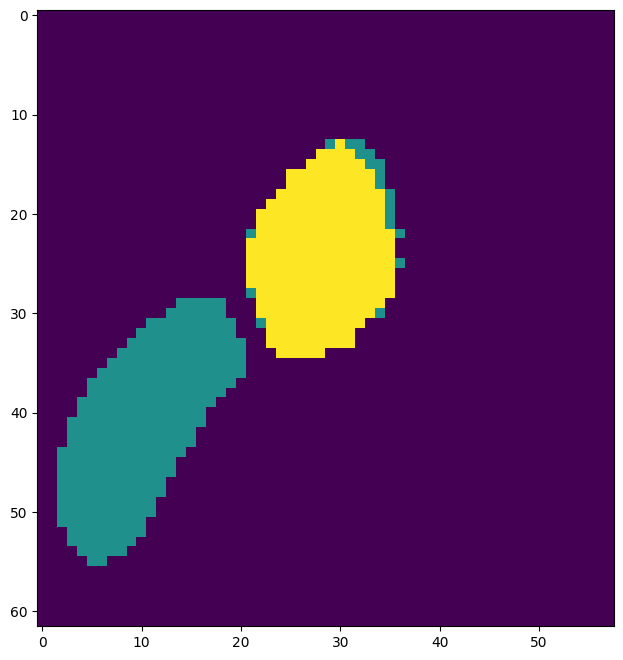

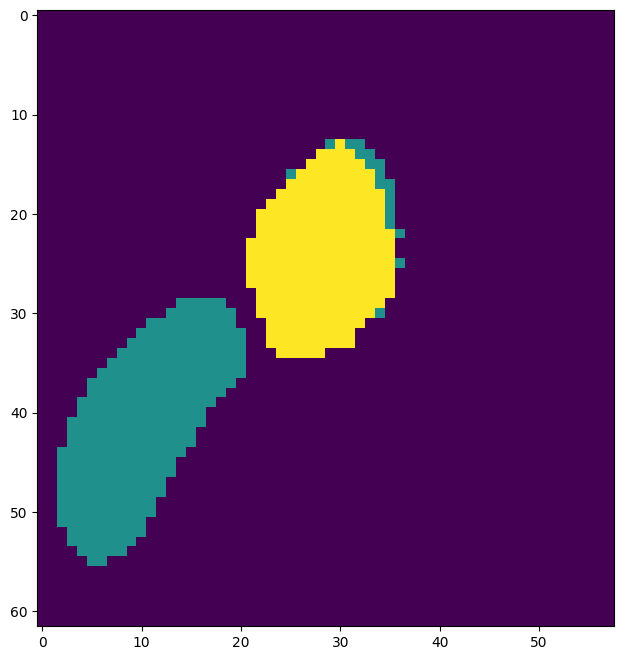

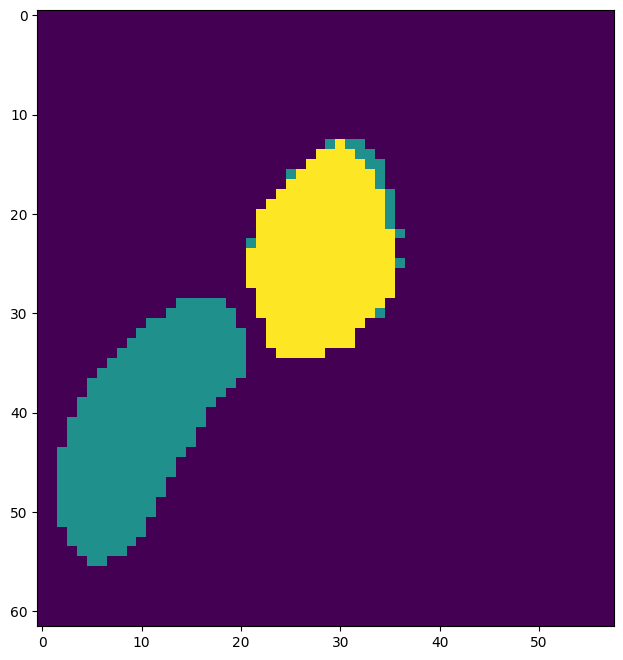

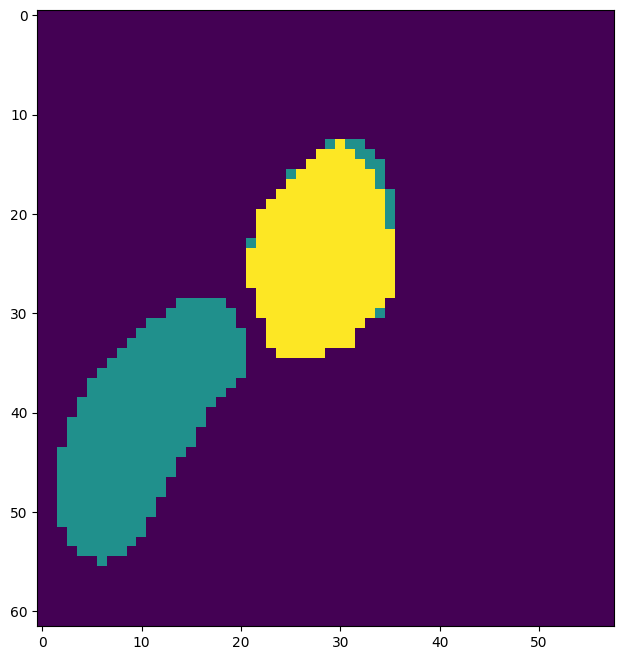

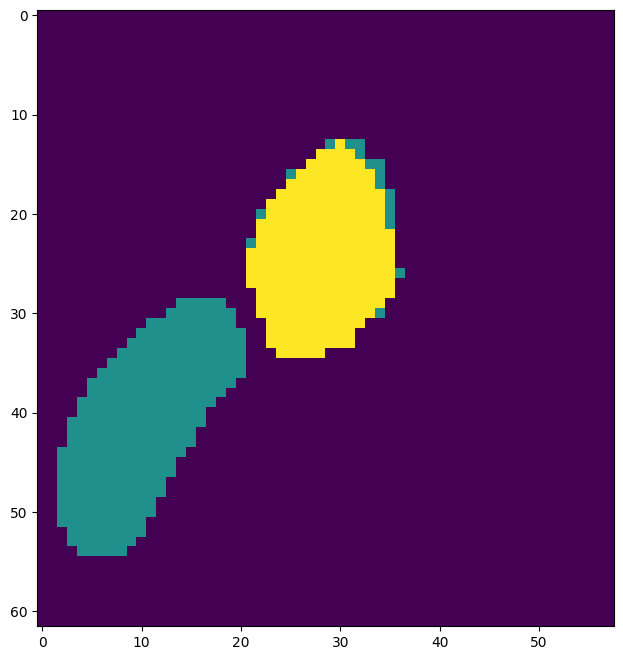

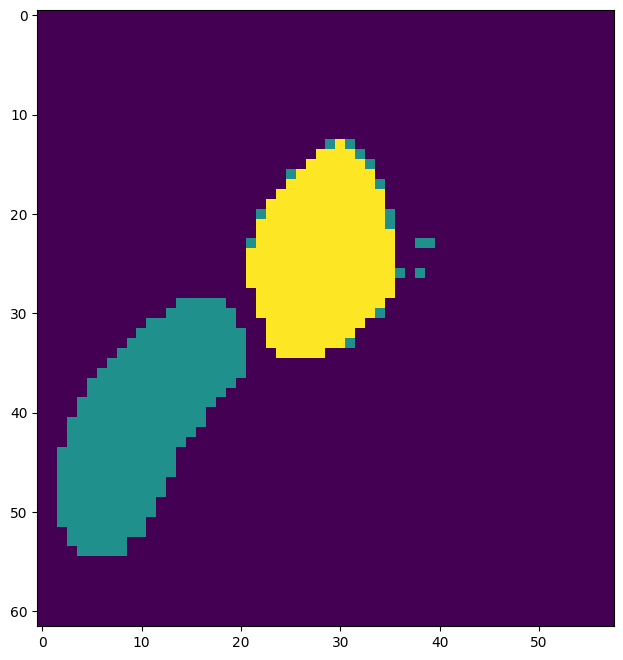

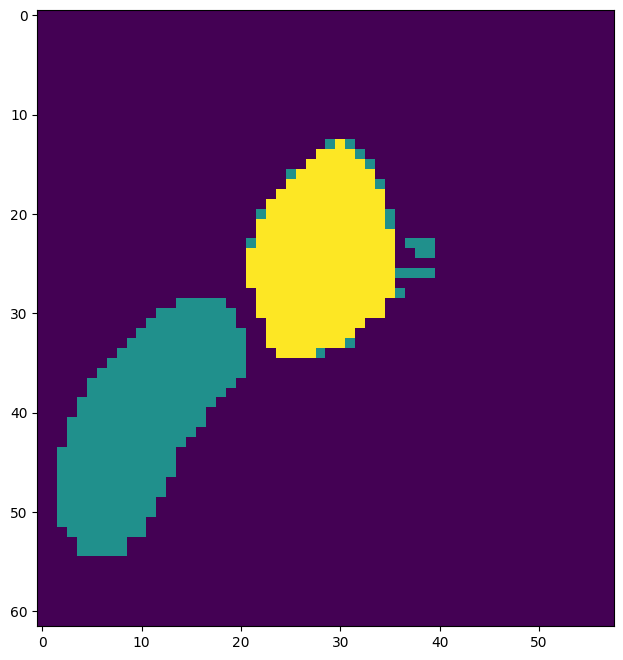

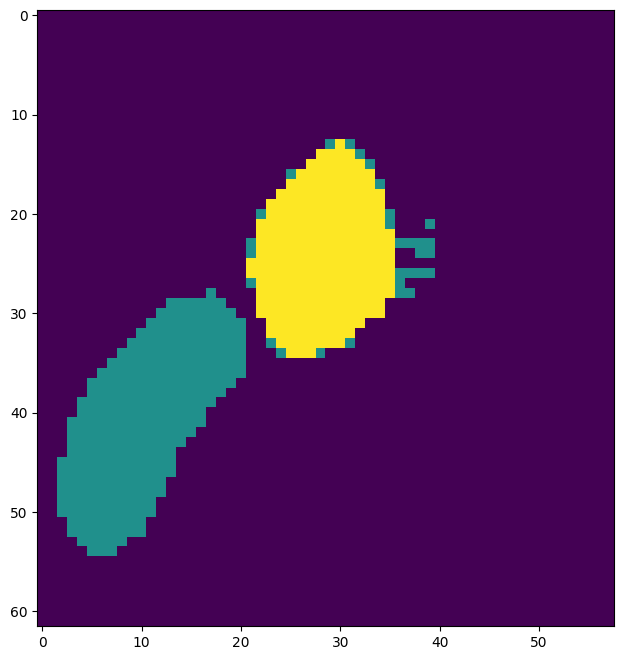

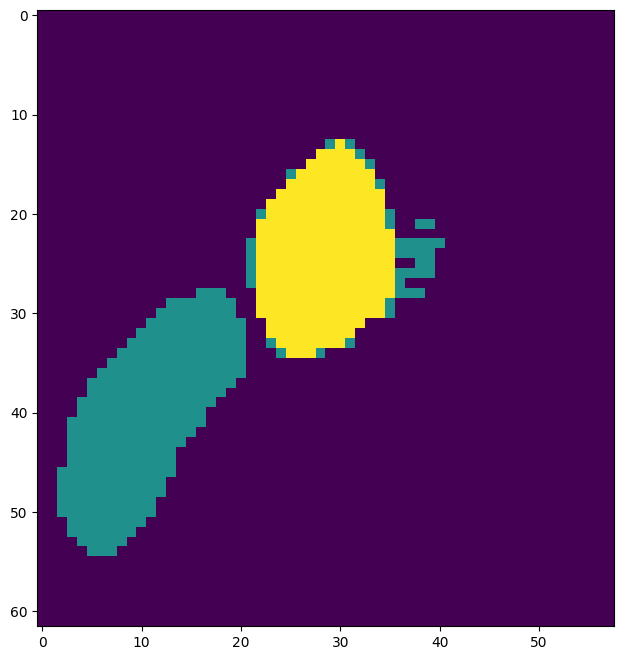

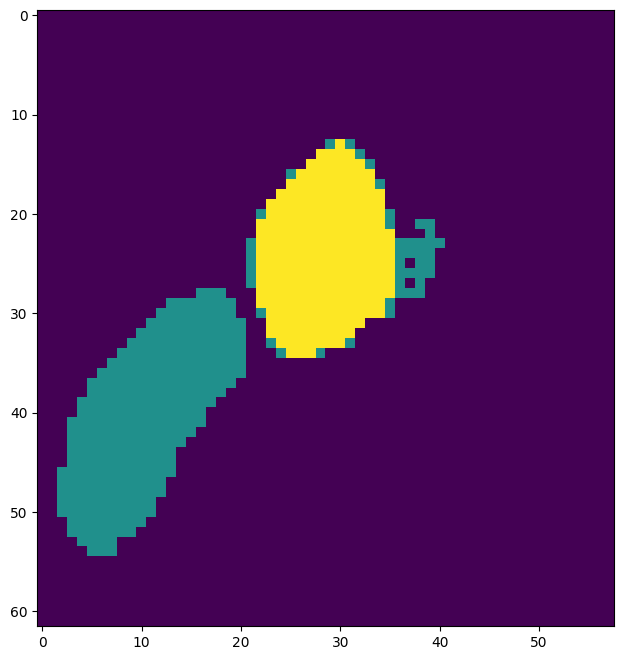

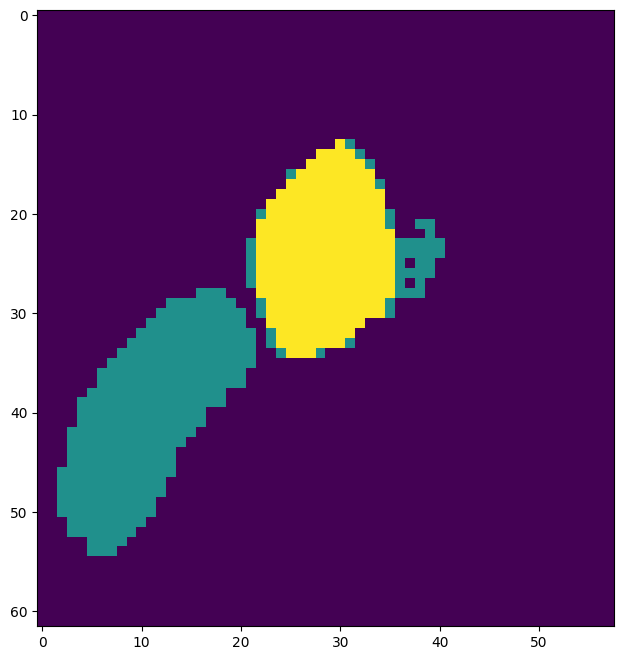

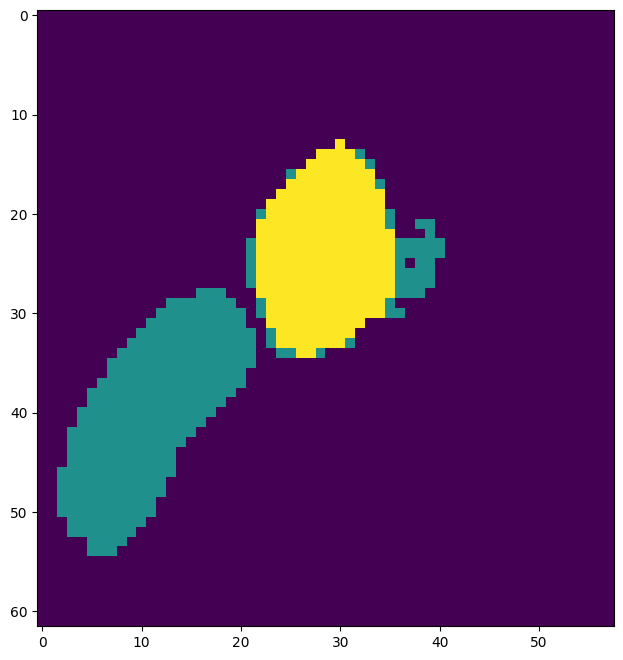

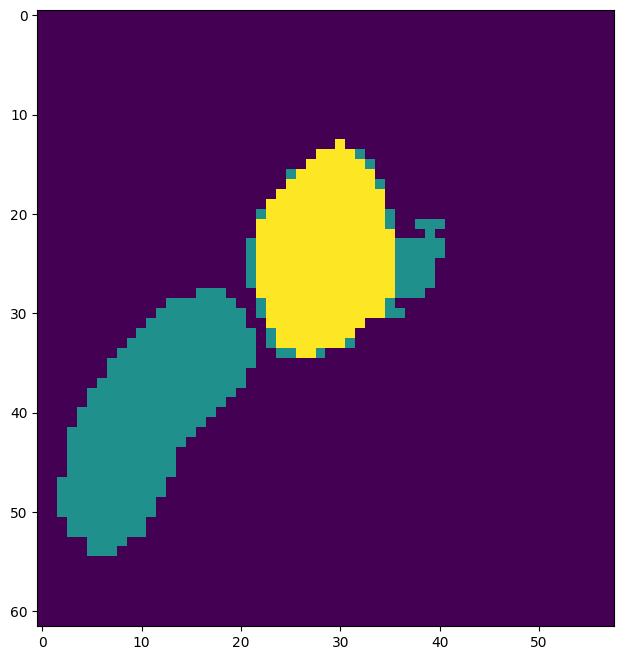

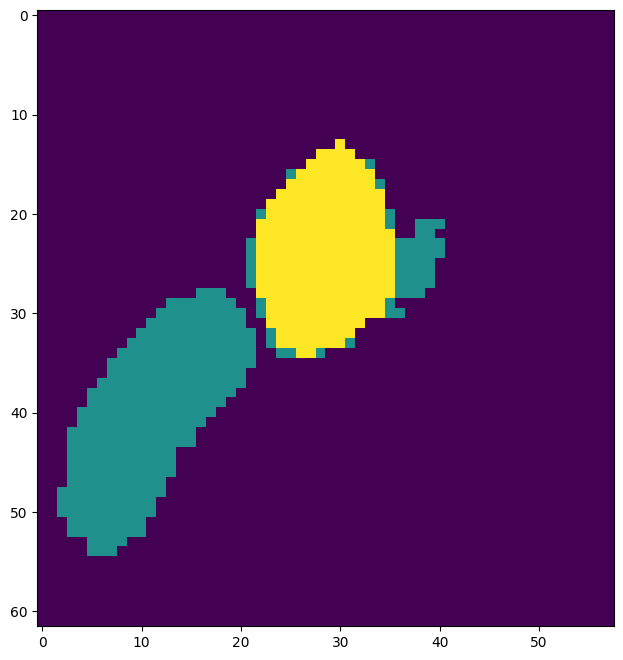

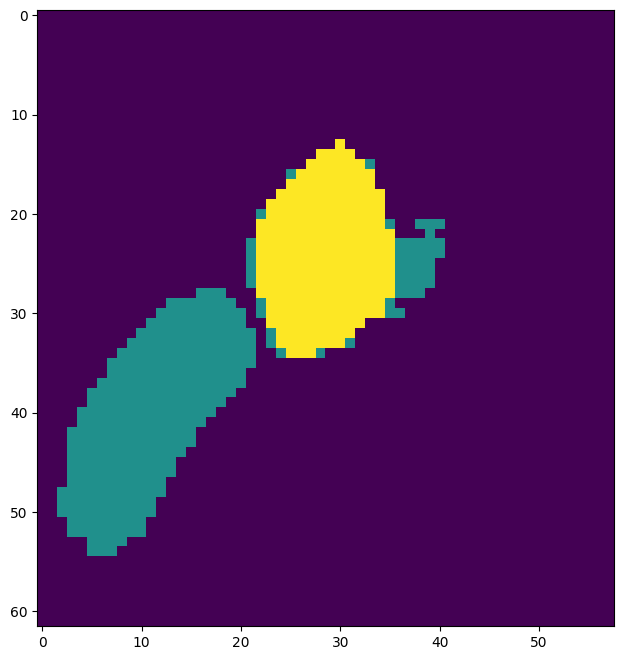

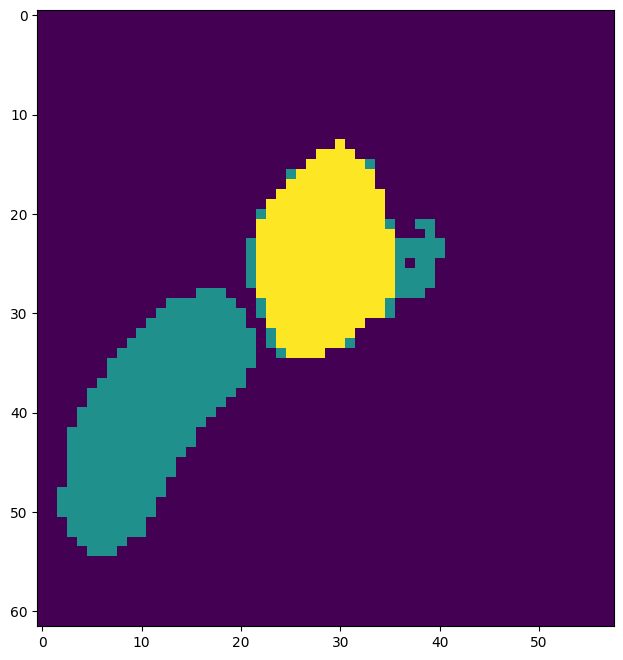

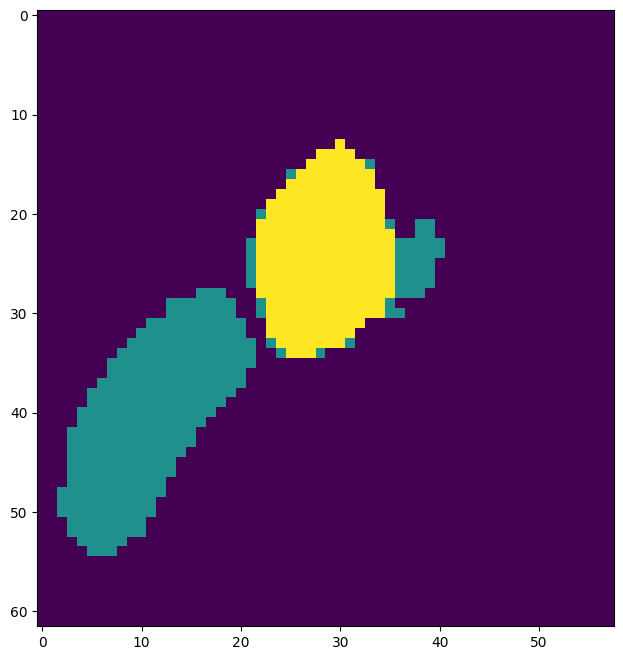

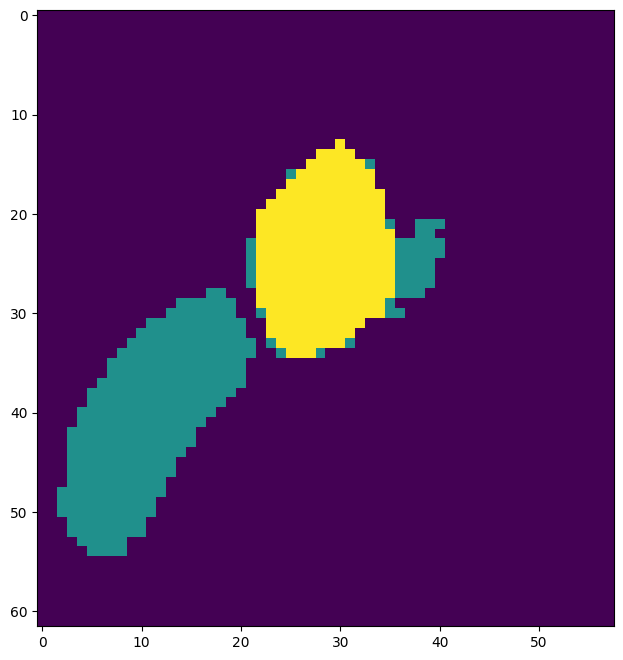

In [36]:

for t in range(gt['u'].shape[0]):
    img_mask = gt['mask'][t][idx_plane].reshape(xx.shape[1], -1)
    img_MV_mask = points_MV[idx_plane].reshape(xx.shape[1], -1)
    # plt.imshow(gt['mask'][t][idx_plane].reshape(xx.shape[1], -1))
    plt.imshow(img_MV_mask+img_mask)
    # plt.imshow(img_MV_mask)
    plt.show()



### Plot examle frames over time

In [ ]:
def velocity_through_plane(idx_plane, data, normal):
    N_frames = data['u'].shape[0]
    vx_in_plane = data['u'][:, idx_plane[0], idx_plane[1], idx_plane[2]].reshape(N_frames, -1)
    vy_in_plane = data['v'][:, idx_plane[0], idx_plane[1], idx_plane[2]].reshape(N_frames, -1)
    vz_in_plane = data['w'][:, idx_plane[0], idx_plane[1], idx_plane[2]].reshape(N_frames, -1)
    return vx_in_plane*normal[0]+ vy_in_plane*normal[1]+ vz_in_plane*normal[2]


def img(idx_intersection_plane_fluid, data,gt,  label = '', color = 'black'):
    N_frames = data['u'].shape[0]
    V_plane_pred = vx_in_plane

    V_plane_pred = vx_in_plane*normal[0]+ vy_in_plane*normal[1]+ vz_in_plane*normal[2]
    V_plane_gt = vx_in_plane_gt*normal[0]+ vy_in_plane_gt*normal[1]+ vz_in_plane_gt*normal[2]
    rmse = np.sqrt(np.mean((V_plane_pred-V_plane_gt)**2, axis = 1))
    plt.plot(rmse,'.-', label = label, color = color)
    plt.xlabel('frame')
    plt.ylabel('RMSE')

In [ ]:
#ax = fig.add_subplot(1, 1, 1, projection='3d')
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
x, y = np.where(line_plane !=0)
z = V_plane.copy()
X, Y = np.meshgrid(range(line_plane.shape[1]), range(line_plane.shape[0]))
surf = ax.plot_surface(X, Y, z, cmap=cm.coolwarm)
fig.colorbar(surf)
plt.show()

In [ ]:
########
N_frames = gt['u'].shape[0]

point  = np.array([22, 25, 35])
x_line = 22
normal = np.array([-0.4, -0.5, 1]).astype(float) #[0, -0.5, 1]
normal /= np.linalg.norm(normal) #normalize normal
print('Normal vector norm:', np.linalg.norm(normal))

d = -point.dot(normal)

# create x,y
xx, yy = np.meshgrid(range(0, gt['u'].shape[1]), range(0, gt['u'].shape[2]))

# calculate corresponding z
#TODO check if this is correct
zz = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]


#points in plane: 3D data, 1 where plane is, 0 where no plane
points_in_plane = np.zeros_like(gt['mask'][t])
points_in_plane[xx.flatten().astype(int), yy.flatten().astype(int), zz.flatten().astype(int)] = 1


idx_plane =  np.where(points_in_plane>0)

vx_in_plane = pred['u'][:, idx_plane[0], idx_plane[1], idx_plane[2]].reshape(N_frames, xx.shape[1], -1) 
vy_in_plane = pred['v'][:, idx_plane[0], idx_plane[1], idx_plane[2]].reshape(N_frames, xx.shape[1], -1)
vz_in_plane = pred['w'][:, idx_plane[0], idx_plane[1], idx_plane[2]].reshape(N_frames, xx.shape[1], -1)
line_plane = points_in_plane[idx_plane].reshape(xx.shape[1], -1)


errorX_in_plane = error_absolut['u'][:, idx_plane[0], idx_plane[1], idx_plane[2]].reshape(N_frames, xx.shape[1], -1) 
errorY_in_plane = error_absolut['v'][:, idx_plane[0], idx_plane[1], idx_plane[2]].reshape(N_frames, xx.shape[1], -1)
errorZ_in_plane = error_absolut['w'][:, idx_plane[0], idx_plane[1], idx_plane[2]].reshape(N_frames, xx.shape[1], -1)


###################################
def create_temporal_plane_vel_surface(line_plane, vx_in_plane, vy_in_plane, vz_in_plane,errorX_in_plane, errorY_in_plane, errorZ_in_plane, normal, vel, title):
    
    V_plane_all_T = vx_in_plane*normal[0]+ vy_in_plane*normal[1]+ vz_in_plane*normal[2]
    Error_plane_projected = np.abs(errorX_in_plane*normal[0] + errorY_in_plane*normal[1]+ errorZ_in_plane*normal[2])
    print('all time points;', V_plane_all_T.shape, Error_plane_projected.shape)
    z_min, z_max = np.min(V_plane_all_T), np.max(V_plane_all_T)
    e_min, e_max = np.min(Error_plane_projected), np.max(Error_plane_projected)
    # print(title, 'nframes:', data.shape[0])
    fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={"projection": "3d"})
    x, y = np.where(line_plane !=0)
    z = V_plane.copy()
    X, Y = np.meshgrid(range(line_plane.shape[1]), range(line_plane.shape[0]))
    surf = ax1.plot_surface(X, Y, V_plane_all_T[0], cmap=cm.viridis,vmin = z_min, vmax = z_max)
    fig.colorbar(surf)

    surf = ax2.plot_surface(X, Y, Error_plane_projected[0], cmap=cm.coolwarm,vmin = z_min, vmax = z_max)
    fig.colorbar(surf)
    
    plt.title(title)
    plt.axis('off')
    
    #fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
    plt.tight_layout()

    #initialization function: plot the background of each frame
    # def init():
    #     im1.set_data(np.random.random((5,5)))
    #     return [im1]

    # animation function.  This is called sequentially
    def animate(frame):
        ax1.clear()
        ax2.clear()
        V_plane_i = vx_in_plane[frame]*normal[0]+ vy_in_plane[frame]*normal[1]+ vz_in_plane[frame]*normal[2]
        surf = ax1.plot_surface(X, Y, V_plane_i, cmap=cm.viridis,vmin = z_min, vmax = z_max)
        ax1.set_zlim(z_min,z_max)

        surf = ax2.plot_surface(X, Y, Error_plane_projected[frame], cmap=cm.coolwarm)
        ax2.set_zlim(e_min,e_max)
        # fig.colorbar(surf)
        #return [im1]

    anim = animation.FuncAnimation(fig,animate, #init_func=init,
                                frames = 50,
                                interval = 100) # in ms)
    anim.save(f'{eval_dir}/Animate_PlaneVel_{title}_{vel}_Slower.gif', fps=5)


#############################################0
t = 35
#plane parameters


print(vx_in_plane.shape)
#Velocity through plane
V_plane = vx_in_plane[t]*normal[0]+ vy_in_plane[t]*normal[1]+ vz_in_plane[t]*normal[2]
#######
#ax = fig.add_subplot(1, 1, 1, projection='3d')
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
x, y = np.where(line_plane !=0)
z = V_plane.copy()
X, Y = np.meshgrid(range(line_plane.shape[1]), range(line_plane.shape[0]))
surf = ax.plot_surface(X, Y, V_plane, cmap=cm.coolwarm)
fig.colorbar(surf)
plt.show()

create_temporal_plane_vel_surface(line_plane, vx_in_plane, vy_in_plane, vz_in_plane,errorX_in_plane, errorY_in_plane, errorZ_in_plane,normal, 'Plane vel', 'Test')

#### Plot histogram of velocities

In [ ]:
compare_velocitywise = False
plt.figure(figsize=(8, 5))

if compare_velocitywise:

    plt.subplot(2,1, 1)
    plt.hist(gt["u"][np.where(temporal_mask !=0)].flatten(), bins = 1000, color='g', label = r'$V_x$')
    plt.hist(gt["v"][np.where(temporal_mask !=0)].flatten(), bins = 1000,  color='b', label = r'$V_y$')
    plt.hist(gt["w"][np.where(temporal_mask !=0)].flatten(), bins = 1000,  color='r', label = r'$V_z$')
    plt.xlim(np.quantile(gt["u"][np.where(temporal_mask !=0)].flatten(), 0.01), np.quantile(gt["u"][np.where(temporal_mask !=0)].flatten(), 0.99))
    plt.xlabel('value')
    plt.title("Distribution of velocity values in fluid region without outliers")
    plt.legend()

    plt.subplot(2,1, 2)
    plt.hist(pred["u"][np.where(temporal_mask !=0)].flatten(), bins = 1000, color='g', label = r'$V_x$')
    plt.hist(pred["v"][np.where(temporal_mask !=0)].flatten(), bins = 1000,  color='b', label = r'$V_y$')
    plt.hist(pred["w"][np.where(temporal_mask !=0)].flatten(), bins = 1000,  color='r', label = r'$V_z$')
    plt.xlim(np.quantile(gt["u"][np.where(temporal_mask !=0)].flatten(), 0.01), np.quantile(gt["u"][np.where(temporal_mask !=0)].flatten(), 0.99))
    plt.xlabel('value')
    #plt.title("Distribution of velocity values in fluid region without outliers")
    plt.legend()
    plt.show()

else:
    plt.subplot(1, 3, 1)
    plt.hist(gt["u"][np.where(temporal_mask !=0)].flatten(), bins = 1000, color='black', label = r'$V_x$')
    plt.hist(pred["u"][np.where(temporal_mask !=0)].flatten(), bins = 1000, color='g', label = 'u predicted')    
    plt.xlim(np.quantile(gt["u"][np.where(temporal_mask !=0)].flatten(), 0.01), np.quantile(gt["u"][np.where(temporal_mask !=0)].flatten(), 0.99))
    plt.xlabel('value')
    plt.title("Distribution of velocity values in fluid region without outliers")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.hist(gt["v"][np.where(temporal_mask !=0)].flatten(), bins = 1000,  color='black', label = r'$V_y$')
    plt.hist(pred["v"][np.where(temporal_mask !=0)].flatten(), bins = 1000,  color='b', label = 'v predicted')
    plt.xlim(np.quantile(gt["v"][np.where(temporal_mask !=0)].flatten(), 0.01), np.quantile(gt["v"][np.where(temporal_mask !=0)].flatten(), 0.99))
    plt.legend()
    plt.xlabel('value')

    plt.subplot(1, 3, 3)
    plt.hist(gt["w"][np.where(temporal_mask !=0)].flatten(), bins = 1000,  color='black', label = r'$V_z$')
    plt.hist(pred["w"][np.where(temporal_mask !=0)].flatten(), bins = 1000,  color='r', label = 'w predicted')
    plt.xlim(np.quantile(gt["w"][np.where(temporal_mask !=0)].flatten(), 0.01), np.quantile(gt["w"][np.where(temporal_mask !=0)].flatten(), 0.99))
    plt.xlabel('value')
    #plt.title("Distribution of velocity values in fluid region without outliers")
    plt.legend()
    plt.tight_layout()
    plt.show()

### Plot relative error and mean speed 

In [ ]:
plt.figure(figsize=(7, 4))

plt.plot(calculate_rmse(pred['u'], gt['u'], gt['mask']), label = r'$V_x$')
plt.plot(calculate_rmse(pred['v'], gt['v'], gt['mask']), label = r'$V_y$')
plt.plot(calculate_rmse(pred['w'], gt['w'], gt['mask']), label = r'$V_z$')
# plt.plot(calculate_rmse(interpolate_linear['w'], gt['w'], gt['mask']), label = 'interpolate w')
plt.plot(calculate_rmse(pred['speed'], gt['speed'], gt['mask']), label = 'speed')
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('frame')
plt.title('RMSE')

In [ ]:
plt.figure(figsize=(11, 8))

reverse_mask = np.ones_like(gt['mask']) - gt['mask']

plt.subplot(3, 1, 3)
#plot_relative_error([gt_filepath],[res_filepath], [set_name])
N_frames = gt['u'].shape[0]
#plt.legend(lst_names)
plt.title("Relative error")
plt.plot(rel_error, label = '4DFlowNet', color = KTH_colors['blue100'])
plt.plot(rel_error_lin_interpolation[:-1], label = 'linear interpolation',color = KTH_colors['green100'])
plt.plot(rel_error_cubic_interpolation, label = 'cubic interpolation', color = 'forestgreen')
# plt.plot(50*np.ones(len(rel_error)), 'k:')
plt.xlabel("Frame")
plt.ylabel("Relative error (%)")
plt.ylim((0, 100))
plt.legend(loc = 'upper left')

plt.subplot(3, 1, 2)
# plt.plot(calculate_rmse(pred['speed'], gt['speed'], gt['mask']), label = 'speed')
plt.plot(calculate_rmse(pred['u'], gt['u'], gt['mask']), label = r'$V_x$ fluid region', color = KTH_colors['grey100'])
plt.plot(calculate_rmse(pred['v'], gt['v'], gt['mask']), label = r'$V_y$ fluid region', color = KTH_colors['lightblue100'])
plt.plot(calculate_rmse(pred['w'], gt['w'], gt['mask']), label = r'$V_z$ fluid region', color = KTH_colors['pink40'])
# plt.plot(calculate_rmse(pred['speed'], gt['speed'], gt['mask']), label = 'speed', color = KTH_colors['grey40'])
# plt.plot(calculate_rmse(interpolate_linear['w'], gt['w'], gt['mask']), label = r'$V_z$ linear interpolation', color = KTH_colors['green100'])
plt.ylabel('RMSE')
plt.xlabel('Frame')
plt.title('RMSE ')
plt.legend(loc = 'upper left')

# plt.subplot(4, 1, 2)
# plt.plot(calculate_rmse(pred['speed'], gt['speed'], gt['mask']), label = 'speed')
plt.plot(calculate_rmse(pred['u'], gt['u'], reverse_mask), label = r'$V_x$ non-fluid region',linestyle = '--',  color = KTH_colors['grey100'])
plt.plot(calculate_rmse(pred['v'], gt['v'], reverse_mask), label = r'$V_y$ non-fluid region',linestyle = '--',  color = KTH_colors['lightblue100'])
plt.plot(calculate_rmse(pred['w'], gt['w'], reverse_mask), label = r'$V_z$ non-fluid region',linestyle = '--',  color = KTH_colors['pink40'])
# plt.plot(calculate_rmse(pred['speed'], gt['w'], reverse_mask), label = r'$V_z$', color = KTH_colors['pink40'])
# plt.plot(calculate_rmse(interpolate_linear['w'], gt['w'], gt['mask']), label = r'$V_z$ linear interpolation', color = KTH_colors['green100'])
plt.ylabel('RMSE')
plt.xlabel('Frame')
plt.title('RMSE')
plt.legend(loc = 'upper left')




plt.subplot(3, 1, 1)
plt.plot(gt['mean_speed'], '.-',label ='High resolution', color = 'black')
plt.plot(pred['mean_speed'],'.-', label= '4DFlowNet', color = KTH_colors['blue100'])
plt.plot(range(0, N_frames, 2),  lr['mean_speed'],'.-',  label = 'Low resolution', color = KTH_colors['green100'])
# plt.plot(interpolate_linear['mean_speed'][:-1],'--', label = 'linear interpolation', color = 'pink')
# plt.plot(interpolate_cubic['mean_speed'][:-1] , label = 'cubic interpoaltion', color = 'forestgreen')
plt.xlabel("Frame")
plt.ylabel("Mean speed (cm/s)")
plt.legend(loc = 'upper left')
plt.title('Mean speed')
plt.tight_layout()
plt.savefig(f'{eval_dir}/{set_name}_RE_RMSE_MEAN_SPEED.svg',bbox_inches='tight')
plt.show()
#lst_hgt_paths, lst_hpred_paths,lst_names, save_as = 'Relative_error_comparison.png'


# plt.plot(gt['mean_speed'], '.-',label ='Ground truth', color = 'black')
# plt.plot(pred['mean_speed'],'x-',  label= '4DFlowNet', color = KTH_colors['blue100'])
# plt.plot(range(0, N_frames, 2),  lr['mean_speed'],'.-',  label = 'LR', color = KTH_colors['green100'])
# # plt.plot(interpolate_linear['mean_speed'][:-1],'--', label = 'linear interpolation', color = 'pink')
# # plt.plot(interpolate_cubic['mean_speed'][:-1] , label = 'cubic interpoaltion', color = 'forestgreen')
# plt.xlabel("Frame")
# plt.ylabel("Mean speed (cm/s)")
# plt.legend()
# plt.tight_layout()
# plt.savefig(f'{eval_dir}/MEAN_SPEED.svg',bbox_inches='tight')
# plt.show()

### Get metrics for table

In [ ]:

#mean speed error
print('mean speed average error', np.average(gt['mean_speed']-pred['mean_speed']))
print('mean speed max error', np.max(gt['mean_speed']-pred['mean_speed']))
# print('max speed error', np.max(gt['mean_speed']-pred['mean_speed']))
print('peak flow frame deviation, f35', np.abs(gt['mean_speed']-pred['mean_speed'])[35] ) #
print('peak flow frame deviation, f34', np.abs(gt['mean_speed']-pred['mean_speed'])[34] ) #
distastole = [0, 25]
szstole = [25, 50] 
#RMSE
print('RMSE distole AVG', np.average(calculate_rmse(pred['u'], gt['u'], gt['mask'])[:25]))
print('RMSE systole AVG', np.average(calculate_rmse(pred['u'], gt['u'], gt['mask'])[25:]))
print()

In [ ]:
print('mean speed absolute difference', gt['mean_speed']-pred['mean_speed'])

In [ ]:
plt.figure(figsize=(15, 5))

rel_error_core = calculate_relative_error_normalized(pred["u"], pred["v"], pred["w"], gt["u"], gt["v"] , gt["w"], core_mask)
rel_error_bounds = calculate_relative_error_normalized(pred["u"], pred["v"], pred["w"], gt["u"], gt["v"] , gt["w"], bounds)
# plt.subplot(3, 1, 1)

#plt.legend(lst_names)
plt.title("Relative error")
plt.subplot(1,2 , 1)
plt.plot(rel_error, label = set_name)
plt.plot(rel_error_bounds, label = f'{set_name} boundary', color = 'red')
plt.plot(rel_error_core, label = f'{set_name} core', color ='gray')
plt.plot(rel_error_lin_interpolation[:-1], label = 'linear interpolation',color = 'yellowgreen')
plt.plot(rel_error_cubic_interpolation, label = 'cubic interpolation', color = 'forestgreen')
plt.plot(50*np.ones(len(rel_error)), 'k:')
plt.xlabel("Frame")
plt.ylabel("Relative error (%)")
plt.ylim((0, 100))
plt.legend()

plt.subplot(1, 2, 2)
frames = len(rel_error)
plt.title("Relative error")
plt.plot(rel_error, label = set_name)
plt.plot(rel_error_lin_interpolation[:-1], label = 'linear interpolation',color = 'yellowgreen')
plt.plot(rel_error_cubic_interpolation, label = 'cubic interpolation', color = 'forestgreen')
plt.plot(50*np.ones(len(rel_error)), 'k:')
plt.xlabel("Frame")
plt.ylabel("Relative error (%)")
plt.ylim((0, 100))
plt.legend()
points_in_mask = np.where(temporal_mask !=0)

reshaped_error = np.tanh(error_pointwise[:, points_in_mask[1], points_in_mask[2], points_in_mask[3]].reshape(frames, -1))
max_error = np.max(reshaped_error, axis=1)*100

sd_error = np.std(reshaped_error, axis = 1)*100
error = np.random.normal(0, sd_error, size=len(rel_error))
plt.fill_between(range(len(rel_error)), rel_error-sd_error, rel_error+sd_error, alpha = 0.5)

### Quiver plot testing

In [ ]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

set_to_zero = 0.9



@widgets.interact(frame=(0, gt["u"].shape[0]-1))
def f_quiver(frame=10 ):
    #frame = 15
    u_quiver = gt['u'][frame].copy() #- pred['u'][frame]
    v_quiver = gt['v'][frame].copy() #- pred['v'][frame]
    w_quiver = gt['w'][frame].copy() #- pred['w'][frame]

    x_idx, y_idx, z_idx = random_indices3D(temporal_mask[frame], int(np.count_nonzero(temporal_mask[frame])*set_to_zero))
    x_len, y_len, z_len = gt['u'].shape[1::]

    # ev = np.array([1, 0, 0])
    #angles = np.arccos(np.dot(ev, [u, v, w]) / (np.linalg.norm(ev) * np.linalg.norm(v2)))
    # angles = np.multiply
    # Make the grid
    x, y, z = np.meshgrid(np.arange(y_len),np.arange(x_len),np.arange(z_len))
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    u_quiver[x_idx, y_idx, z_idx] = 0
    v_quiver[x_idx, y_idx, z_idx] = 0
    w_quiver[x_idx, y_idx, z_idx] = 0

    cropx = cropy = cropz = 25
    startx = x_len//2-(cropx//2)
    starty = y_len//2-(cropy//2)    
    startz = z_len//2-(cropz//2)
    u_quiver = u_quiver[startx:startx+cropx, starty:starty+cropy,startz:startz+cropz] 
    v_quiver = v_quiver[startx:startx+cropx, starty:starty+cropy,startz:startz+cropz] 
    w_quiver = w_quiver[startx:startx+cropx, starty:starty+cropy,startz:startz+cropz] 

    x =x[startx:startx+cropx, starty:starty+cropy,startz:startz+cropz] 
    y =y[startx:startx+cropx, starty:starty+cropy,startz:startz+cropz] 
    z =z[startx:startx+cropx, starty:starty+cropy,startz:startz+cropz]

    u_new = u_quiver[np.where(u_quiver != 0)]
    v_new = v_quiver[np.where(u_quiver != 0)]
    w_new = w_quiver[np.where(u_quiver != 0)]

    x_new = x[np.where(u_quiver!=0)] 
    y_new = y[np.where(u_quiver!=0)] 
    z_new = z[np.where(u_quiver!=0)]


    # Color by magnitude
    c = np.sqrt(u_new**2+ v_new**2+ w_new**2)#np.arctan2(w_new, u_new)
    # Flatten and normalize

    c = (c.ravel() - c.min()) / c.ptp()
    # Repeat for each body line and two head lines
    c = np.concatenate((c, np.repeat(c, 2)))
    # Colormap
    c = plt.cm.jet(c)


    ax.quiver(x_new, y_new, z_new, u_new, v_new, w_new, length=10, normalize=False,  pivot='middle', color = c)#, color=plt.cm.plasma([0.1,0.5, 0.9]))
    plt.xlabel('x')
    plt.ylabel('y')
    #plt.zlabel('z')
    plt.show()

### 3D Plot for temporal development

In [ ]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

set_to_zero = 0.9



@widgets.interact(frame=(0, gt["u"].shape[0]-1), x_plane = (0, gt["u"].shape[1]-1), axis_cut = ['x', 'y', 'z'], angle = (0, 360))
def f_3Dplot(frame=10 , x_plane = 2, axis_cut = 'x', angle = 20):
    #frame = 15
    u_quiver = gt['u'][frame].copy() #- pred['u'][frame]
    v_quiver = gt['v'][frame].copy() #- pred['v'][frame]
    w_quiver = gt['w'][frame].copy() #- pred['w'][frame]

    diff = np.abs(gt['speed'][frame] - pred['speed'][frame])

    x_idx, y_idx, z_idx = random_indices3D(temporal_mask[frame], int(np.count_nonzero(temporal_mask[frame])*set_to_zero))
    x_len, y_len, z_len = gt['u'].shape[1::]

    # ev = np.array([1, 0, 0])
    #angles = np.arccos(np.dot(ev, [u, v, w]) / (np.linalg.norm(ev) * np.linalg.norm(v2)))
    # angles = np.multiply
    # Make the grid
    x, y, z = np.meshgrid(np.arange(y_len),np.arange(x_len),np.arange(z_len))
    
    

    u_quiver[x_idx, y_idx, z_idx] = 0
    v_quiver[x_idx, y_idx, z_idx] = 0
    w_quiver[x_idx, y_idx, z_idx] = 0

    u_new = u_quiver[np.where(u_quiver != 0)]
    v_new = v_quiver[np.where(u_quiver != 0)]
    w_new = w_quiver[np.where(u_quiver != 0)]

    speed_new_diff = diff[np.where(u_quiver != 0)]

    x_new = x[np.where(u_quiver!=0)] 
    y_new = y[np.where(u_quiver!=0)] 
    z_new = z[np.where(u_quiver!=0)]


    # Color by magnitude
    c = np.sqrt(u_new**2+ v_new**2+ w_new**2)#np.arctan2(w_new, u_new)
    # Flatten and normalize

    c = (c.ravel() - c.min()) / c.ptp()
    # Repeat for each body line and two head lines
    c = np.concatenate((c, np.repeat(c, 2)))
    # Colormap
    # c = plt.cm.jet(c) #viridis
    c = plt.cm.viridis(c)

    cube_plane = np.zeros_like(u_quiver)
    if axis_cut == 'x':
        idx_plane = np.index_exp[x_plane, :, :]
    elif axis_cut == 'y':
        idx_plane = np.index_exp[:, x_plane, :]
    elif axis_cut == 'z':
        idx_plane = np.index_exp[:, :, x_plane]
    
    cube_plane[idx_plane] = 1 # change this for every slice
    x_plane, y_plane, z_plane = np.where(cube_plane == 1)
    x_bounds, y_bounds, z_bounds = np.where(bounds[0, :, :, :] ==1)
    intersec_plane = gt['mask'][0, :, :, :].copy()
    # intersec_plane += np.array(cube_plane, dtype = np.uint16)
    # intersec_plane[np.where(cube_plane == 1)] = 0
    intersec_plane[idx_plane] +=1
    x_intersec, y_intersec, z_intersec = np.where(intersec_plane == 2)
    print(np.unique(intersec_plane))

    fig = plt.figure()
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.scatter3D(x_plane, y_plane, z_plane, color = 'grey',alpha = 0.05 )
    ax.quiver(x_new, y_new, z_new, u_new, v_new, w_new, length=10, normalize=False,  pivot='middle', color = c)#, color=plt.cm.plasma([0.1,0.5, 0.9]))
    
    plt.xlabel('x')
    plt.ylabel('y')
    ax.view_init(15, angle)
    #plt.zlabel('z')
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    
    
    ax.scatter3D(x_bounds, y_bounds, z_bounds, s= 3, alpha = 0.1)
    ax.scatter3D(x_intersec, y_intersec, z_intersec, s= 3, alpha = 0.4, color = 'black')
    ax.scatter3D(x_plane, y_plane, z_plane, color = 'grey',alpha = 0.05 )
    # ax.scatter3D(x_new, y_new, z_new, s=speed_new_diff*10,  c = speed_new_diff, cmap = plt.cm.viridis)#, color=plt.cm.plasma([0.1,0.5, 0.9]))
    
    # ax.plot_surface(x_plane, y_plane, z_plane, alpha = 0.33, color = 'grey')
    # s = size of marker
    plt.xlabel('x')
    plt.ylabel('y')

    plt.show()

    plt.imshow(gt['u'][frame, idx_plane[0], idx_plane[1], idx_plane[2]])
    plt.axis('off')
    plt.show()


# plt.imshow(gt['u'][4][idx_plane])
# plt.show()



In [ ]:
import matplotlib.tri as mtri


mask_tri = gt['mask'][0]

fig = plt.figure(figsize=plt.figaspect(0.5))

# ==========
# First plot
# ==========

# Make a mesh in the space of parameterisation variables u and v
u = np.linspace(0, 2.0 * np.pi, endpoint=True, num=50)
v = np.linspace(-0.5, 0.5, endpoint=True, num=10)
u, v = np.meshgrid(u, v)
u, v = u.flatten(), v.flatten()

# This is the Mobius mapping, taking a u, v pair and returning an x, y, z
# triple
x = (1 + 0.5 * v * np.cos(u / 2.0)) * np.cos(u)
y = (1 + 0.5 * v * np.cos(u / 2.0)) * np.sin(u)
z = 0.5 * v * np.sin(u / 2.0)

# Triangulate parameter space to determine the triangles
tri = mtri.Triangulation(u, v)

# Plot the surface.  The triangles in parameter space determine which x, y, z
# points are connected by an edge.
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_trisurf(x, y, z, triangles=tri.triangles, cmap=plt.cm.Spectral)
ax.set_zlim(-1, 1)



# ==========
# Second plot
# ==========
x_len, y_len, _ = mask_tri.shape
# Make a mesh in the space of parameterisation variables u and v
# u = np.linspace(0, 50, endpoint=True, num=50)
# v = np.linspace(0, 70, endpoint=True, num=10)
u, v = np.meshgrid(np.arange(x_len), np.arange(y_len))
u, v = u.flatten(), v.flatten()

# This is the Mobius mapping, taking a u, v pair and returning an x, y, z
# triple
x, y, z = np.where(mask_tri == 1)
x = x.flatten()
y = y.flatten()
z = z.flatten()
# x = (1 + 0.5 * v * np.cos(u / 2.0)) * np.cos(u)
# y = (1 + 0.5 * v * np.cos(u / 2.0)) * np.sin(u)
# z = 0.5 * v * np.sin(u / 2.0)

# Triangulate parameter space to determine the triangles
# tri = mtri.Triangulation(u, v)

# Plot the surface.  The triangles in parameter space determine which x, y, z
# points are connected by an edge.
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_trisurf(x, y, z,  cmap=plt.cm.Spectral)
# ax.scatter3D(x, y, z, alpha = 0.01)
# ax.set_zlim(-1, 1)


In [ ]:
def create_quiver_anmiation(data,  title):
    peak_flow_frame = np.unravel_index(np.argmax(data['speed']), shape = data['speed'].shape)[0] -4
    set_to_zero = 0.9
    N_frames = data['u'].shape[0]
    u_quiver = data['u'].copy()
    v_quiver = data['v'].copy()
    w_quiver = data['w'].copy()

    print(np.max(u_quiver), np.min(u_quiver))

    x_idx, y_idx, z_idx = random_indices3D(temporal_mask[t], int(np.count_nonzero(temporal_mask[t])*set_to_zero))
    t_len, x_len, y_len, z_len = gt['u'].shape

    x, y, z = np.meshgrid(np.arange(y_len),np.arange(x_len),np.arange(z_len))
    print(x_idx)
    u_quiver[:, x_idx, y_idx, z_idx] = 0
    v_quiver[:, x_idx, y_idx, z_idx] = 0
    w_quiver[:, x_idx, y_idx, z_idx] = 0
    tol = 2*10**(-3)
    tol_color = 10**(-3)

    u_new = u_quiver[0][np.where(np.abs(u_quiver[peak_flow_frame]) >= tol)]
    v_new = v_quiver[0][np.where(np.abs(u_quiver[peak_flow_frame]) >= tol)]
    w_new = w_quiver[0][np.where(np.abs(u_quiver[peak_flow_frame]) >= tol)]

    x_new = x[np.where(np.abs(u_quiver[peak_flow_frame]) >= tol)] 
    y_new = y[np.where(np.abs(u_quiver[peak_flow_frame]) >= tol)] 
    z_new = z[np.where(np.abs(u_quiver[peak_flow_frame]) >= tol)]

    u_color = u_quiver[peak_flow_frame][np.where(np.abs(u_quiver[peak_flow_frame]) >= tol_color)]
    v_color = v_quiver[peak_flow_frame][np.where(np.abs(u_quiver[peak_flow_frame]) >= tol_color)]
    w_color = w_quiver[peak_flow_frame][np.where(np.abs(u_quiver[peak_flow_frame]) >= tol_color)]

    # Color by magnitude
    c = np.sqrt(u_new**2+ v_new**2+ w_new**2)#np.arctan2(w_new, u_new)
    # Flatten and normalize

    c = (c.ravel() - c.min()) / c.ptp()
    # Repeat for each body line and two head lines
    c = np.concatenate((c, np.repeat(c, 2)))
    # Colormap
    c = plt.cm.jet(c)
    # c = plt.cm.viridis(c)

    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.quiver(x_new, y_new, z_new, u_new, v_new, w_new, length=10, normalize=False,  pivot='middle', color = c)#, color=plt.cm.plasma([0.1,0.5, 0.9]))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([0, x_len])
    plt.ylim([0, y_len])
    ax.set_zlim(0,z_len)
    plt.title(title)
    ax.view_init(10, 154)
    plt.axis('off')

    cube_plane = np.zeros_like(u_quiver)
    cube_plane[:, 22, : ,:] = 1 # change this for every slice
    _, x_plane, y_plane, z_plane = np.where(cube_plane == 1)
    
    #fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
    plt.tight_layout()

    # animation function.  This is called sequentially
    def animate(frame):
        ax.clear()
        u_new = u_quiver[frame][np.where(np.abs(u_quiver[peak_flow_frame]) >= tol)]
        v_new = v_quiver[frame][np.where(np.abs(u_quiver[peak_flow_frame]) >= tol)]
        w_new = w_quiver[frame][np.where(np.abs(u_quiver[peak_flow_frame]) >= tol)]

        x_new = x[np.where(np.abs(u_quiver[peak_flow_frame])>= tol)] 
        y_new = y[np.where(np.abs(u_quiver[peak_flow_frame])>= tol)] 
        z_new = z[np.where(np.abs(u_quiver[peak_flow_frame])>= tol)]

        # Color by magnitude
        c = np.sqrt(u_new**2+ v_new**2+ w_new**2)#np.arctan2(w_new, u_new)
        # Flatten and normalize

        c = (c.ravel() - c.min()) / c.ptp()
        # Repeat for each body line and two head lines
        c = np.concatenate((c, np.repeat(c, 2)))
        # Colormap
        c = plt.cm.jet(c)
        # c = plt.cm.viridis(c)

        ax.quiver(x_new, y_new, z_new, u_new, v_new, w_new, length=7, normalize=False,  pivot='middle', color = c)
        # ax.scatter3D(x_plane, y_plane, z_plane, color = 'grey')
        plt.xlim([0, x_len])
        plt.ylim([0, y_len])
        ax.set_zlim(0,z_len)
        ax.view_init(10, 154)


    anim = animation.FuncAnimation(fig,animate, #init_func=init,
                                frames = N_frames,
                                interval = 100) # in ms)
    anim.save(f'{eval_dir}/Animate_Quiver_3D_{title}.gif', fps=2)
    print(f'Quiver animation is saved under: {eval_dir}/Animate_Quiver_3D_{title}.gif' )

create_quiver_anmiation(gt, 'test_quiver4')
    

### Create gif with temporal slice

In [ ]:
def create_temporal_comparison_gif_plt(idx, lr, hr, pred, vel):
    N_frames = hr[vel].shape[0]
    N = 4
    v_lr = lr[vel]
    v_hr = hr[vel]
    v_pred = pred[vel]
    v_error_abs= error_absolut[f'{vel}']
    v_NN = temporal_NN_interpolation(v_lr,v_hr.shape )

    err_max = np.quantile(v_error_abs[np.where(temporal_mask !=0)].flatten(), 0.999)
    #np.max(v_error_abs[1:-1])

    fig = plt.figure(frameon=False)
    

    plt.subplot(1, N, 1)
    im1 = plt.imshow(v_NN[0, idx, :, :],vmin=min_v[vel], vmax=max_v[vel])
    plt.axis('off')
    plt.subplot(1, N, 2)
    im2 = plt.imshow(v_hr[0, idx, :, :],vmin=min_v[vel], vmax=max_v[vel])
    plt.axis('off')
    plt.subplot(1, N, 3)
    im3 = plt.imshow(v_pred[0, idx, :, :],vmin=min_v[vel], vmax=max_v[vel])
    plt.axis('off')

    plt.subplot(1, N, 4)
    ax = plt.gca()
    im4 = ax.imshow(v_error_abs[0, idx, :, :],vmin=0, vmax=err_max)
    plt.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im4, cax=cax)
    plt.tight_layout()

    #initialization function: plot the background of each frame
    def init():
        im1.set_data(np.random.random((5,5)))
        im2.set_data(np.random.random((5,5)))
        im3.set_data(np.random.random((5,5)))
        im4.set_data(np.random.random((5,5)))
        return [im1, im2, im3, im4]

    # animation function.  This is called sequentially
    def animate(i):
        
        im1.set_array(v_NN[i, idx, :, :])
        im2.set_array(v_hr[i, idx, :, :])
        im3.set_array(v_pred[i, idx, :, :])
        im4.set_array(v_error_abs[i, idx, :, :])
        
        return [im1, im2, im3, im4]

    anim = animation.FuncAnimation(fig,animate, init_func=init,
                                frames = N_frames - 1,
                                interval = 100) # in ms)
    print("Gif is saved under:" f'{eval_dir}/Animate_{vel}_{set_name}_M{data_model}.gif')
    anim.save(f'{eval_dir}/Animate_{vel}_{set_name}_M{data_model}.gif', fps=10)

def create_temporal_comparison_gif_single(idx, data, vel, title):
    N_frames = data.shape[0]
    print(title, 'nframes:', data.shape[0])
    fig = plt.figure(frameon=False)
    im1 = plt.imshow(data[0, idx, :, :],interpolation='none', vmin=min_v[vel], vmax=max_v[vel])
    plt.title(title)
    plt.axis('off')
    
    #fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
    plt.tight_layout()

    #initialization function: plot the background of each frame
    def init():
        im1.set_data(np.random.random((5,5)))
        return [im1]

    # animation function.  This is called sequentially
    def animate(i):
        im1.set_array(data[i, idx, :, :])
        # plt.savefig(f'{eval_dir}/Example_{title}_{vel}_{i}.png')
        return [im1]

    anim = animation.FuncAnimation(fig,animate, init_func=init,
                                frames = N_frames,
                                interval = 100) # in ms)
    anim.save(f'{eval_dir}/Animate_{title}_{vel}_Slower.gif', fps=30)

    #generate_gif_volume(combined_image[:,idx, :, : ], axis = 0, save_as = save_as)

create_temporal_comparison_gif_plt(22, lr, gt, pred, "u")
create_temporal_comparison_gif_plt(22, lr, gt, pred, "v")
create_temporal_comparison_gif_plt(22, lr, gt, pred, "w")
# create_temporal_comparison_gif_plt(22, lr, gt, pred, "speed")
velo = 'v'
# create_temporal_comparison_gif_single(22, lr[velo], velo, "LR")
# create_temporal_comparison_gif_single(22, gt[velo],velo , "HR")
# create_temporal_comparison_gif_single(22, pred[velo],velo, "4DFlowNet")
# create_temporal_comparison_gif_single(22, interpolate_linear[velo], velo, "linear interpoaltion")
# First set up the figure, the axis, and the plot element we want to animate


### Plot correlation lines

In [ ]:

@widgets.interact(frame=(0, gt["u"].shape[0]-1), x = (0, gt["u"].shape[1]-1))
def f_regression(frame=34 ):
    plt.figure(figsize=(15, 5))
    plot_correlation(gt, pred,bounds, frame_idx=frame, save_as= f'{eval_dir}/Correlation_{frame}')
    plt.show()

In [11]:
def plot_correlation2(gt, prediction, bounds, frame_idx,color_b = KTH_colors['pink100'], save_as = None):
    '''
    Plot correlation plot between ground truth and prediction
    '''
    #set percentage of how many random points are used
    p = 0.1
    mask_threshold = 0.6

    mask = np.asarray(gt['mask']).squeeze()  
    #if mask static make temporal mask 
    if len(mask.shape) == 3:
        
        mask = create_temporal_mask(mask, prediction['u'].shape[0])
    
    mask[np.where(mask > mask_threshold)] = 1 

    idx_core = np.where((mask[frame_idx]-bounds[frame_idx]) == 1)
    idx_bounds = np.where(bounds[frame_idx] == 1)

    # # Use mask to find interesting samples
    #subtract bounds from mask such that mask only contains inner points
    #TODO chnage
    x_idx, y_idx, z_idx = random_indices3D((mask-bounds)[frame_idx], n=int(p*np.count_nonzero(mask[frame_idx])))
    x_idx_b, y_idx_b, z_idx_b = random_indices3D(bounds[frame_idx], n=int(p*np.count_nonzero(bounds[frame_idx])))
    
    # Get velocity values in all directions
    hr_u = np.asarray(gt['u'][frame_idx])
    hr_u_vals = hr_u[x_idx, y_idx, z_idx]
    hr_u_bounds = hr_u[x_idx_b, y_idx_b, z_idx_b]
    hr_v = np.asarray(gt['v'][frame_idx])
    hr_v_vals = hr_v[x_idx, y_idx, z_idx]
    hr_v_bounds = hr_v[x_idx_b, y_idx_b, z_idx_b]
    hr_w = np.asarray(gt['w'][frame_idx])
    hr_w_vals = hr_w[x_idx, y_idx, z_idx]
    hr_w_bounds = hr_w[x_idx_b, y_idx_b, z_idx_b]

  
    sr_u = np.asarray(prediction['u'][frame_idx])
    sr_u_vals = sr_u[x_idx, y_idx, z_idx]
    sr_u_bounds = sr_u[x_idx_b, y_idx_b, z_idx_b]
    sr_v = np.asarray(prediction['v'][frame_idx])
    sr_v_vals = sr_v[x_idx, y_idx, z_idx]
    sr_v_bounds = sr_v[x_idx_b, y_idx_b, z_idx_b]
    sr_w = np.asarray(prediction['w'][frame_idx])
    sr_w_vals = sr_w[x_idx, y_idx, z_idx]
    sr_w_bounds = sr_w[x_idx_b, y_idx_b, z_idx_b]

    def plot_regression_points(hr_vals, sr_vals, hr_vals_bounds, sr_vals_bounds,all_hr, all_sr, all_hr_bounds, all_sr_bounds, direction = 'u'):
        dimension = 2 #TODO
        N = 100
        x_range = np.linspace(-abs_max, abs_max, N)
        
        corr_line, text = get_corr_line_and_r2(all_hr, all_sr, x_range)
        corr_line_bounds, text_bounds = get_corr_line_and_r2(all_hr_bounds, all_sr_bounds, x_range)
        #plot linear correlation line and parms
        plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
        plt.gca().text(0.05, 0.85, text_bounds,transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', color=color_b)
        plt.plot(x_range, x_range, color= 'grey', label = 'diagonal line')
        plt.plot(x_range, corr_line_bounds, '--', color = color_b)
        plt.plot(x_range, corr_line, 'k--')

        plt.scatter(hr_vals, sr_vals, s=0.3, c=["black"], label = 'core voxels')
        plt.scatter(hr_vals_bounds, sr_vals_bounds, s=0.3, c=[color_b], label = 'boundary voxels')
        
        # plt.title(f"V_{dimension}")
        plt.title(direction)
        plt.xlabel("V HR (m/s)")
        plt.ylabel("V prediction (m/s)")
        lgnd = plt.legend(loc = 'lower right')
        lgnd.legendHandles[1]._sizes = [30]
        lgnd.legendHandles[2]._sizes = [30]
        plt.ylim(-abs_max, abs_max)
        plt.xlim(-abs_max, abs_max)

    def get_corr_line_and_r2(hr_vals, sr_vals, x_range):
        z = np.polyfit(hr_vals, sr_vals, 1)
        corr_line = np.poly1d(z)(x_range)
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(hr_vals, sr_vals)
        print("lin regress parms: ", slope,z[0], intercept, r_value, p_value, std_err )
        text = f"$y={z[0]:0.4f}\;x{z[1]:+0.4f}$\n$R^2 = {r_value**2:0.4f}$"
        # print("corrline:", corr_line.shape)
        return corr_line, text

    
    print("Plotting correlation lines...")

    min_vals = np.min([np.min(sr_u_vals), np.min(sr_v_vals), np.min(sr_w_vals)])
    max_vals = np.max([np.max(sr_u_vals), np.max(sr_v_vals), np.max(sr_w_vals)])
    abs_max = np.max([np.abs(min_vals), np.abs(max_vals)])
    print('min/max/abs max', min_vals, max_vals, abs_max)
    plt.clf()
    plt.figure(figsize=(5, 5))
    plot_regression_points(hr_u_vals, sr_u_vals, hr_u_bounds, sr_u_bounds,hr_u[idx_core], sr_u[idx_core], hr_u[idx_bounds], sr_u[idx_bounds],direction=r'$V_x$')
    if save_as is not None: plt.savefig(f"{save_as}_LRXplot.svg")
    
    plt.clf()
    plt.figure(figsize=(5, 5))
    plot_regression_points(hr_v_vals, sr_v_vals, hr_v_bounds, sr_v_bounds,hr_v[idx_core], sr_v[idx_core], hr_v[idx_bounds], sr_v[idx_bounds],direction=r'$V_y$')
    if save_as is not None: plt.savefig(f"{save_as}_LRYplot.svg")

    plt.clf()
    plt.figure(figsize=(5, 5))
    plot_regression_points(hr_w_vals, sr_w_vals, hr_w_bounds, sr_w_bounds,hr_w[idx_core], sr_w[idx_core], hr_w[idx_bounds], sr_w[idx_bounds], direction=r'$V_z$')
    plt.tight_layout()
    if save_as is not None: plt.savefig(f"{save_as}_LRZplot.svg")

    plt.clf()
    save_subplots = True
    # plot subplots 
    if save_subplots: 
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plot_regression_points(hr_u_vals, sr_u_vals, hr_u_bounds, sr_u_bounds,hr_u[idx_core], sr_u[idx_core], hr_u[idx_bounds], sr_u[idx_bounds],direction=r'$V_x$')
        plt.subplot(1, 3, 2)
        plot_regression_points(hr_v_vals, sr_v_vals, hr_v_bounds, sr_v_bounds,hr_v[idx_core], sr_v[idx_core], hr_v[idx_bounds], sr_v[idx_bounds],direction=r'$V_y$')
        plt.subplot(1, 3, 3)
        plot_regression_points(hr_w_vals, sr_w_vals, hr_w_bounds, sr_w_bounds,hr_w[idx_core], sr_w[idx_core], hr_w[idx_bounds], sr_w[idx_bounds], direction=r'$V_z$')
        plt.tight_layout()
        if save_as is not None: plt.savefig(f"{save_as}_LRXYZ_subplots.svg")

In [10]:
#get boundary points
peak_flow_frame = np.argmax(gt['mean_speed'])
# bounds, core_mask = get_boundaries(pred['mask'])
frame_corr_plot = peak_flow_frame.copy()
if frame_corr_plot % 2 == 0: frame_corr_plot +=1 # take next frame if peak flow frame included in lr data
#prediction
plt.figure(figsize=(15, 5))
plot_correlation2(gt, pred, bounds=bounds, frame_idx=frame_corr_plot, save_as=f'{eval_dir}/Correlation_frame_predicition{frame_corr_plot}_M{model_name}_{set_name}.pdf')

#linear interpolation
plt.figure(figsize=(15, 5))
plot_correlation2(gt, interpolate_linear, bounds=bounds, frame_idx=frame_corr_plot,color_b = KTH_colors['green100'],  save_as=f'{eval_dir}/Correlation_frame_linearinterpolation{frame_corr_plot}_M{model_name}_{set_name}.pdf')
#cubic interpolation
plt.figure(figsize=(15, 5))
plot_correlation2(gt, interpolate_cubic, bounds=bounds, frame_idx=frame_corr_plot,color_b = 'forestgreen',  save_as=f'{eval_dir}/Correlation_frame_cubicinterpolation{frame_corr_plot}_M{model_name}_{set_name}.pdf')


NameError: name 'plot_correlation2' is not defined

<Figure size 1500x500 with 0 Axes>

### Plot k, $R^2$ values in time

### make function for plotting

In [12]:
def plot_k_r2_vals(gt, pred, bounds, peak_flow_frame,color_b = KTH_colors['pink100'] , save_as= ''):

    vel_plotname = [r'$V_x$', r'$V_y$', r'$V_z$']


    print('Peak flow frame:', peak_flow_frame)
    frames = gt['mean_speed'].shape[0]
    k, r2, k_bounds,r2_bounds  = np.zeros(3*frames), np.zeros(3*frames), np.zeros(3*frames), np.zeros(3*frames)
    bounds_mask = bounds.copy()
    core_mask = gt['mask'] - bounds_mask

    plt.figure(figsize=(8, 8))
    #calculate k values in core and boundary region
    for i, vel in enumerate(vel_colnames):
        for t in range(frames):
            k[t+i*frames], r2[t+i*frames]  = calculate_k_R2( pred[vel][t], gt[vel][t], core_mask[t])
            k_bounds[t+i*frames], r2_bounds[t+i*frames]  = calculate_k_R2( pred[vel][t], gt[vel][t], bounds[t])

    min_val = np.minimum(0.05, np.minimum(np.min(k_bounds), np.min(r2_bounds)))
    max_val = np.maximum(np.max(k), np.max(r2))
    #make subplots
    for i, (vel, title) in enumerate(zip(vel_colnames, vel_plotname)):
        plt.subplot(2, 3, i+1)
        plt.plot(range(frames), k[i*frames:i*frames+frames] , label = 'k core', color = 'black')
        plt.plot(range(frames), k_bounds[i*frames:i*frames+frames] ,'--',  label = 'k boundary', color = color_b)
        plt.plot(np.ones(frames), 'k:')
        plt.ylim([min_val, np.maximum(max_val, 1.05)])
        plt.title(title)
        plt.xlabel('frames')
        plt.ylabel('k')
        plt.scatter(np.ones(2)*peak_flow_frame, [k[i*frames+peak_flow_frame],k_bounds[i*frames+peak_flow_frame]] , label = 'peak flow frame', color = KTH_colors['grey80'])
        plt.legend()
        print(f'Average k vals core {np.average(k[i*frames:i*frames+frames])}')
        print(f'Average k vals boundary {np.average(k_bounds[i*frames:i*frames+frames])}')
        print(f'Min k vals core {np.min(k[i*frames:i*frames+frames])}')
        print(f'Min k vals boundary {np.min(k_bounds[i*frames:i*frames+frames])}')
        print(f'Max k vals core {np.max(k[i*frames:i*frames+frames])}')
        print(f'Max k vals boundary {np.max(k_bounds[i*frames:i*frames+frames])}')
    for i, (vel, title) in enumerate(zip(vel_colnames, vel_plotname)):
        plt.subplot(2, 3, i+4)
        print(f'Average R2 vals core {np.average(r2[i*frames:i*frames+frames])}')
        print(f'Average R2 vals boundary {np.average(r2_bounds[i*frames:i*frames+frames])}')
        plt.plot(range(frames), r2[i*frames:i*frames+frames] ,label = r'$R^2$ core', color = 'black')
        plt.plot(range(frames), r2_bounds[i*frames:i*frames+frames] ,'--', label = r'$R^2$ boundary', color = color_b)
        plt.plot(np.ones(frames), 'k:')
        plt.ylim([min_val, np.maximum(max_val, 1.05)])
        plt.title(title)
        plt.xlabel('frames')
        plt.ylabel(r'$R^2$')
        plt.scatter(np.ones(2)*peak_flow_frame, [r2[i*frames+peak_flow_frame], r2_bounds[i*frames+peak_flow_frame]] , label = 'peak flow frame', color = KTH_colors['grey80'])
        plt.legend()

    plt.tight_layout()
    plt.savefig(f'{eval_dir}/k_vals_{set_name}_{save_as}.svg')

    #save each plot separately
    plt.figure(figsize=(5, 5))
    for i, (vel, title) in enumerate(zip(vel_colnames, vel_plotname)):
        plt.clf()
        plt.plot(range(frames), k[i*frames:i*frames+frames] , label = 'k core', color = 'black')
        plt.plot(range(frames), k_bounds[i*frames:i*frames+frames] ,'--',  label = 'k boundary', color = color_b)
        plt.plot(np.ones(frames), 'k:')
        plt.ylim([min_val, np.maximum(max_val, 1.05)])
        plt.title(title)
        plt.xlabel('frames')
        plt.ylabel('k')
        plt.scatter(np.ones(2)*peak_flow_frame, [k[i*frames+peak_flow_frame],k_bounds[i*frames+peak_flow_frame]] , label = 'peak flow frame', color = KTH_colors['grey80'])
        plt.legend()
        plt.savefig(f'{eval_dir}/k_vals_{vel}_{set_name}_{save_as}.svg', bbox_inches='tight')
    for i, (vel, title) in enumerate(zip(vel_colnames, vel_plotname)):
        plt.clf()
        plt.plot(range(frames), r2[i*frames:i*frames+frames] ,label = r'$R^2$ core', color = 'black')
        plt.plot(range(frames), r2_bounds[i*frames:i*frames+frames] ,'--', label = r'$R^2$ boundary', color = color_b)
        plt.plot(np.ones(frames), 'k:')
        plt.ylim([min_val, np.maximum(max_val, 1.05)])
        plt.title(title)
        plt.xlabel('frames')
        plt.ylabel(r'$R^2$')
        plt.scatter(np.ones(2)*peak_flow_frame, [r2[i*frames+peak_flow_frame], r2_bounds[i*frames+peak_flow_frame]] , label = 'peak flow frame', color = KTH_colors['grey80'])
        plt.legend()
        plt.savefig(f'{eval_dir}/R2_vals_{vel}_M{model_name}_{set_name}_{save_as}_.svg', bbox_inches='tight')


Peak flow frame: 34


Average k vals core 0.9911704217420866
Average k vals boundary 0.9369508416764901
Min k vals core 0.9453013932407713
Min k vals boundary 0.8254374741767261
Max k vals core 1.0374353174189677
Max k vals boundary 1.0148887631376615
Average k vals core 0.9888636904473888
Average k vals boundary 0.8681325086506435
Min k vals core 0.9291910164406793
Min k vals boundary 0.7858314350715442
Max k vals core 1.0062452366915904
Max k vals boundary 0.9023359625551277
Average k vals core 0.9890481946645684
Average k vals boundary 0.931418842582282
Min k vals core 0.937529833097509
Min k vals boundary 0.8495596260714863
Max k vals core 1.076387858494598
Max k vals boundary 1.0120344370889185
Average R2 vals core 0.9915463586803318
Average R2 vals boundary 0.9585009283798597
Average R2 vals core 0.9892552423179813
Average R2 vals boundary 0.9370286486921017
Average R2 vals core 0.9901521085346544
Average R2 vals boundary 0.9628487404454198


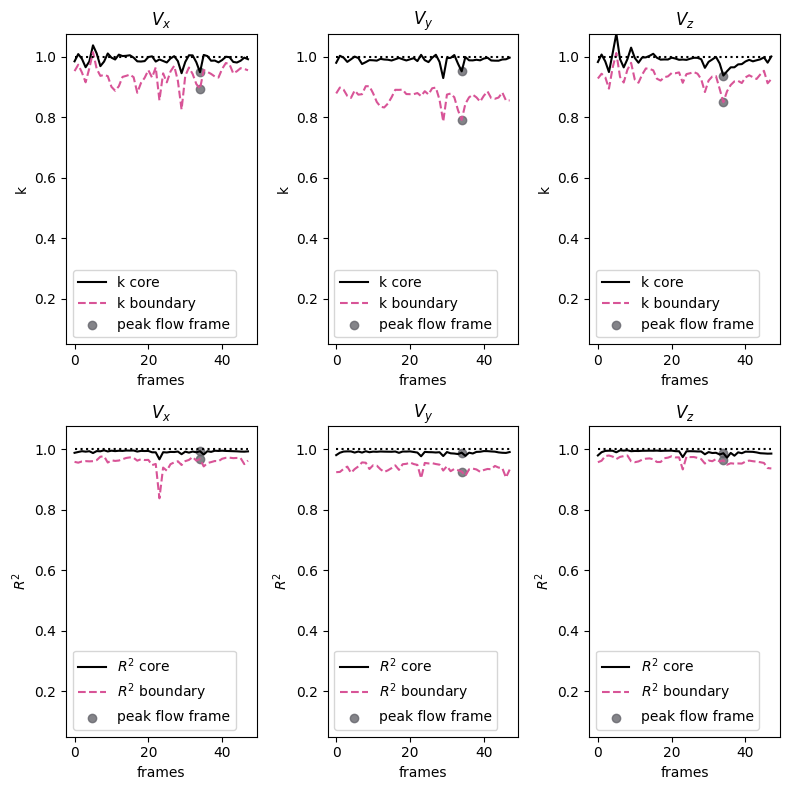

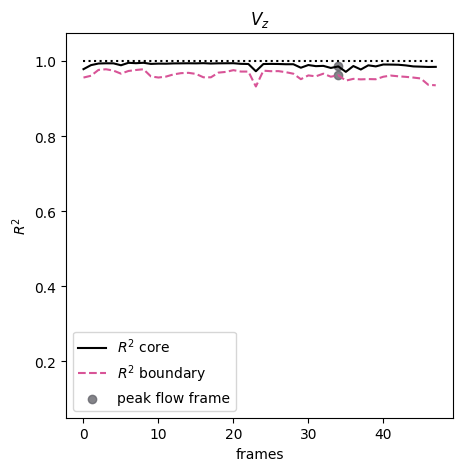

In [14]:
plot_k_r2_vals(gt, pred, bounds, peak_flow_frame,color_b = KTH_colors['pink100'] , save_as= 'prediction')


# vel_plotname = [r'$V_x$', r'$V_y$', r'$V_z$']


# print('Peak flow frame:', peak_flow_frame)
# frames = gt['mean_speed'].shape[0]
# k = np.zeros(3*frames)
# r2 = np.zeros(3*frames)
# k_bounds = np.zeros(3*frames)
# r2_bounds = np.zeros(3*frames)
# bounds_mask = bounds.copy()
# inner_mask = gt['mask'] - bounds_mask

# #calculate k values in core and boundary region
# for i, vel in enumerate(vel_colnames):
#     for t in range(frames):
#         k[t+i*frames], r2[t+i*frames]  = calculate_k_R2( pred[vel][t], gt[vel][t], core_mask[t])
#         k_bounds[t+i*frames], r2_bounds[t+i*frames]  = calculate_k_R2( pred[vel][t], gt[vel][t], bounds[t])

# min_val = np.minimum(0.05, np.minimum(np.min(k_bounds), np.min(r2_bounds)))
# max_val = np.maximum(np.max(k), np.max(r2))
# #make subplots
# for i, (vel, title) in enumerate(zip(vel_colnames, vel_plotname)):
#     plt.subplot(2, 3, i+1)
#     plt.plot(range(frames), k[i*frames:i*frames+frames] , label = 'k core', color = 'black')
#     plt.plot(range(frames), k_bounds[i*frames:i*frames+frames] ,'--',  label = 'k boundary', color = KTH_colors['pink100'])
#     plt.plot(np.ones(frames), 'k:')
#     plt.ylim([min_val, np.maximum(max_val, 1.05)])
#     plt.title(title)
#     plt.xlabel('frames')
#     plt.ylabel('k')
#     plt.scatter(np.ones(2)*peak_flow_frame, [k[i*frames+peak_flow_frame],k_bounds[i*frames+peak_flow_frame]] , label = 'peak flow frame', color = KTH_colors['blue80'])
#     plt.legend()
# for i, (vel, title) in enumerate(zip(vel_colnames, vel_plotname)):
#     plt.subplot(2, 3, i+4)
#     plt.plot(range(frames), r2[i*frames:i*frames+frames] ,label = r'$R^2$ core', color = 'black')
#     plt.plot(range(frames), r2_bounds[i*frames:i*frames+frames] ,'--', label = r'$R^2$ boundary', color = KTH_colors['pink100'])
#     plt.plot(np.ones(frames), 'k:')
#     plt.ylim([min_val, np.maximum(max_val, 1.05)])
#     plt.title(title)
#     plt.xlabel('frames')
#     plt.ylabel(r'$R^2$')
#     plt.scatter(np.ones(2)*peak_flow_frame, [r2[i*frames+peak_flow_frame], r2_bounds[i*frames+peak_flow_frame]] , label = 'peak flow frame', color = KTH_colors['blue80'])
#     plt.legend()

# plt.tight_layout()
# plt.savefig(f'{eval_dir}/k_vals_{set_name}.svg')

# #save each plot separately
# plt.figure(figsize=(5, 5))
# for i, (vel, title) in enumerate(zip(vel_colnames, vel_plotname)):
#     plt.clf()
#     plt.plot(range(frames), k[i*frames:i*frames+frames] , label = 'k core', color = 'black')
#     plt.plot(range(frames), k_bounds[i*frames:i*frames+frames] ,'--',  label = 'k boundary', color = KTH_colors['pink100'])
#     plt.plot(np.ones(frames), 'k:')
#     plt.ylim([min_val, np.maximum(max_val, 1.05)])
#     plt.title(title)
#     plt.xlabel('frames')
#     plt.ylabel('k')
#     plt.scatter(np.ones(2)*peak_flow_frame, [k[i*frames+peak_flow_frame],k_bounds[i*frames+peak_flow_frame]] , label = 'peak flow frame', color = KTH_colors['blue80'])
#     plt.legend()
#     plt.savefig(f'{eval_dir}/k_vals_{vel}_{set_name}.svg', bbox_inches='tight')
# for i, (vel, title) in enumerate(zip(vel_colnames, vel_plotname)):
#     plt.clf()
#     plt.plot(range(frames), r2[i*frames:i*frames+frames] ,label = r'$R^2$ core', color = 'black')
#     plt.plot(range(frames), r2_bounds[i*frames:i*frames+frames] ,'--', label = r'$R^2$ boundary', color = KTH_colors['pink100'])
#     plt.plot(np.ones(frames), 'k:')
#     plt.ylim([min_val, np.maximum(max_val, 1.05)])
#     plt.title(title)
#     plt.xlabel('frames')
#     plt.ylabel(r'$R^2$')
#     plt.scatter(np.ones(2)*peak_flow_frame, [r2[i*frames+peak_flow_frame], r2_bounds[i*frames+peak_flow_frame]] , label = 'peak flow frame', color = KTH_colors['blue80'])
#     plt.legend()
#     plt.savefig(f'{eval_dir}/R2_vals_{vel}_M{model_name}_{set_name}_.svg', bbox_inches='tight')




R^2 for linear and cubic interpolation

Peak flow frame: 34


Average k vals core 0.9989785786519008
Average k vals boundary 0.9880734497253737
Min k vals core 0.9598472604137762
Min k vals boundary 0.8604009535909702
Max k vals core 1.0332291851042095
Max k vals boundary 1.074494894007134
Average k vals core 0.998492921722782
Average k vals boundary 0.9914751207481081
Min k vals core 0.9455317855235659
Min k vals boundary 0.8928828125014414
Max k vals core 1.0234818075608385
Max k vals boundary 1.041892712731379
Average k vals core 1.0006590456111424
Average k vals boundary 0.9971712107559594
Min k vals core 0.9344382502867894
Min k vals boundary 0.9168811390513445
Max k vals core 1.0704200080708723
Max k vals boundary 1.0636972312810296
Average R2 vals core 0.9332356022378505
Average R2 vals boundary 0.48017036905287447
Average R2 vals core 0.9272989742578405
Average R2 vals boundary 0.47163447327814906
Average R2 vals core 0.9224019535393395
Average R2 vals boundary 0.522971649011995
Peak flow frame: 34
Average k vals core 0.9922462702407725
A

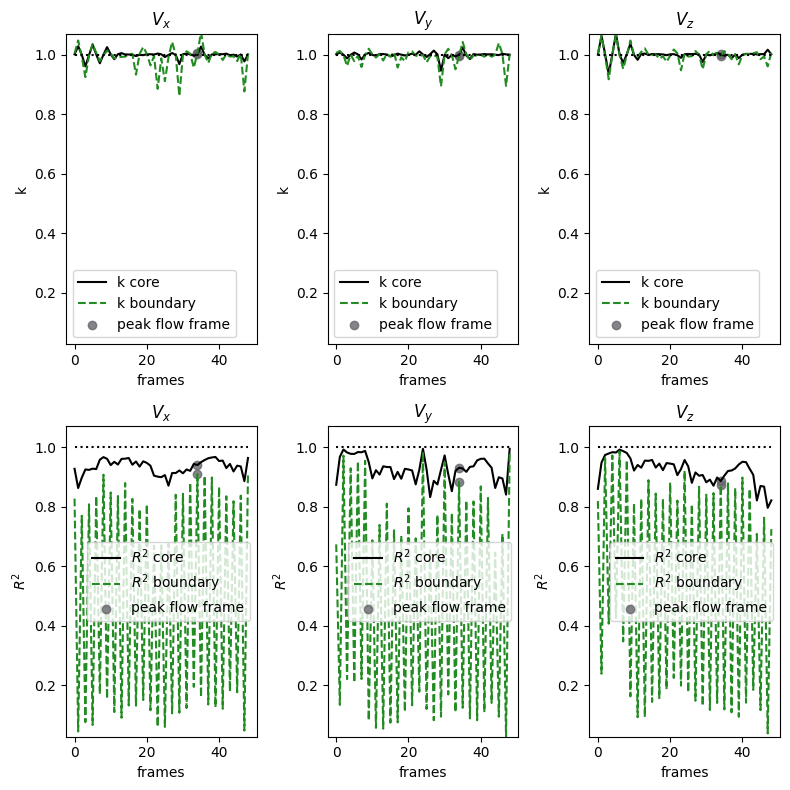

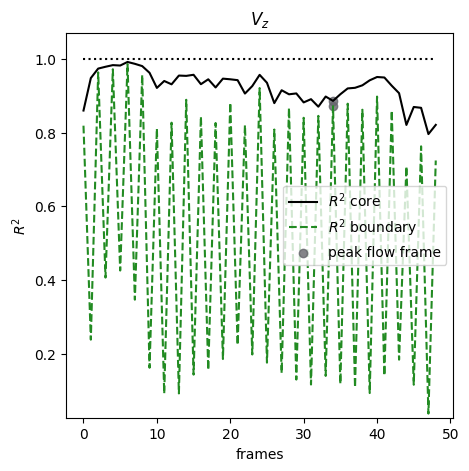

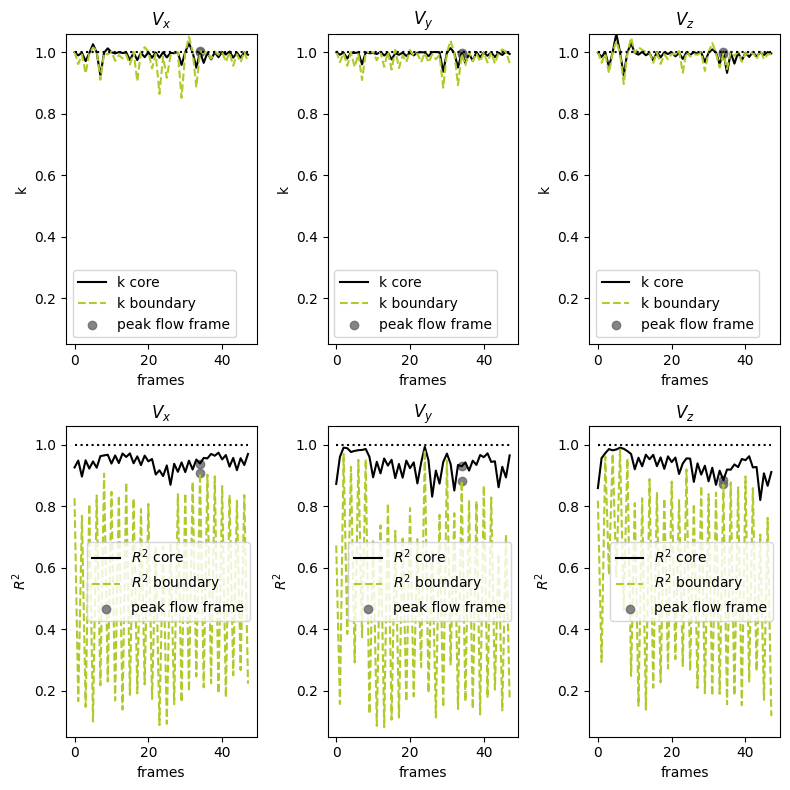

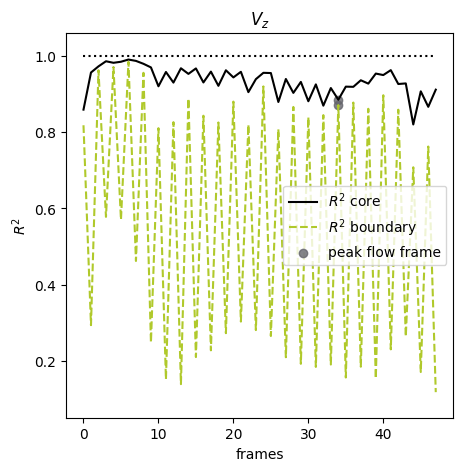

In [13]:
peak_flow_frame = np.argmax(gt['mean_speed'])

plot_k_r2_vals(gt, interpolate_cubic, bounds, peak_flow_frame,color_b = 'forestgreen' , save_as= 'cubic_interpolation')

gt['mean_speed'] = gt['mean_speed'][:-1]

plot_k_r2_vals(gt, interpolate_linear, bounds, peak_flow_frame,color_b = KTH_colors['green100'] , save_as= 'lin_interpolation')


In [ ]:
vel_plotname = [r'$V_x$', r'$V_y$', r'$V_z$']
name_evaluation = model_name
peak_flow_frame = np.unravel_index(np.argmax(gt['speed']), shape = gt['speed'].shape)[0]


def plt_k_r2_subplots(gt,pred,  bounds, color_b = KTH_colors['pink100']):

    print('Peak flow frame:', peak_flow_frame)
    frames = gt['mean_speed'].shape[0]
    k, r2, k_bounds,r2_bounds  = np.zeros(3*frames), np.zeros(3*frames), np.zeros(3*frames), np.zeros(3*frames)
    bounds_mask = bounds.copy()
    inner_mask = gt['mask'] - bounds_mask
    #calculate k values in core and boundary region
    for i, vel in enumerate(vel_colnames):
        for t in range(frames):
            k[t+i*frames], r2[t+i*frames]  = calculate_k_R2( pred[vel][t], gt[vel][t], core_mask[t])
            k_bounds[t+i*frames], r2_bounds[t+i*frames]  = calculate_k_R2( pred[vel][t], gt[vel][t], bounds[t])

    min_val = np.minimum(0.05, np.minimum(np.min(k_bounds), np.min(r2_bounds)))
    max_val = np.maximum(np.max(k), np.max(r2))
    #make subplots
    for i, (vel, title) in enumerate(zip(vel_colnames, vel_plotname)):
        plt.subplot(2, 3, i+1)
        plt.plot(range(frames), k[i*frames:i*frames+frames] , label = 'k core', color = 'black')
        plt.plot(range(frames), k_bounds[i*frames:i*frames+frames] ,'--',  label = 'k boundary', color = color_b)
        plt.plot(np.ones(frames), 'k:')
        plt.ylim([min_val, np.maximum(max_val, 1.05)])
        plt.title(title)
        plt.xlabel('frames')
        plt.ylabel('k')
        plt.scatter(np.ones(2)*peak_flow_frame, [k[i*frames+peak_flow_frame],k_bounds[i*frames+peak_flow_frame]] ,  color = KTH_colors['blue80'])
        plt.legend()
    for i, (vel, title) in enumerate(zip(vel_colnames, vel_plotname)):
        plt.subplot(2, 3, i+4)
        plt.plot(range(frames), r2[i*frames:i*frames+frames] ,label = r'$R^2$ core', color = 'black')
        plt.plot(range(frames), r2_bounds[i*frames:i*frames+frames] ,'--', label = r'$R^2$ boundary', color = color_b)
        plt.plot(np.ones(frames), 'k:')
        plt.ylim([min_val, np.maximum(max_val, 1.05)])
        plt.title(title)
        plt.xlabel('frames')
        plt.ylabel(r'$R^2$')
        plt.scatter(np.ones(2)*peak_flow_frame, [r2[i*frames+peak_flow_frame], r2_bounds[i*frames+peak_flow_frame]] ,  color = KTH_colors['blue80'])
        plt.legend()

        plt.tight_layout()

plt_k_r2_subplots(gt,pred,  bounds, color_b = KTH_colors['pink100'])
plt_k_r2_subplots(gt,interpolate_linear,  bounds, color_b = KTH_colors['green100'])
plt_k_r2_subplots(gt,interpolate_cubic,  bounds, color_b = 'forestgreen')
# plt.savefig(f'{eval_dir}/k_vals_{name_evaluation}.svg')

# #save each plot separately
# plt.figure(figsize=(5, 5))
# for i, (vel, title) in enumerate(zip(vel_colnames, vel_plotname)):
#     plt.clf()
#     plt.plot(range(frames), k[i*frames:i*frames+frames] , label = 'k core', color = 'black')
#     plt.plot(range(frames), k_bounds[i*frames:i*frames+frames] ,'--',  label = 'k boundary', color = KTH_colors['pink100'])
#     plt.plot(np.ones(frames), 'k:')
#     plt.ylim([min_val, np.maximum(max_val, 1.05)])
#     plt.title(title)
#     plt.xlabel('frames')
#     plt.ylabel('k')
#     plt.scatter(np.ones(2)*peak_flow_frame, [k[i*frames+peak_flow_frame],k_bounds[i*frames+peak_flow_frame]] , label = 'peak flow frame', color = KTH_colors['blue80'])
#     plt.legend()
#     plt.savefig(f'{eval_dir}/k_vals_{vel}_{name_evaluation}_.svg', bbox_inches='tight')
# for i, (vel, title) in enumerate(zip(vel_colnames, vel_plotname)):
#     plt.clf()
#     plt.plot(range(frames), r2[i*frames:i*frames+frames] ,label = r'$R^2$ core', color = 'black')
#     plt.plot(range(frames), r2_bounds[i*frames:i*frames+frames] ,'--', label = r'$R^2$ boundary', color = KTH_colors['pink100'])
#     plt.plot(np.ones(frames), 'k:')
#     plt.ylim([min_val, np.maximum(max_val, 1.05)])
#     plt.title(title)
#     plt.xlabel('frames')
#     plt.ylabel(r'$R^2$')
#     plt.scatter(np.ones(2)*peak_flow_frame, [r2[i*frames+peak_flow_frame], r2_bounds[i*frames+peak_flow_frame]] , label = 'peak flow frame', color = KTH_colors['blue80'])
#     plt.legend()
#     plt.savefig(f'{eval_dir}/R2_vals_{vel}_{name_evaluation}_.svg', bbox_inches='tight')




### Plot line development in time

In [ ]:

#def show_temporal_development_line(gt, lr, pred, mask, axis, indices, save_as = "Temporal_development.png"):
@widgets.interact(x=(0, gt["u"].shape[1]-1), y = (0, gt["u"].shape[2]-1), vel=vel_colnames_fluid, axis=(1, 3))
def f_temporal_development_lines(x = 30,y =40, vel = "u", axis =1):

        indices = (x, y)
        def get_line(data):
            #returns line in 4D data over all time steps
            x,y = indices
            if axis == 1:
                return data[:, :, x, y]
            elif axis == 2:
                return data[:, x, :, y]
            elif axis == 3:
                return data[:, x,  y, :]
            else:
                print("Invalid axis: Please choose axis 1, 2, 3")

        prediction = get_line(pred[vel]).transpose()
        ground_truth = get_line(gt[vel]).transpose()
        low_resolution= get_line(interpolate_NN[vel]).transpose()

        min_v = np.min([np.min(prediction), np.min(ground_truth), np.min(low_resolution)])
        max_v = np.max([np.max(prediction), np.max(ground_truth), np.max(low_resolution)])


        plt.subplot(1, 3, 1)
        plt.imshow(low_resolution, vmin = min_v, vmax = max_v, cmap='jet')
        plt.title("LR")
        plt.xlabel('t')
        plt.yticks([])

        plt.subplot(1, 3, 2)
        plt.imshow(ground_truth, vmin = min_v, vmax = max_v, cmap='jet')
        plt.title("GT")
        plt.xticks([])
        plt.yticks([])

        plt.subplot(1, 3, 3)
        plt.imshow(prediction, vmin = min_v, vmax = max_v, cmap='jet')
        plt.title("SR")
        plt.xticks([])
        plt.yticks([])

### Plot peak flow development

In [ ]:
#Params for plot
patch_size = 1
show_avg = True
show_pixel = True

def show_peak_flow_pixel(lr_data, hr_data,pred_data,  patch_size, show_avg, show_pixel):
    plt.figure(figsize=(7, 5))
    idx_max = np.unravel_index(np.argmax(hr_data['speed']), shape = hr_data['speed'].shape)
    x = np.arange(hr_data['speed'].shape[0])
    if show_pixel:
        plt.plot(x, hr_data['speed'][:, idx_max[1], idx_max[2], idx_max[3]]*100,  label = 'ground truth pixel', color = 'black')
        plt.plot(x[0::2], lr['speed'][:, idx_max[1], idx_max[2], idx_max[3]]*100,'-o' ,label = 'low resolution pixel', color= 'yellowgreen')
        plt.plot(x, pred['speed'][:, idx_max[1], idx_max[2], idx_max[3]]*100,'--', label = 'prediction pixel')

    if show_avg:
        plt.plot(x,         np.average(hr_data['speed']  [:, idx_max[1]-patch_size:idx_max[1]+patch_size+1, idx_max[2]-patch_size:idx_max[2]+patch_size+1, idx_max[3]-patch_size:idx_max[3]+patch_size+1], axis = (1, 2, 3))*100,  label = 'ground truth avg', color = 'grey')
        plt.plot(x[0::2],    np.average(lr_data['speed']  [:, idx_max[1]-patch_size:idx_max[1]+patch_size+1, idx_max[2]-patch_size:idx_max[2]+patch_size+1, idx_max[3]-patch_size:idx_max[3]+patch_size+1], axis = (1, 2, 3))*100,'-o' ,label = 'low resolution avg', color = 'olive')
        plt.plot(x,         np.average(pred_data['speed'][:, idx_max[1]-patch_size:idx_max[1]+patch_size+1, idx_max[2]-patch_size:idx_max[2]+patch_size+1, idx_max[3]-patch_size:idx_max[3]+patch_size+1], axis = (1, 2, 3))*100,'--', label = 'prediction avg', color = 'navy' )
    if show_avg:
        plt.title(f"Speed at voxel {idx_max[1::]} with average of number of voxels: {(2*patch_size+1)**3}")
    else:
        plt.title(f"Speed at voxel with index {idx_max[1::]}")
    plt.ylabel('Speed (cm/s)')
    plt.ylabel('Speed (cm/s)')
    plt.xlabel('Frame')
    plt.legend()
    plt.savefig(f'{eval_dir}/Peak_flow_frame_avg.svg',bbox_inches='tight')
    plt.show()

show_peak_flow_pixel(lr, gt, pred, patch_size, show_avg, show_pixel)

------------ data_model 2------------
M2_2mm_step2_static_dynamic.h5 M2_2mm_step2_static_dynamic_noise.h5
(50, 84, 60, 96)


pred shape (50, 84, 60, 96)
pred shape (50, 84, 60, 96)
pred shape (50, 84, 60, 96)
max/min before tanh 43077.445 0.0
max/min after tanh 1.0 0.0
Average RE 16.307828016631426
Average RMSE u/v/w 0.01301776 0.011513504 0.012219652
------------ data_model 3------------
M3_2mm_step2_static_dynamic.h5 M3_2mm_step2_static_dynamic_noise.h5
(50, 72, 82, 84)
pred shape (50, 72, 82, 84)
pred shape (50, 72, 82, 84)
pred shape (50, 72, 82, 84)
max/min before tanh 14669.429 0.0
max/min after tanh 1.0 0.0
Average RE 23.732355775355494
Average RMSE u/v/w 0.0055608964 0.0051478865 0.005516725
------------ data_model 1------------
M1_2mm_step2_static_dynamic.h5 M1_2mm_step2_static_dynamic_noise.h5
(50, 72, 70, 76)
pred shape (50, 72, 70, 76)
pred shape (50, 72, 70, 76)
pred shape (50, 72, 70, 76)
max/min before tanh 22046.861 0.0
max/min after tanh 1.0 0.0
Average RE 23.995897837633187
Average RMSE u/v/w 0.011896643 0.009722766 0.011270503
------------ data_model 4------------
M4_2mm_step2_static_dynam

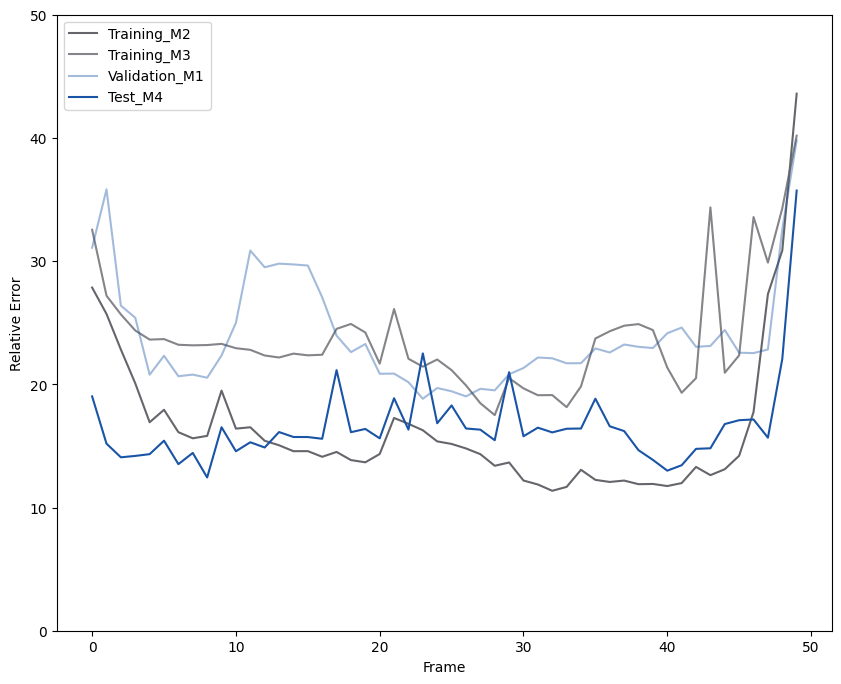

In [16]:
# find RE for all sets
sets_all = ['Training','Training', 'Validation', 'Test']
data_models = ['2', '3', '1', '4']
colors = [KTH_colors['grey100'], KTH_colors['grey80'], KTH_colors['blue40'], KTH_colors['blue100']]
for set_name, data_model, c in zip(sets_all, data_models, colors):
    print(f'------------ data_model {data_model}------------')
    lr, gt, pred, temporal_mask, eval_dir = load_data(model_name, set_name, data_model, step, use_dynamical_mask, ending_file=add_ending)
    rel_error = calculate_relative_error_normalized(pred["u"], pred["v"], pred["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])
    RMSE = np.zeros_like(rel_error)
    RMSE_u = np.sqrt(np.mean((pred['u']-gt['u'])**2, axis = (1, 2, 3), where=np.array(gt['mask'],dtype = bool)))
    RMSE_v = np.sqrt(np.mean((pred['v']-gt['v'])**2, axis = (1, 2, 3), where=np.array(gt['mask'],dtype = bool)))
    RMSE_w = np.sqrt(np.mean((pred['w']-gt['w'])**2, axis = (1, 2, 3), where=np.array(gt['mask'],dtype = bool)))
    print('Average RE', np.average(rel_error))
    print('Average RMSE u/v/w', np.average(RMSE_u), np.average(RMSE_v),np.average(RMSE_w))
    plt.plot(rel_error, label = f'{set_name}_M{data_model}', color = c)

plt.legend()
plt.ylim([0, 50])
plt.xlabel('Frame')
plt.ylabel('Relative Error')
plt.savefig(f'{eval_dir}/Relative_error_all_sets.svg',bbox_inches='tight')
